# Eval runs

In [ ]:
#! pip install pandas
#! pip install matplotlib
#! pip install scipy
#! pip install seaborn
#! pip install nbconvert
#! pip install matplotlib-venn
! jupyter nbconvert --to HTML PoseErrorAnalysis.ipynb

[NbConvertApp] Converting notebook PoseErrorAnalysis.ipynb to HTML
[NbConvertApp] WARNING | Alternative text is missing on 16 image(s).
[NbConvertApp] Writing 8865341 bytes to PoseErrorAnalysis.html


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pathlib import Path
from PIL import Image 
import sys
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.interpolate import griddata
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt
import seaborn as sns


sys.path.append("../")  # from src/notebooks to src/

from util.datapipeline.EmbeddingDataset import EmbeddingDataset

pd.set_option('display.max_columns', None)

In [31]:

dataset = EmbeddingDataset(r"F:/Face/data/dataset15_emb/rgb_bff_crop261_emb-edgeface", disable_tqdm=False)

Loading classes: 100%|██████████| 1041/1041 [03:58<00:00,  4.36it/s]


In [32]:
def compute_average_heatmaps(
    dataset,
    center_pose=(0, 0),
    B_ratio=50,
    prefix="",
    visualize=True
):
    N = len(dataset)

    # ------------------------------------------------------------
    # Pose grid (from first sample, assumed consistent)
    # ------------------------------------------------------------
    _, _, _, _, poses_ref, _ = dataset[0]
    poses_ref = np.array([tuple(map(int, p)) for p in poses_ref])

    pitches = np.unique(poses_ref[:, 0])
    yaws    = np.unique(poses_ref[:, 1])

    H, W = len(pitches), len(yaws)

    grid_pitch, grid_yaw = np.meshgrid(pitches, yaws, indexing="ij")
    grid_points = np.stack([grid_pitch.ravel(), grid_yaw.ravel()], axis=1)

    num_poses = len(poses_ref)

    # ------------------------------------------------------------
    # Pose → heatmap index mapping (for visualization)
    # ------------------------------------------------------------
    pitch_to_idx = {p: i for i, p in enumerate(pitches)}
    yaw_to_idx   = {y: j for j, y in enumerate(yaws)}

    pose_y = np.array([pitch_to_idx[p] for p, _ in poses_ref])
    pose_x = np.array([yaw_to_idx[y]   for _, y in poses_ref])

    # ------------------------------------------------------------
    # Precompute labels + center pose indices
    # ------------------------------------------------------------
    labels = np.empty(N, dtype=np.int32)
    center_indices = np.full(N, -1, dtype=np.int32)

    for i, (_, label, _, _, poses, _) in enumerate(
        tqdm(dataset, desc="Prepare Dataset")
    ):
        labels[i] = label
        poses = [tuple(map(int, p)) for p in poses]

        if center_pose in poses:
            center_indices[i] = poses.index(center_pose)

    # ------------------------------------------------------------
    # Random B sampling
    # ------------------------------------------------------------
    B_indices = np.random.choice(N, size=N // B_ratio, replace=False)

    # ------------------------------------------------------------
    # Accumulators
    # ------------------------------------------------------------
    same_pose_sum = np.zeros(num_poses, dtype=np.float32)
    diff_pose_sum = np.zeros(num_poses, dtype=np.float32)
    same_count = 0
    diff_count = 0

    # ------------------------------------------------------------
    # Main loop
    # ------------------------------------------------------------
    for i in tqdm(range(N), desc="Compute distances"):
        emb_a, label_a, _, _, _, _ = dataset[i]
        emb_a = F.normalize(emb_a, dim=-1)

        for j in B_indices:
            center_idx = center_indices[j]
            if center_idx < 0:
                continue

            emb_j, _, _, _, _, _ = dataset[j]
            emb_center = F.normalize(emb_j[center_idx], dim=-1)

            sims = torch.matmul(emb_a, emb_center).clamp(0, 1).mul(100)
            sims_np = sims.cpu().numpy()

            if label_a == labels[j]:
                same_pose_sum += sims_np
                same_count += 1
            else:
                diff_pose_sum += sims_np
                diff_count += 1

    # ------------------------------------------------------------
    # Average in pose space
    # ------------------------------------------------------------
    same_pose_avg = same_pose_sum / max(same_count, 1)
    diff_pose_avg = diff_pose_sum / max(diff_count, 1)

    # ------------------------------------------------------------
    # Interpolation
    # ------------------------------------------------------------
    interp_same = LinearNDInterpolator(poses_ref, same_pose_avg, fill_value=np.nan)
    interp_diff = LinearNDInterpolator(poses_ref, diff_pose_avg, fill_value=np.nan)

    heat_same = interp_same(grid_points).reshape(H, W)
    heat_diff = interp_diff(grid_points).reshape(H, W)

    # ------------------------------------------------------------
    # NaN handling
    # ------------------------------------------------------------
    if np.isnan(heat_same).any():
        heat_same[np.isnan(heat_same)] = 0

    if np.isnan(heat_diff).any():
        heat_diff[np.isnan(heat_diff)] = 0

    # ------------------------------------------------------------
    # Visualization + SVG export (with masked invalid corners)
    # ------------------------------------------------------------
    if visualize:
        difference = heat_same - heat_diff

        # --------------------------------------------------------
        # Build validity mask BEFORE NaN fill
        # --------------------------------------------------------
        raw_same = interp_same(grid_points).reshape(H, W)
        raw_diff = interp_diff(grid_points).reshape(H, W)

        valid_mask = (~np.isnan(raw_same)) & (~np.isnan(raw_diff))
        valid_mask &= (heat_same != 0) & (heat_diff != 0)

        heat_same_plot = np.ma.masked_where(~valid_mask, heat_same)
        heat_diff_plot = np.ma.masked_where(~valid_mask, heat_diff)
        diff_plot      = np.ma.masked_where(~valid_mask, difference)

        plt.rcParams.update({
            "font.size": 16,
            "axes.titlesize": 26,
            "xtick.labelsize": 18,
            "ytick.labelsize": 18,
        })

        cmap_main = plt.cm.viridis.copy()
        cmap_main.set_bad(color="black")

        cmap_diff = plt.cm.coolwarm.copy()
        cmap_diff.set_bad(color="black")

        # ========================================================
        # SAME IDENTITY
        # ========================================================
        fig1, ax1 = plt.subplots(figsize=(22, 20))

        sns.heatmap(
            heat_same_plot,
            ax=ax1,
            xticklabels=yaws,
            yticklabels=pitches,
            vmin=0,
            vmax=100,
            cmap=cmap_main,
            square=True,
            cbar_kws={"shrink": 0.8, "label": "Similarity"}
        )

        #ax1.scatter(pose_x + 0.5, pose_y + 0.5, s=12, c="white", edgecolors="black", linewidths=0.4)
        for x, y in zip(pose_x, pose_y):
            val = heat_same[y, x]
            ax1.text(
                x + 0.5, y + 0.5,
                f"{val:.0f}",
                ha="center",
                va="center",
                fontsize=8,
                color="white"
            )

        ax1.set_title("Same Identity")
        ax1.set_xlabel("Yaw")
        ax1.set_ylabel("Pitch")
        # show only every 5th tick label
        for i, label in enumerate(ax1.get_xticklabels()):
            if i % 5 != 0:
                label.set_visible(False)

        for i, label in enumerate(ax1.get_yticklabels()):
            if i % 5 != 0:
                label.set_visible(False)

        fig1.savefig(f"{prefix}-heatmap_same_identity.svg", format="svg", dpi=300, bbox_inches="tight")
        plt.show()

        # ========================================================
        # DIFFERENT IDENTITY
        # ========================================================
        fig2, ax2 = plt.subplots(figsize=(22, 20))

        sns.heatmap(
            heat_diff_plot,
            ax=ax2,
            xticklabels=yaws,
            yticklabels=pitches,
            vmin=0,
            vmax=100,
            cmap=cmap_main,
            square=True,
            cbar_kws={"shrink": 0.8, "label": "Similarity"}
        )

        #ax2.scatter(pose_x + 0.5, pose_y + 0.5, s=12, c="white", edgecolors="black", linewidths=0.4)
        for x, y in zip(pose_x, pose_y):
            val = heat_diff[y, x]
            ax2.text(
                x + 0.5, y + 0.5,
                f"{val:.0f}",
                ha="center",
                va="center",
                fontsize=8,
                color="white"
            )

        ax2.set_title("Different Identity")
        ax2.set_xlabel("Yaw")
        ax2.set_ylabel("Pitch")
        # show only every 5th tick label
        for i, label in enumerate(ax2.get_xticklabels()):
            if i % 5 != 0:
                label.set_visible(False)

        for i, label in enumerate(ax2.get_yticklabels()):
            if i % 5 != 0:
                label.set_visible(False)

        fig2.savefig(f"{prefix}-heatmap_different_identity.svg", format="svg", dpi=300, bbox_inches="tight")
        plt.show()

        # ========================================================
        # DIFFERENCE MAP
        # ========================================================
        vmax = np.nanmax(np.abs(difference))

        fig3, ax3 = plt.subplots(figsize=(22, 20))

        sns.heatmap(
            diff_plot,
            ax=ax3,
            xticklabels=yaws,
            yticklabels=pitches,
            cmap=cmap_diff,
            center=0,
            vmin=0,
            vmax=vmax,
            square=True,
            cbar_kws={"shrink": 0.8, "label": "Same − Different"}
        )

        #ax3.scatter(pose_x + 0.5, pose_y + 0.5, s=12, c="white", edgecolors="black", linewidths=0.4)
        for x, y in zip(pose_x, pose_y):
            val = difference[y, x]
            ax3.text(
                x + 0.5, y + 0.5,
                f"{val:.0f}",
                ha="center",
                va="center",
                fontsize=8,
                color="white"
            )

        ax3.set_title("Discriminative Power")
        ax3.set_xlabel("Yaw")
        ax3.set_ylabel("Pitch")
        # show only every 5th tick label
        for i, label in enumerate(ax3.get_xticklabels()):
            if i % 5 != 0:
                label.set_visible(False)

        for i, label in enumerate(ax3.get_yticklabels()):
            if i % 5 != 0:
                label.set_visible(False)

        fig3.savefig(f"{prefix}-heatmap_difference.svg", format="svg", dpi=300, bbox_inches="tight")
        plt.show()



    return heat_same, heat_diff, pitches, yaws


Compute distances: 100%|██████████| 19786/19786 [08:57<00:00, 36.81it/s]


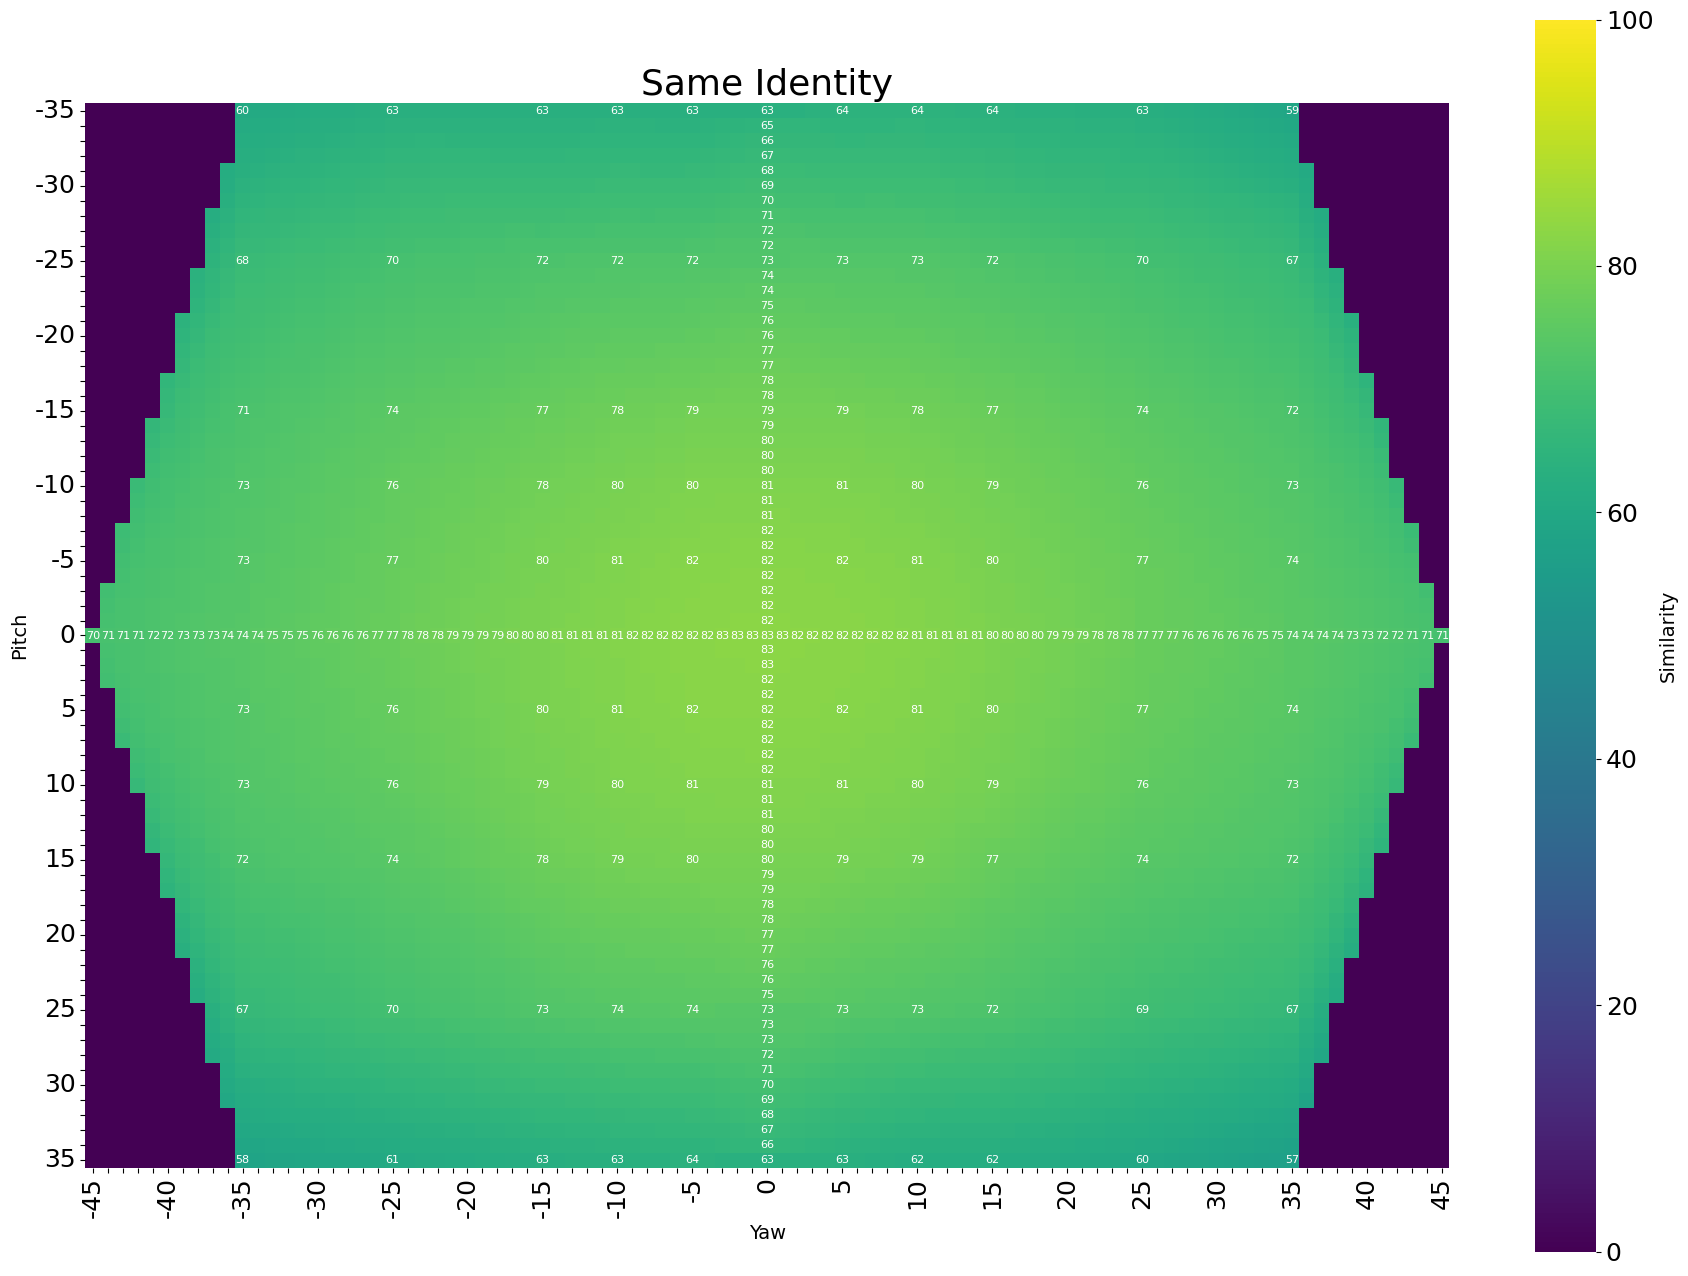

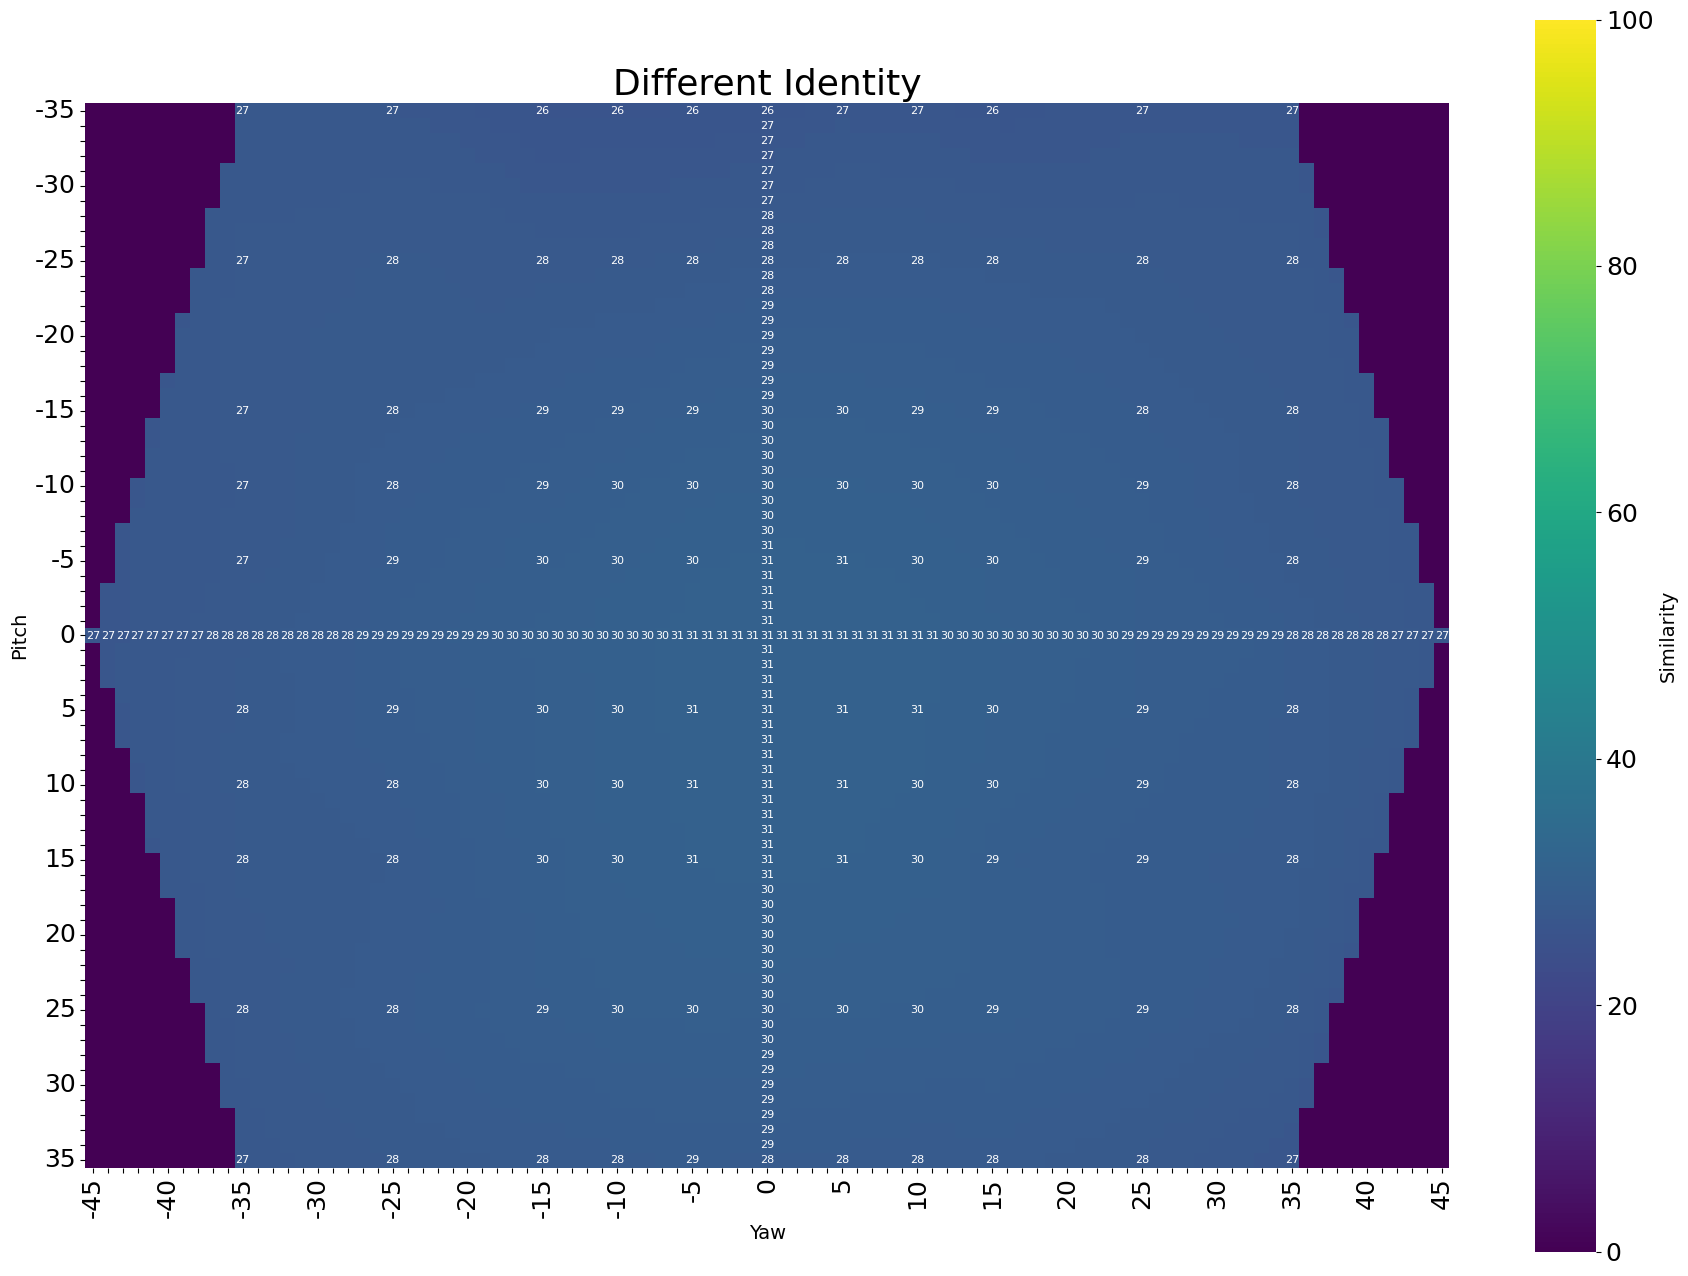

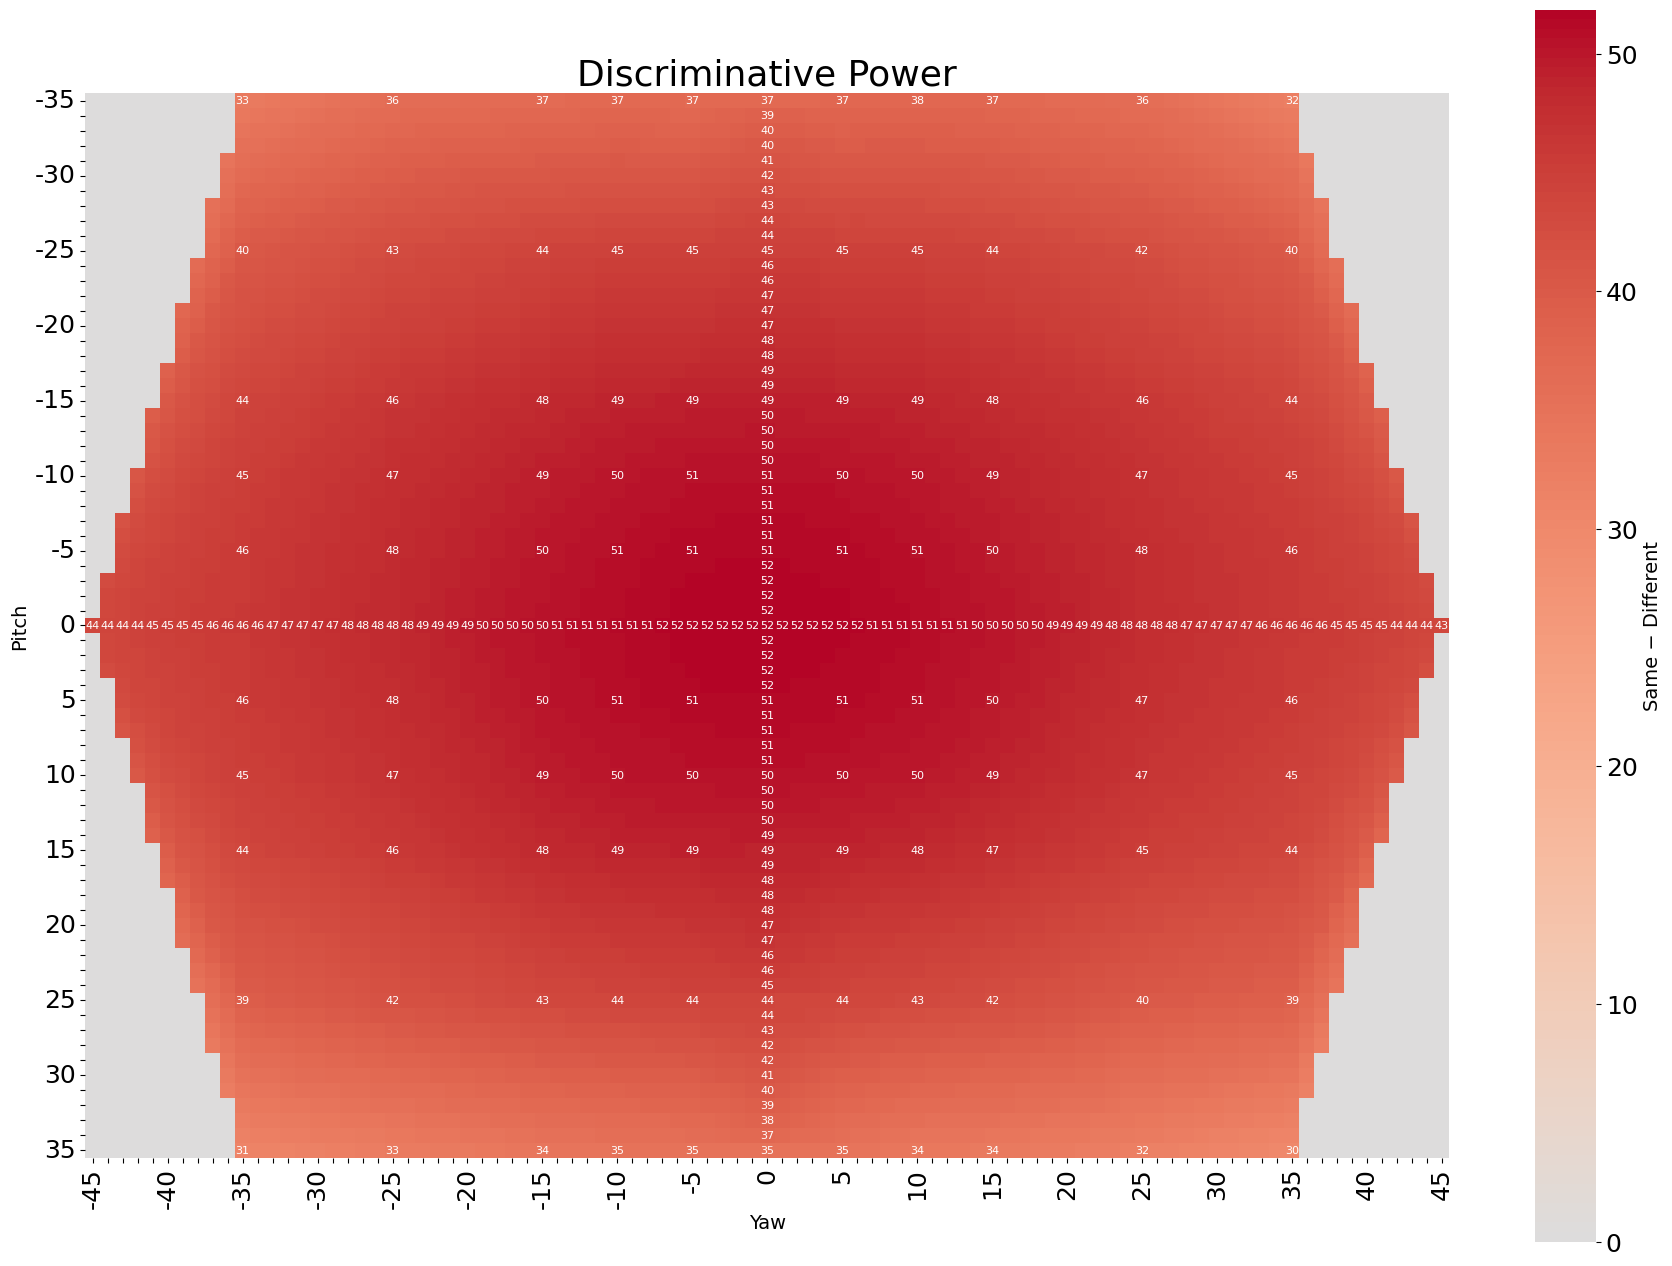

In [33]:
avg_same, avg_diff, pitches, yaws = compute_average_heatmaps(dataset, center_pose=(0, 0), prefix="rgb_bff_crop261_emb-edgeface", visualize=True)

### Headpose aligned comparison

In [34]:
def compute_average_heatmaps_pairwise(dataset, B_ratio=50, prefix="", visualize=True):
    N = len(dataset)

    # ------------------------------------------------------------
    # Pose grid (from first sample, assumed consistent)
    # ------------------------------------------------------------
    _, _, _, _, poses_ref, _ = dataset[0]
    poses_ref = np.array([tuple(map(int, p)) for p in poses_ref])

    pitches = np.unique(poses_ref[:, 0])
    yaws    = np.unique(poses_ref[:, 1])

    H, W = len(pitches), len(yaws)

    grid_pitch, grid_yaw = np.meshgrid(pitches, yaws, indexing="ij")
    grid_points = np.stack([grid_pitch.ravel(), grid_yaw.ravel()], axis=1)

    num_poses = len(poses_ref)

    # ------------------------------------------------------------
    # Pose → heatmap index mapping (for visualization)
    # ------------------------------------------------------------
    pitch_to_idx = {p: i for i, p in enumerate(pitches)}
    yaw_to_idx   = {y: j for j, y in enumerate(yaws)}

    pose_y = np.array([pitch_to_idx[p] for p, _ in poses_ref])
    pose_x = np.array([yaw_to_idx[y]   for _, y in poses_ref])

    # ------------------------------------------------------------
    # Precompute labels
    # ------------------------------------------------------------
    labels = np.empty(N, dtype=np.int32)
    for i, (_, label, _, _, _, _) in enumerate(tqdm(dataset, desc="Prepare Dataset")):
        labels[i] = label

    # ------------------------------------------------------------
    # Random B sampling
    # ------------------------------------------------------------
    B_indices = np.random.choice(N, size=N // B_ratio, replace=False)

    # ------------------------------------------------------------
    # Accumulators
    # ------------------------------------------------------------
    same_pose_sum = np.zeros(num_poses, dtype=np.float32)
    diff_pose_sum = np.zeros(num_poses, dtype=np.float32)
    same_count = 0
    diff_count = 0

    # ------------------------------------------------------------
    # Main loop
    # ------------------------------------------------------------
    for i in tqdm(range(N), desc="Compute distances"):
        emb_a, label_a, _, _, _, _ = dataset[i]
        emb_a = F.normalize(emb_a, dim=-1)

        for j in B_indices:
            emb_b, _, _, _, _, _ = dataset[j]
            emb_b = F.normalize(emb_b, dim=-1)

            sims = (emb_a * emb_b).sum(dim=-1).clamp(0, 1).mul(100)
            sims_np = sims.cpu().numpy()

            if label_a == labels[j]:
                same_pose_sum += sims_np
                same_count += 1
            else:
                diff_pose_sum += sims_np
                diff_count += 1

    # ------------------------------------------------------------
    # Average
    # ------------------------------------------------------------
    same_pose_avg = same_pose_sum / max(same_count, 1)
    diff_pose_avg = diff_pose_sum / max(diff_count, 1)

    # ------------------------------------------------------------
    # Interpolation
    # ------------------------------------------------------------
    interp_same = LinearNDInterpolator(poses_ref, same_pose_avg, fill_value=np.nan)
    interp_diff = LinearNDInterpolator(poses_ref, diff_pose_avg, fill_value=np.nan)

    heat_same = interp_same(grid_points).reshape(H, W)
    heat_diff = interp_diff(grid_points).reshape(H, W)

    # ------------------------------------------------------------
    # NaN handling
    # ------------------------------------------------------------
    if np.isnan(heat_same).any():
        heat_same[np.isnan(heat_same)] = 0

    if np.isnan(heat_diff).any():
        heat_diff[np.isnan(heat_diff)] = 0


    # ------------------------------------------------------------
    # Difference map
    # ------------------------------------------------------------
    difference = heat_same - heat_diff

    # ------------------------------------------------------------
    # Visualization
    # ------------------------------------------------------------
    if visualize:
        cmap_main = "viridis"
        cmap_diff = "coolwarm"

        # ========================================================
        # SAME IDENTITY
        # ========================================================
        fig1, ax1 = plt.subplots(figsize=(22, 20))

        sns.heatmap(
            heat_same,
            ax=ax1,
            xticklabels=yaws,
            yticklabels=pitches,
            vmin=0,
            vmax=100,
            cmap=cmap_main,
            square=True,
            cbar_kws={"shrink": 0.8, "label": "Similarity"}
        )

        for x, y in zip(pose_x, pose_y):
            val = heat_same[y, x]
            ax1.text(
                x + 0.5, y + 0.5,
                f"{val:.0f}",
                ha="center",
                va="center",
                fontsize=8,
                color="white"
            )

        ax1.set_title("Same Identity")
        ax1.set_xlabel("Yaw")
        ax1.set_ylabel("Pitch")

        for i, label in enumerate(ax1.get_xticklabels()):
            if i % 5 != 0:
                label.set_visible(False)

        for i, label in enumerate(ax1.get_yticklabels()):
            if i % 5 != 0:
                label.set_visible(False)

        fig1.savefig(f"{prefix}-heatmap_same_identity-pose_matched.svg", format="svg", dpi=300, bbox_inches="tight")
        plt.show()

        # ========================================================
        # DIFFERENT IDENTITY
        # ========================================================
        fig2, ax2 = plt.subplots(figsize=(22, 20))

        sns.heatmap(
            heat_diff,
            ax=ax2,
            xticklabels=yaws,
            yticklabels=pitches,
            vmin=0,
            vmax=100,
            cmap=cmap_main,
            square=True,
            cbar_kws={"shrink": 0.8, "label": "Similarity"}
        )

        for x, y in zip(pose_x, pose_y):
            val = heat_diff[y, x]
            ax2.text(
                x + 0.5, y + 0.5,
                f"{val:.0f}",
                ha="center",
                va="center",
                fontsize=8,
                color="white"
            )

        ax2.set_title("Different Identity")
        ax2.set_xlabel("Yaw")
        ax2.set_ylabel("Pitch")

        for i, label in enumerate(ax2.get_xticklabels()):
            if i % 5 != 0:
                label.set_visible(False)

        for i, label in enumerate(ax2.get_yticklabels()):
            if i % 5 != 0:
                label.set_visible(False)

        fig2.savefig(f"{prefix}-heatmap_different_identity-pose_matched.svg", format="svg", dpi=300, bbox_inches="tight")
        plt.show()

        # ========================================================
        # DIFFERENCE MAP
        # ========================================================
        vmax = np.nanmax(np.abs(difference))
        diff_plot = difference

        fig3, ax3 = plt.subplots(figsize=(22, 20))

        sns.heatmap(
            diff_plot,
            ax=ax3,
            xticklabels=yaws,
            yticklabels=pitches,
            cmap=cmap_diff,
            center=0,
            vmax=vmax,
            square=True,
            cbar_kws={"shrink": 0.8, "label": "Same − Different"}
        )

        for x, y in zip(pose_x, pose_y):
            val = difference[y, x]
            ax3.text(
                x + 0.5, y + 0.5,
                f"{val:.0f}",
                ha="center",
                va="center",
                fontsize=8,
                color="white"
            )

        ax3.set_title("Discriminative Power")
        ax3.set_xlabel("Yaw")
        ax3.set_ylabel("Pitch")

        for i, label in enumerate(ax3.get_xticklabels()):
            if i % 5 != 0:
                label.set_visible(False)

        for i, label in enumerate(ax3.get_yticklabels()):
            if i % 5 != 0:
                label.set_visible(False)

        fig3.savefig(f"{prefix}-heatmap_difference-pose_matched.svg", format="svg", dpi=300, bbox_inches="tight")
        plt.show()

    return heat_same, heat_diff, difference, pitches, yaws

Compute distances: 100%|██████████| 19786/19786 [14:47<00:00, 22.28it/s]


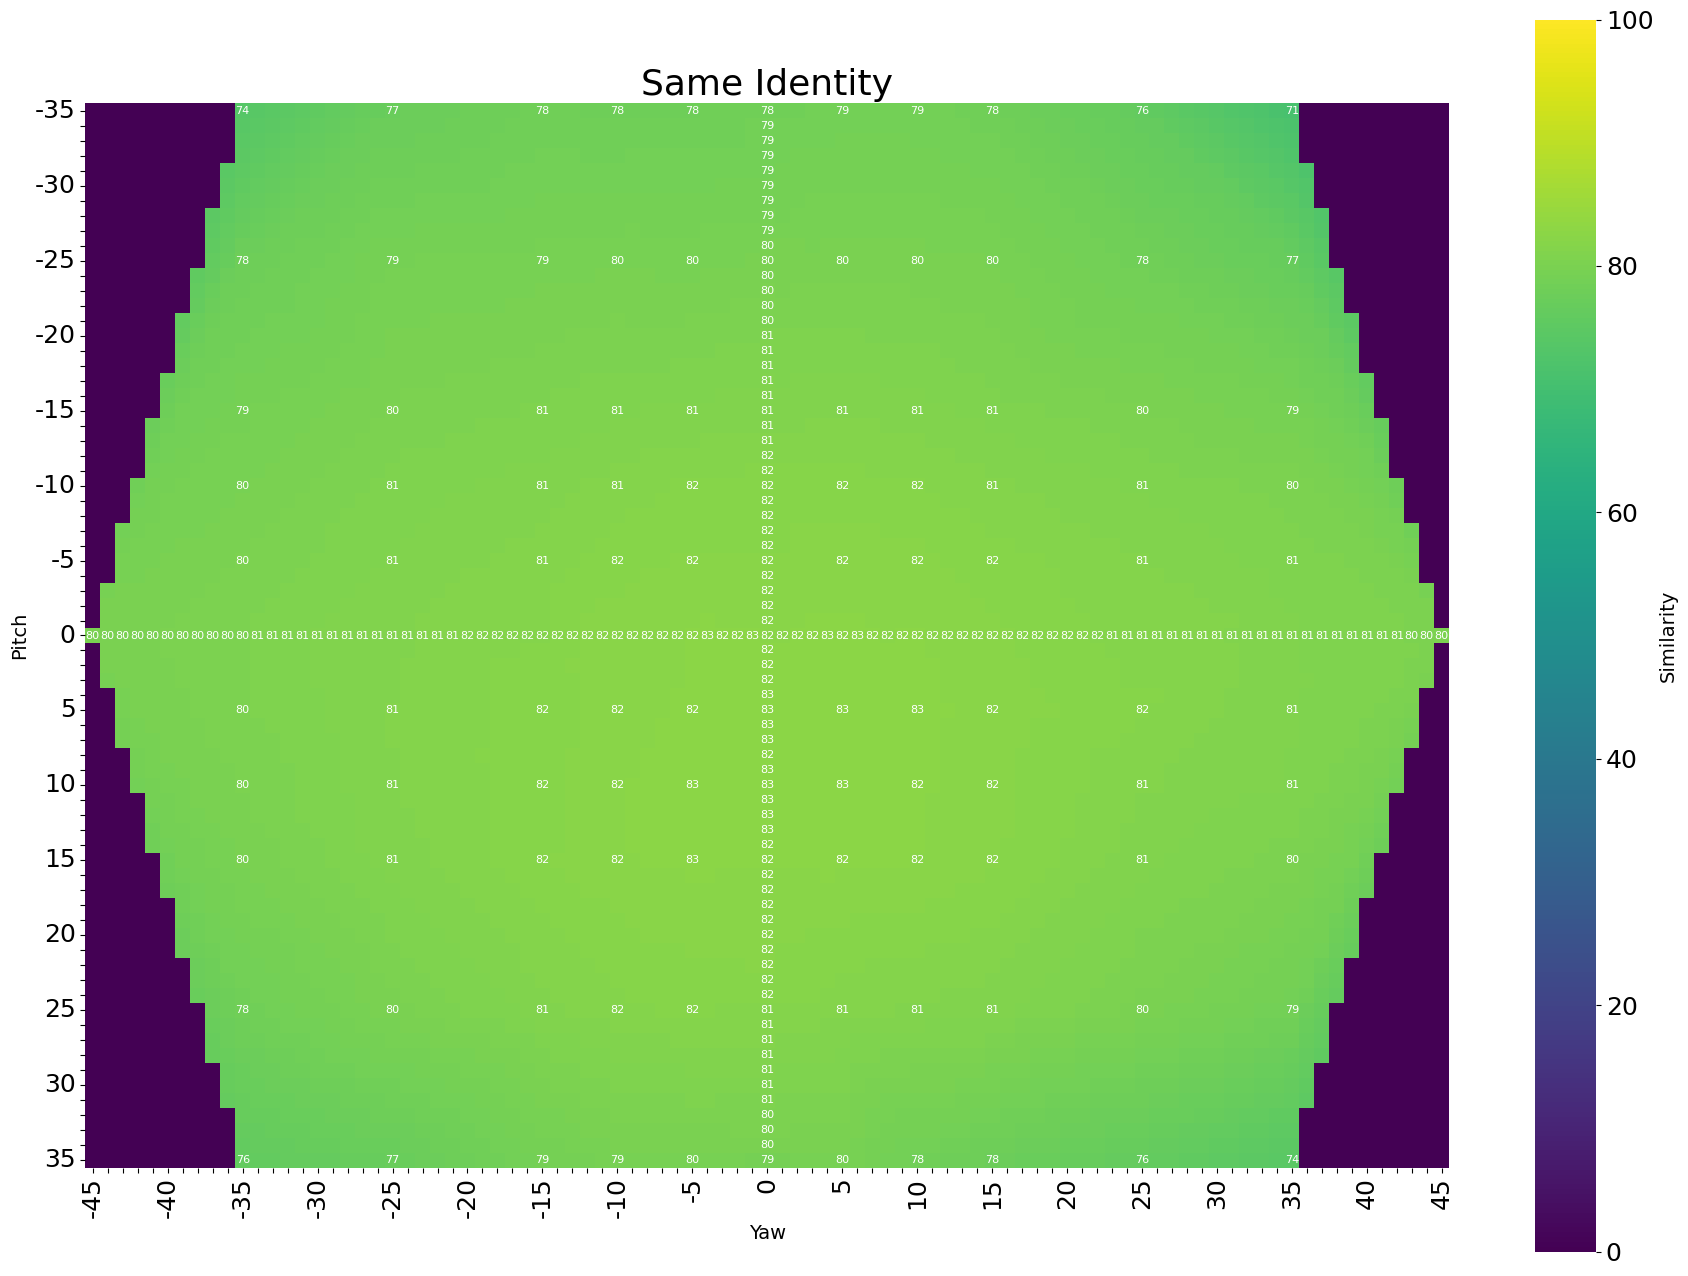

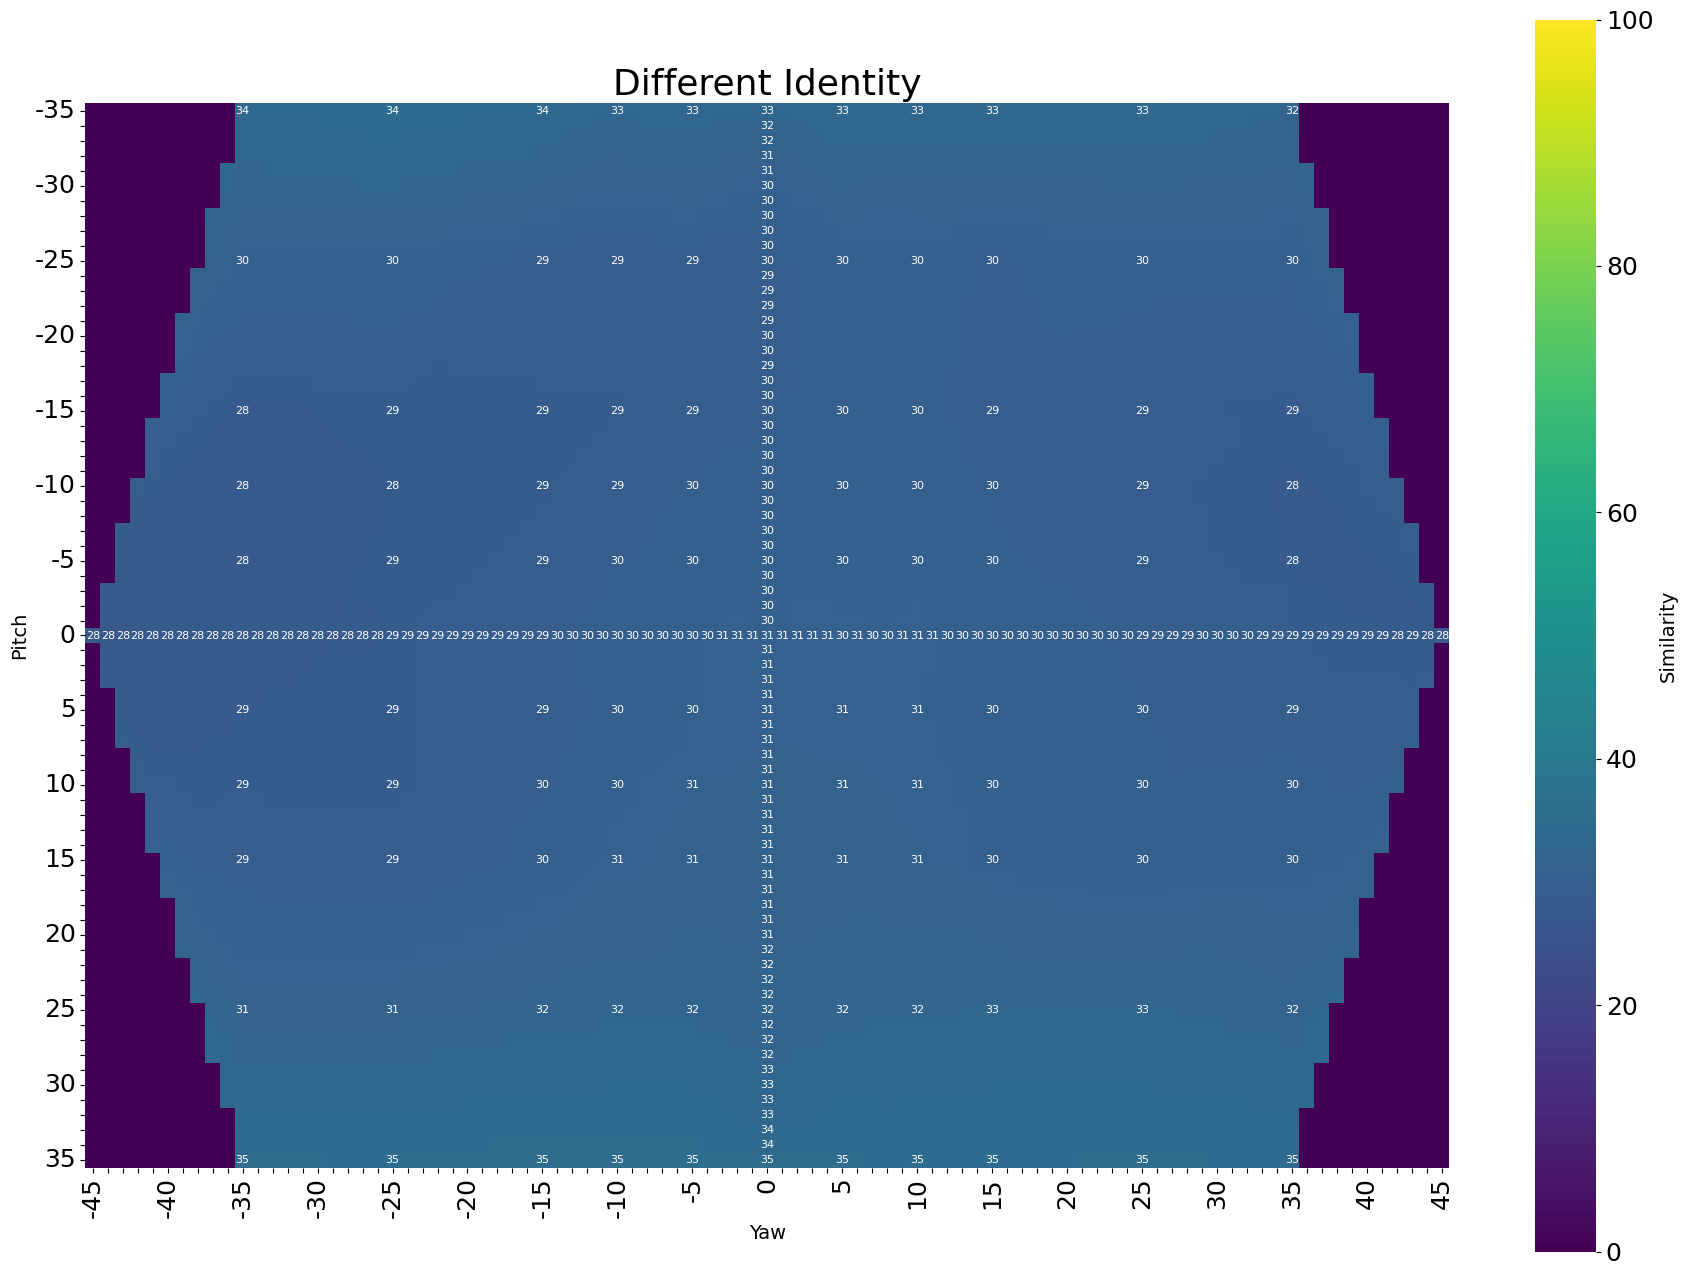

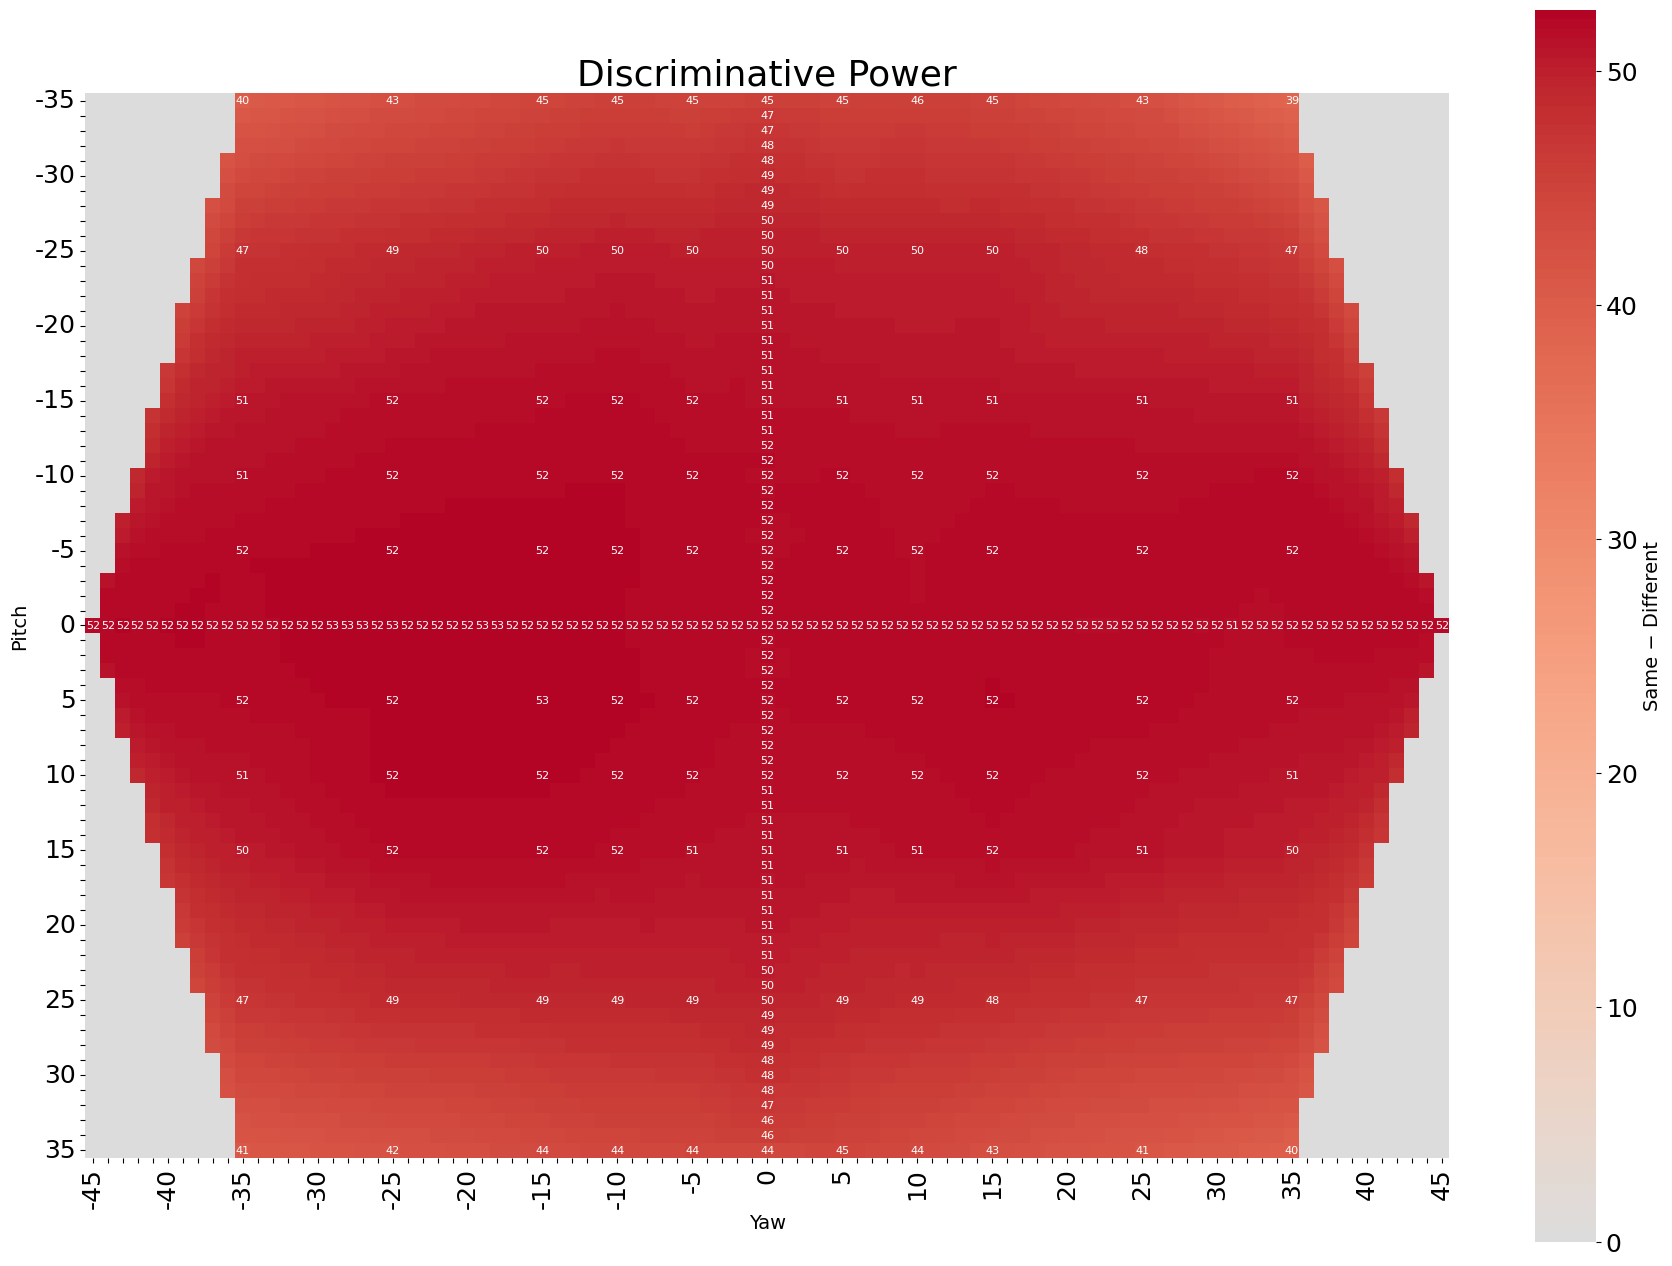

In [35]:
avg_same, avg_diff, difference, pitches, yaws = compute_average_heatmaps_pairwise(dataset, prefix="rgb_bff_crop261_emb-edgeface", visualize=True)

Compute distances: 100%|██████████| 19786/19786 [09:21<00:00, 35.26it/s]


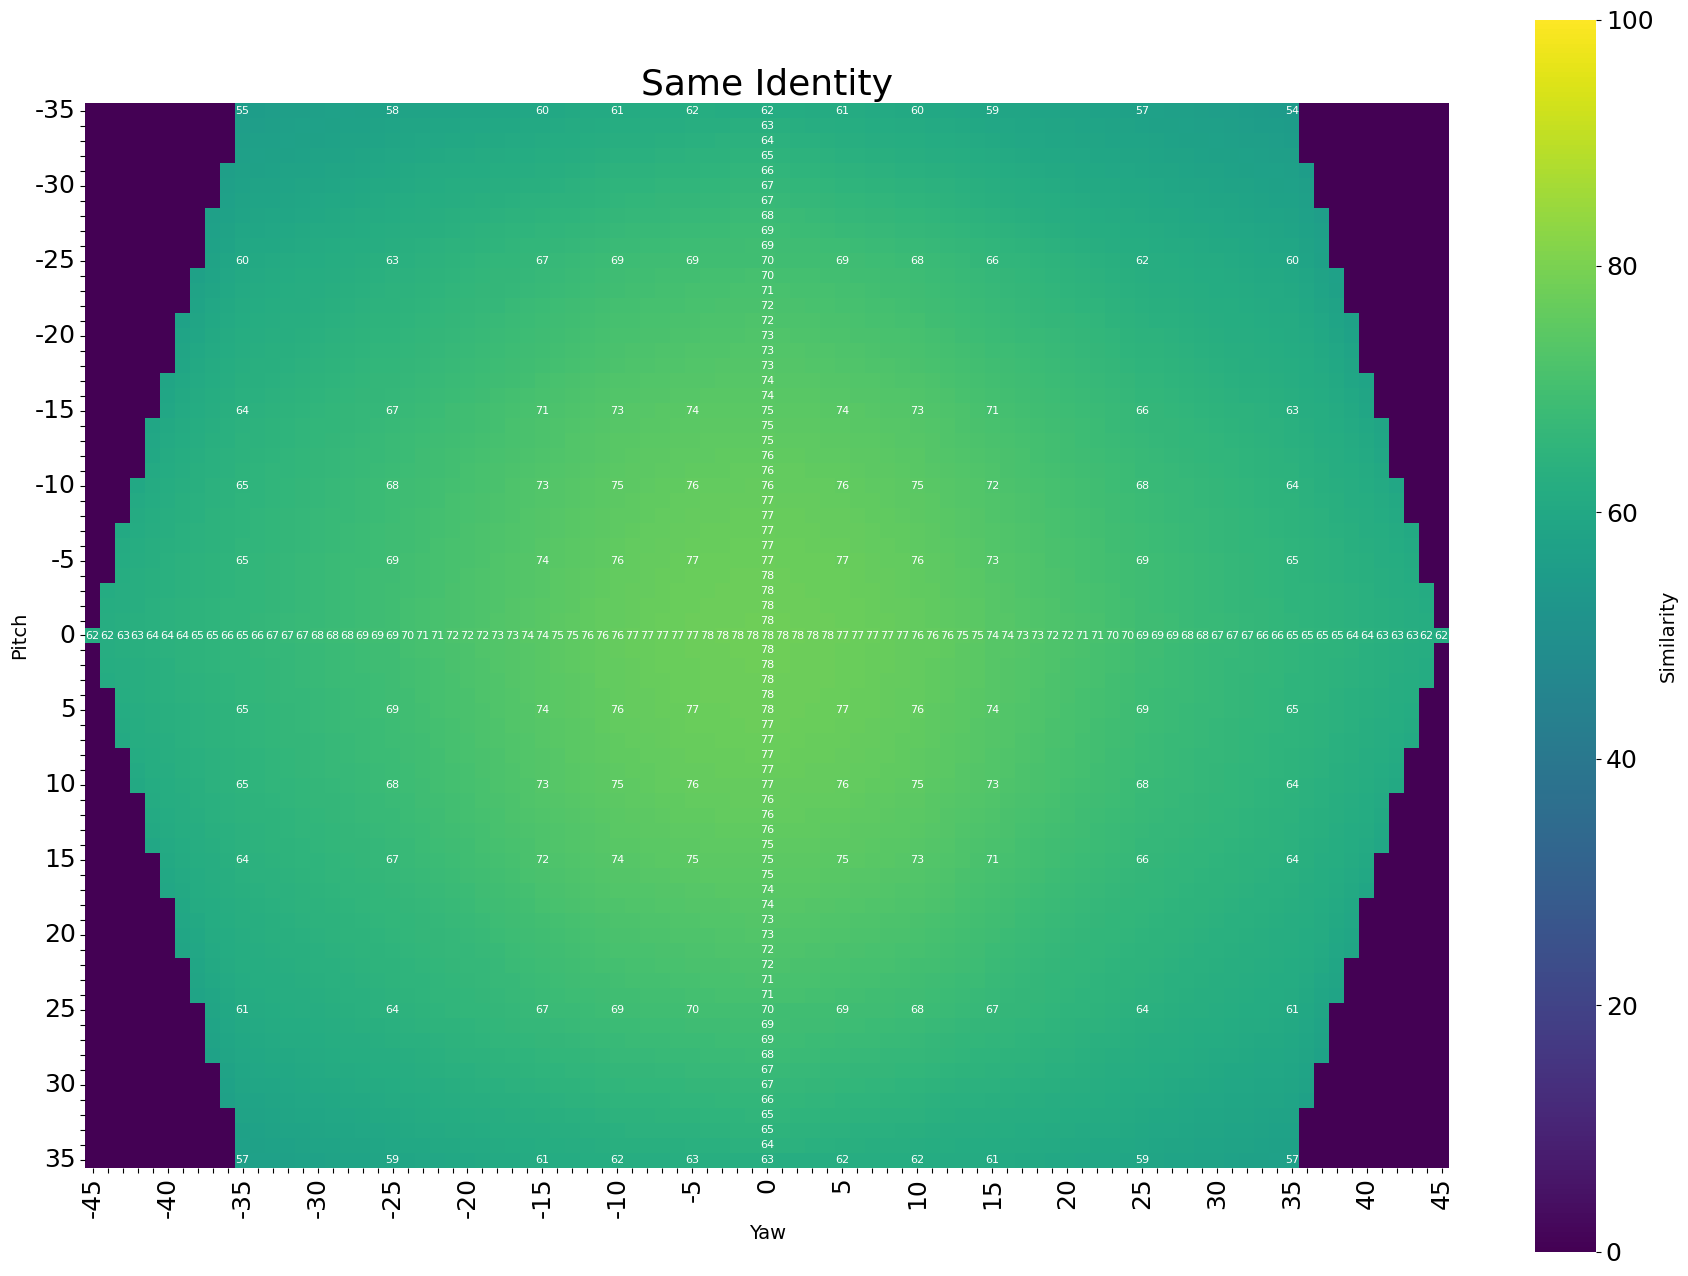

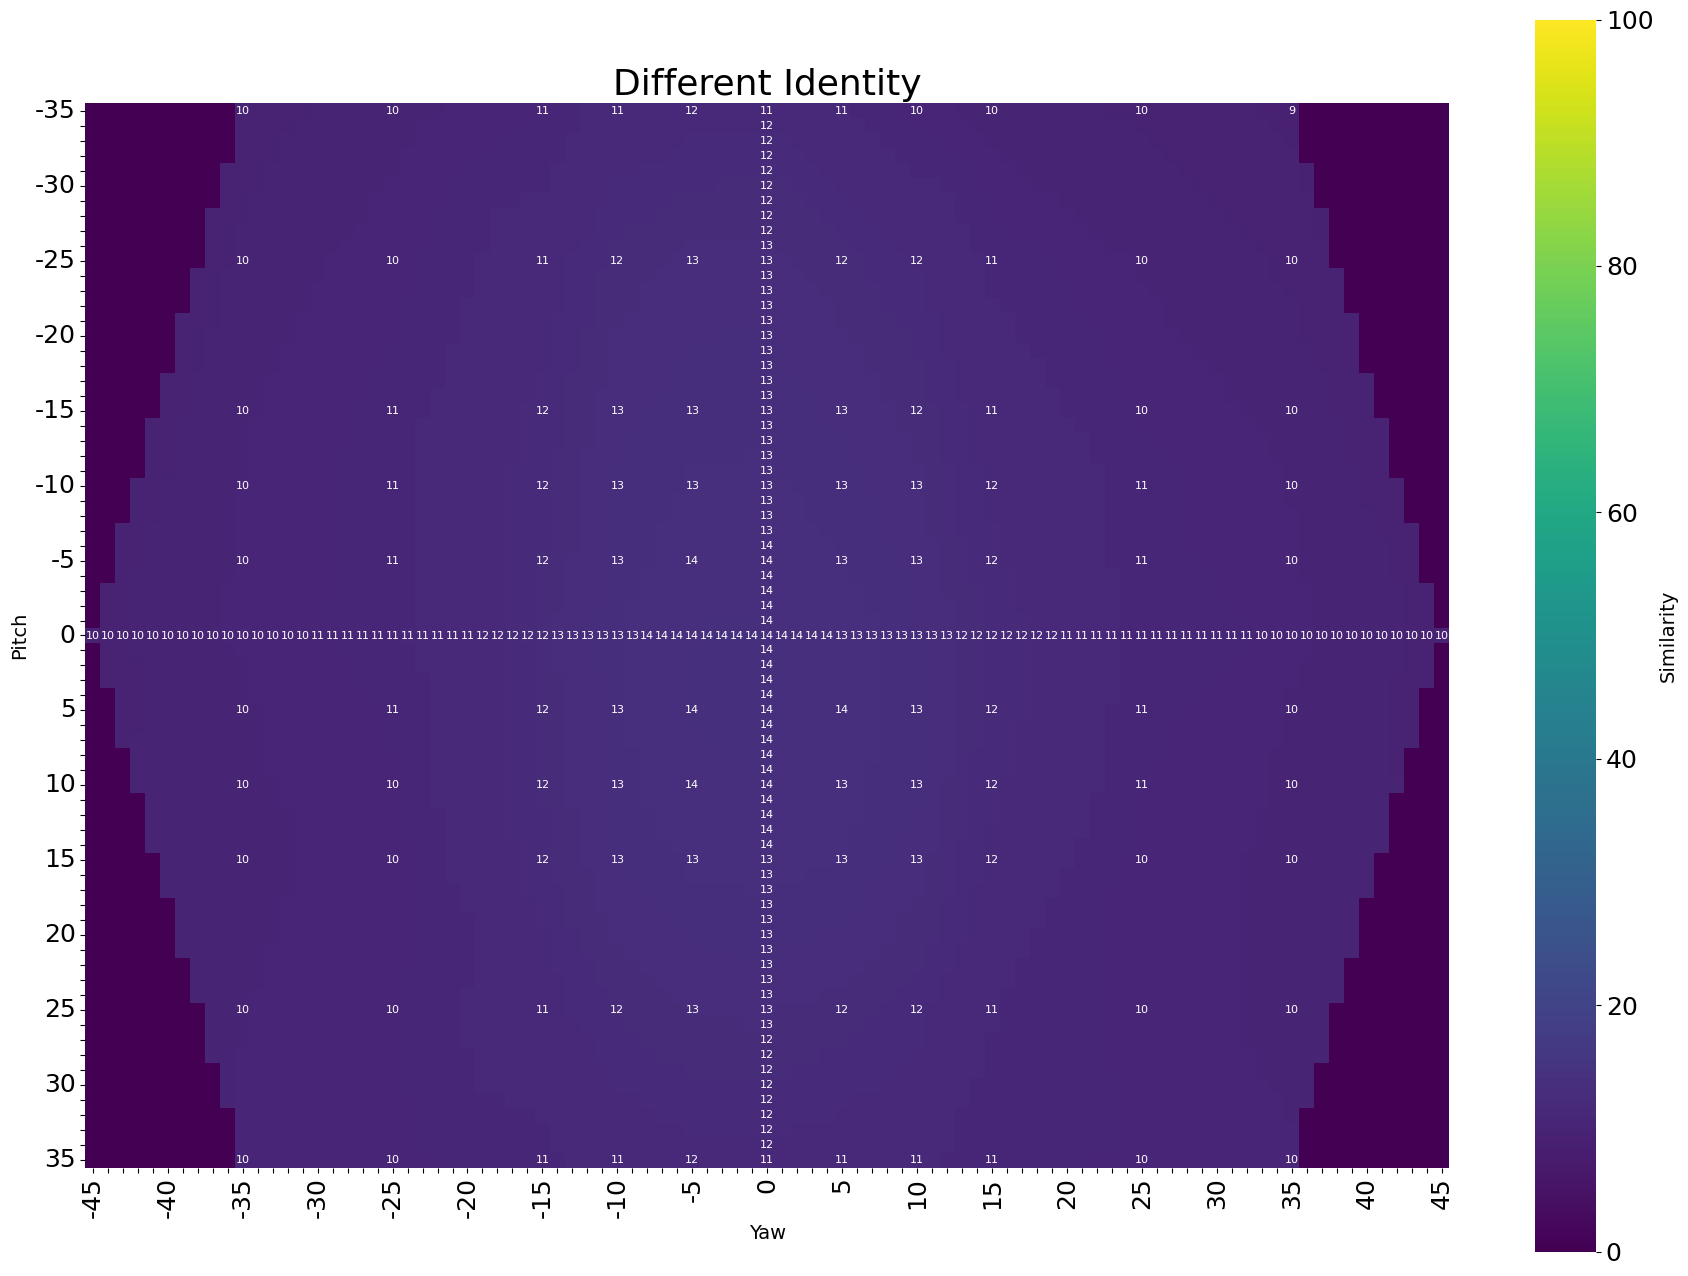

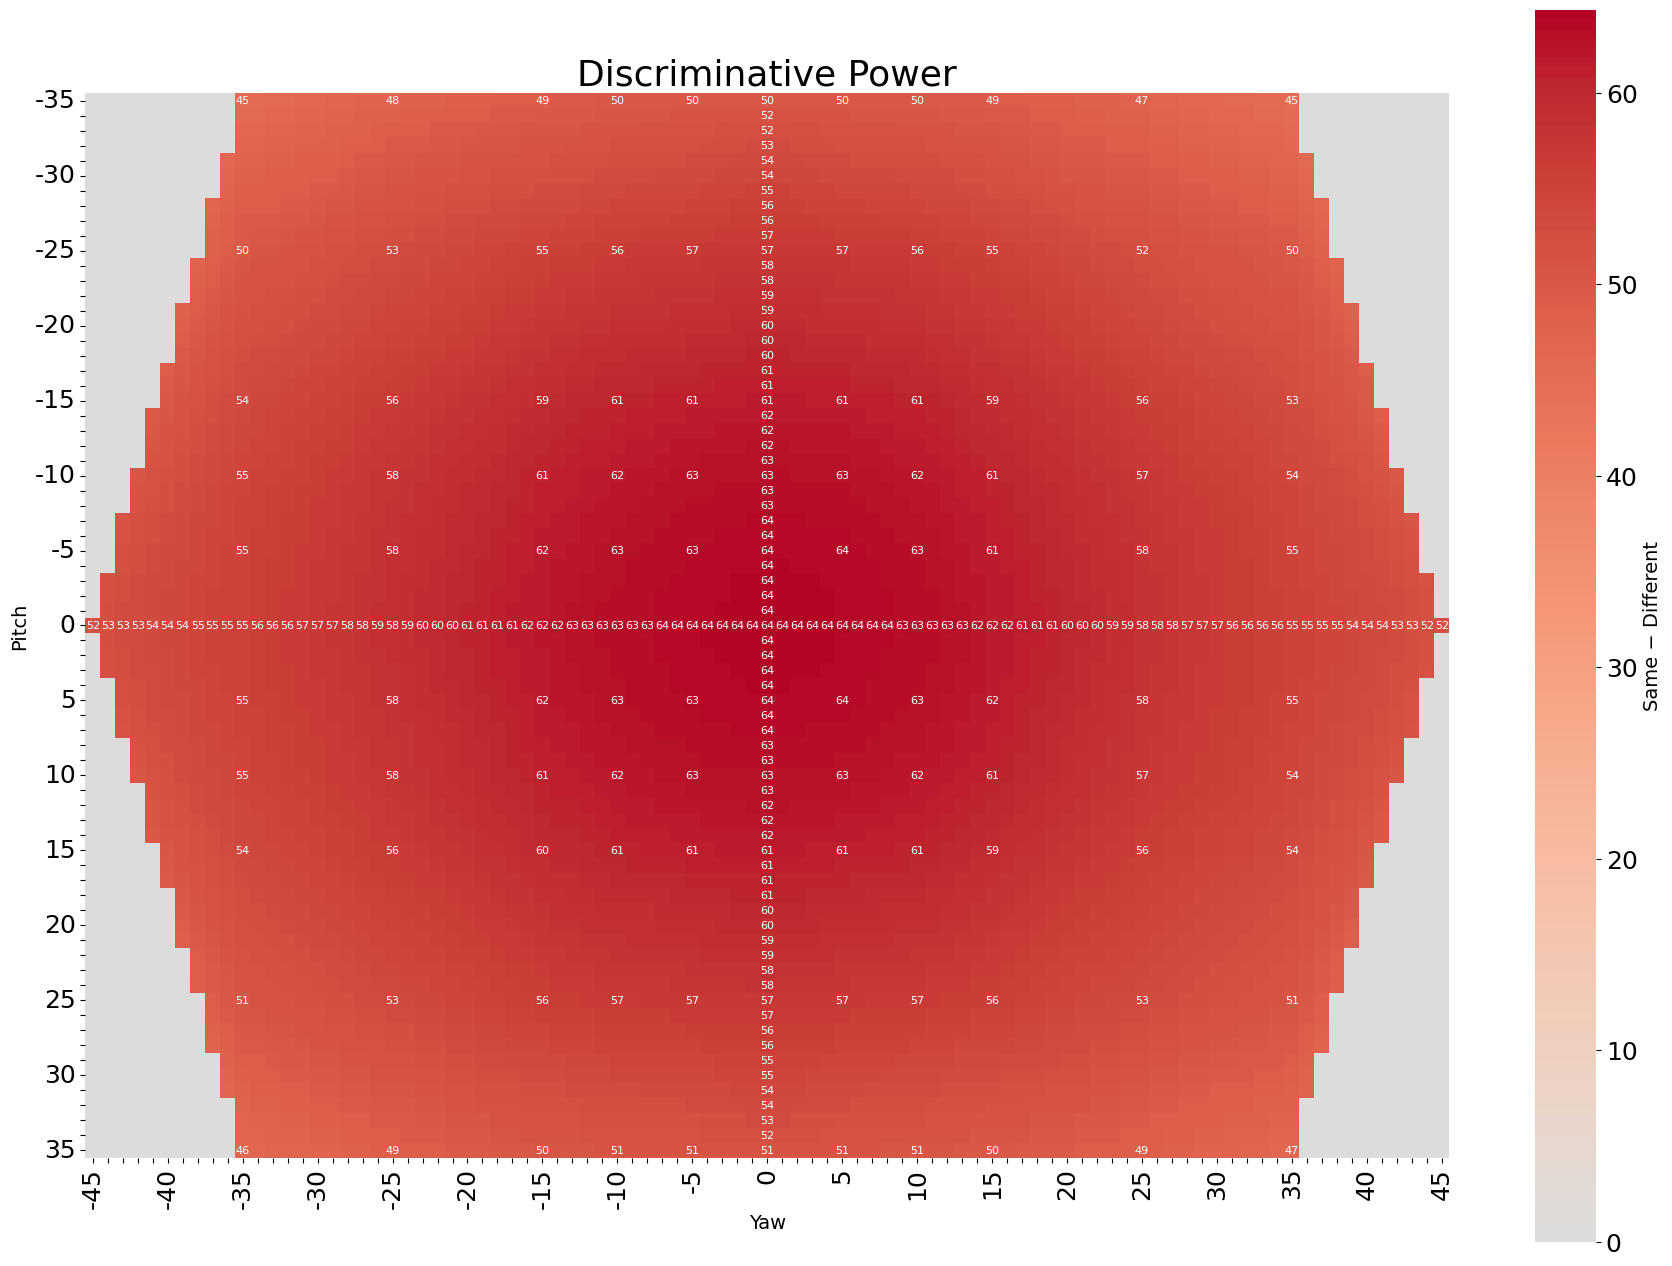

Compute distances: 100%|██████████| 19786/19786 [14:16<00:00, 23.10it/s]


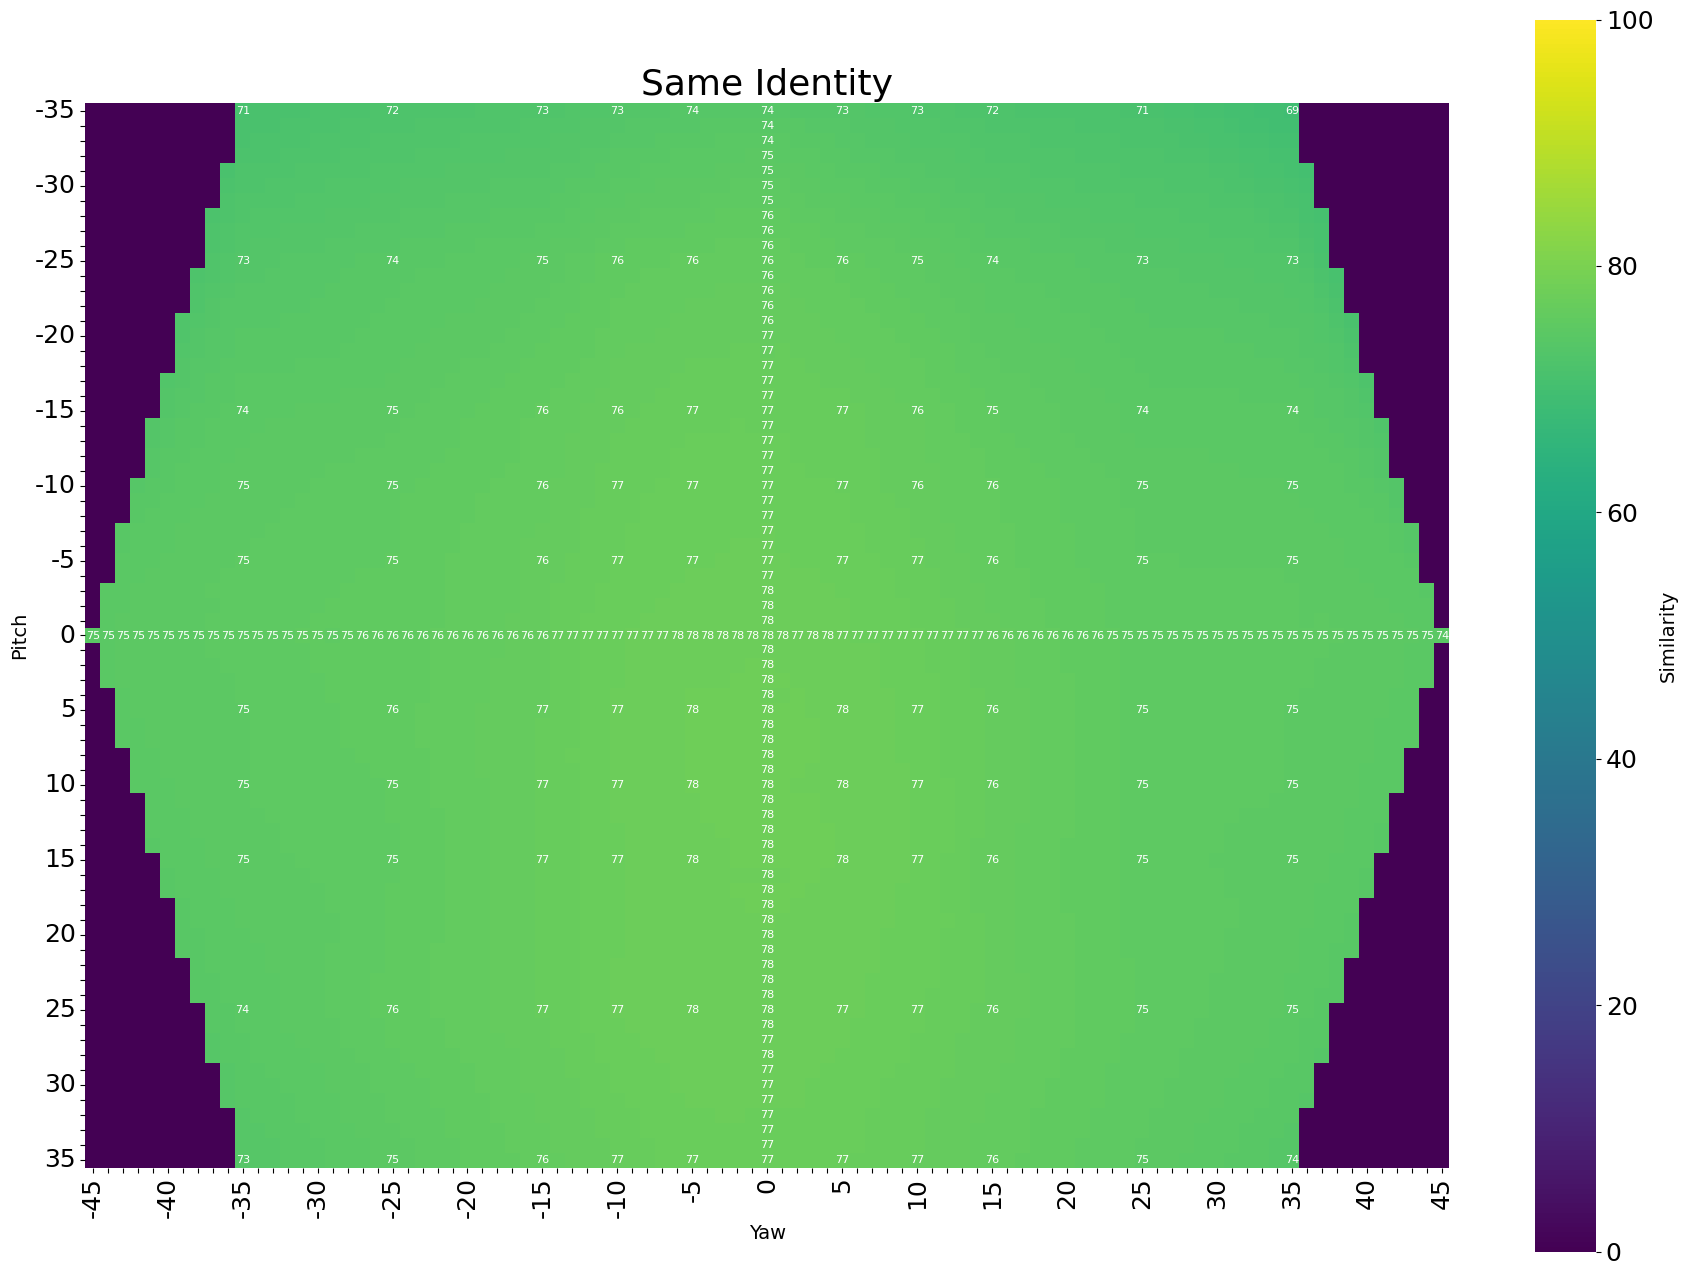

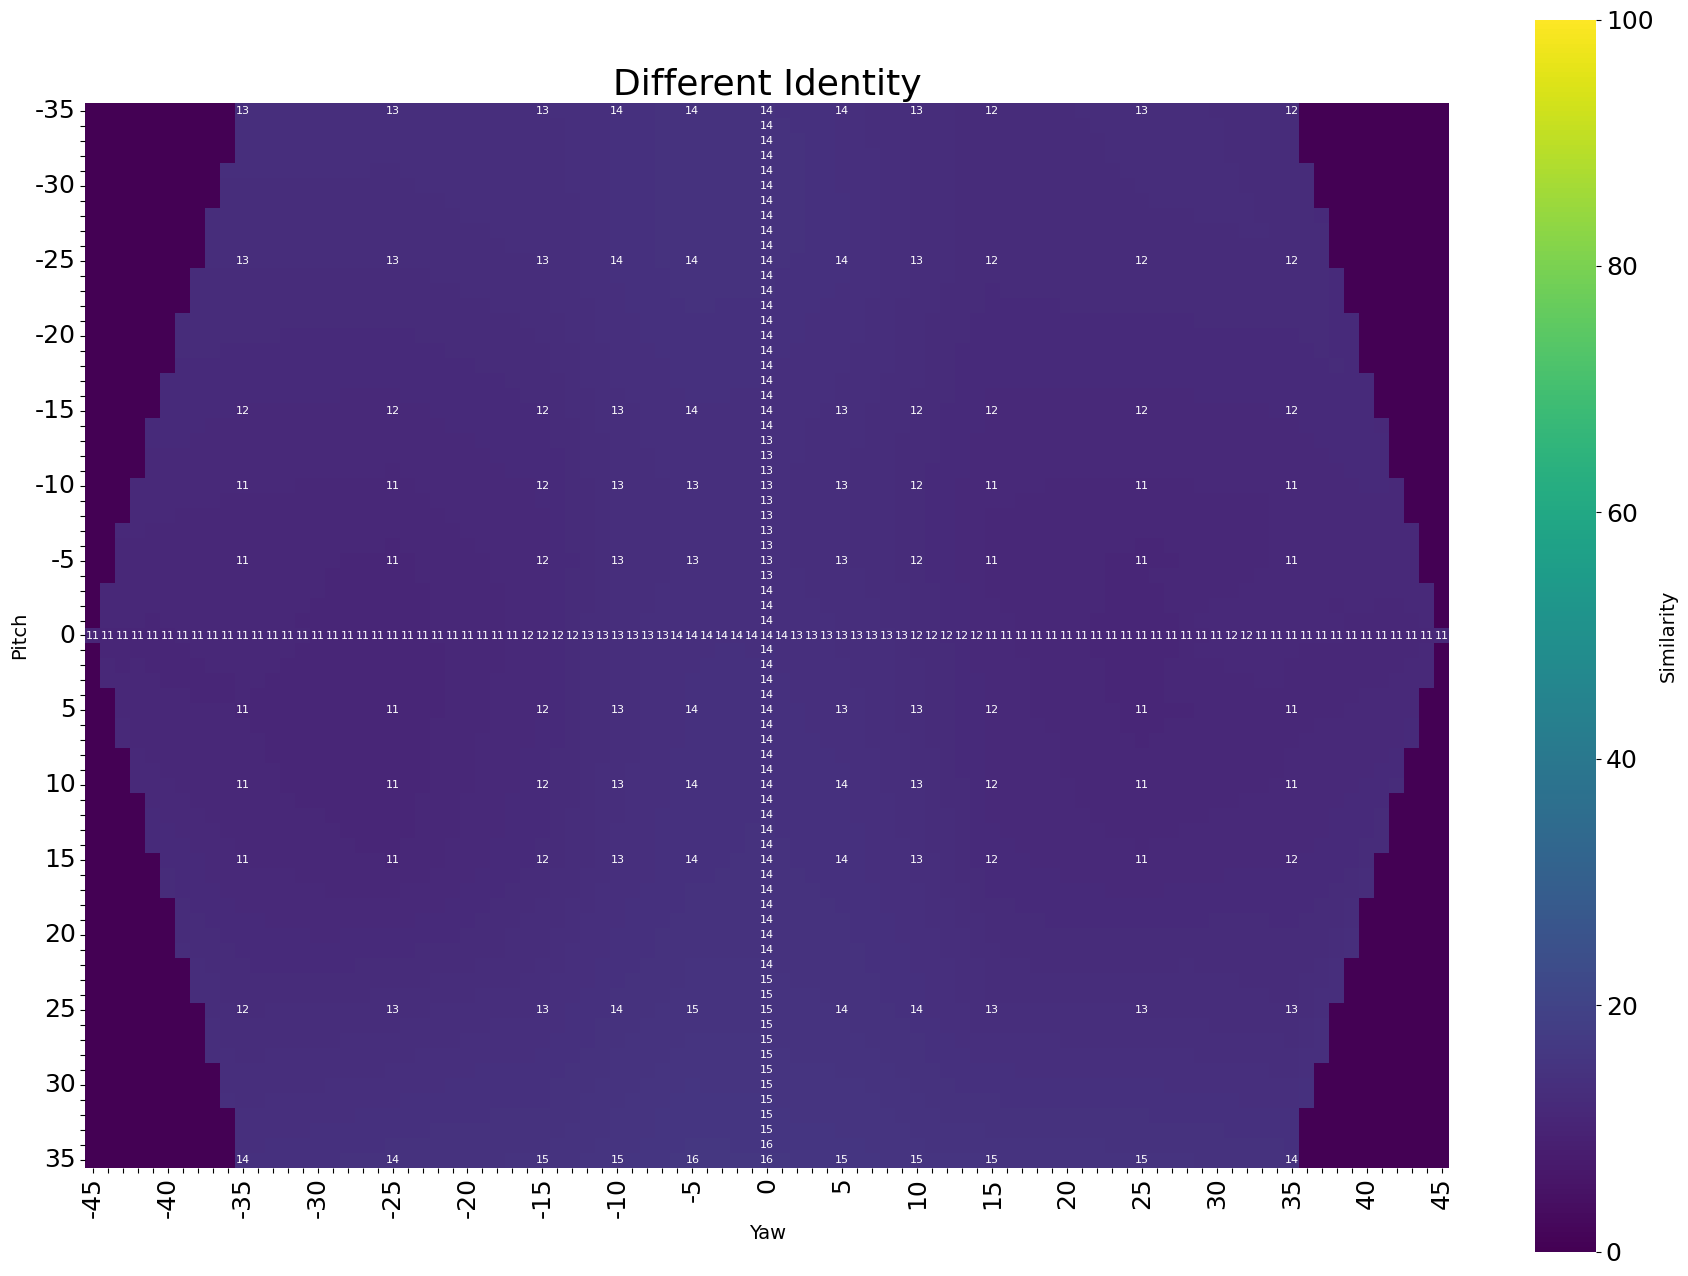

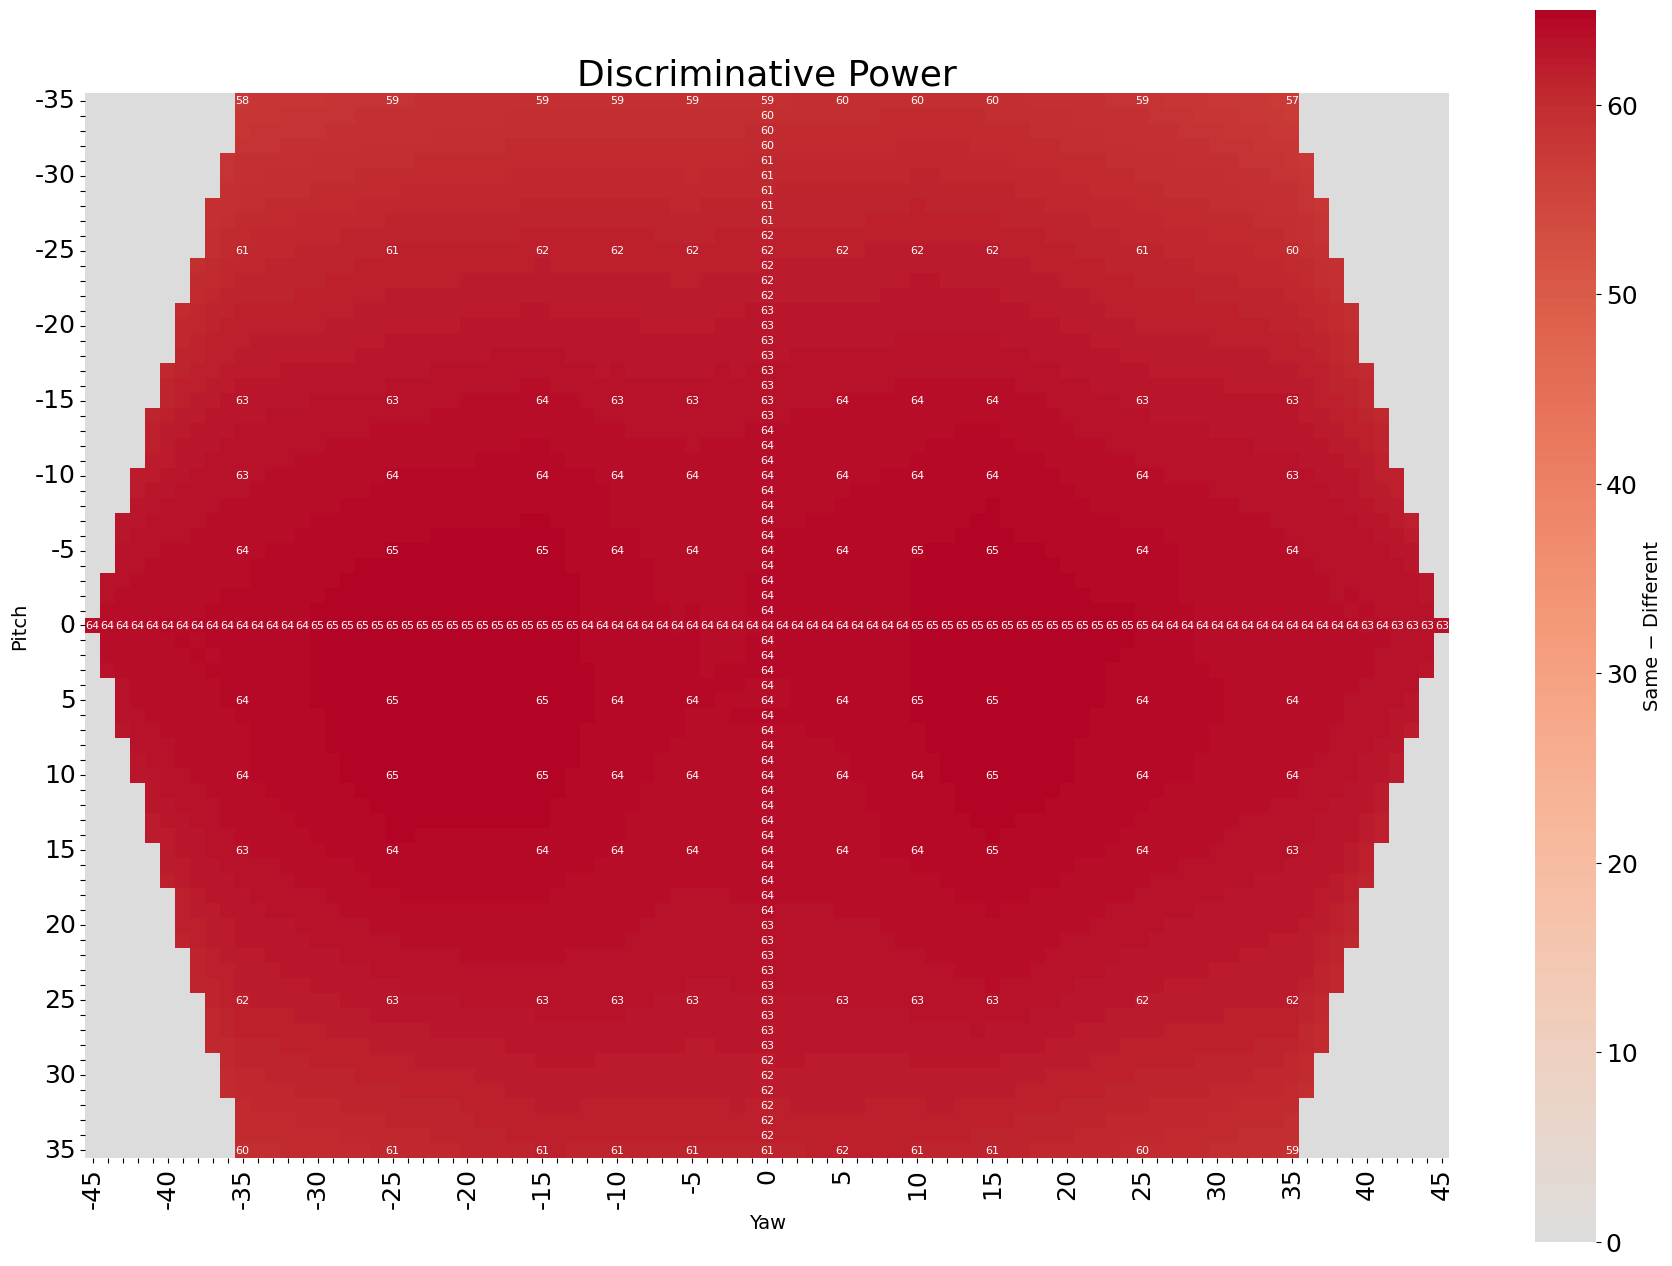

In [36]:
name="rgb_bff_crop261_emb-irseadafacer100"
dataset = EmbeddingDataset(r"F:/Face/data/dataset15_emb/"+name, disable_tqdm=False)
avg_same, avg_diff, pitches, yaws = compute_average_heatmaps(dataset, center_pose=(0, 0), prefix=name, visualize=True)
avg_same, avg_diff, differences, pitches, yaws = compute_average_heatmaps_pairwise(dataset, prefix=name, visualize=True)

Compute distances: 100%|██████████| 19786/19786 [08:55<00:00, 36.97it/s]


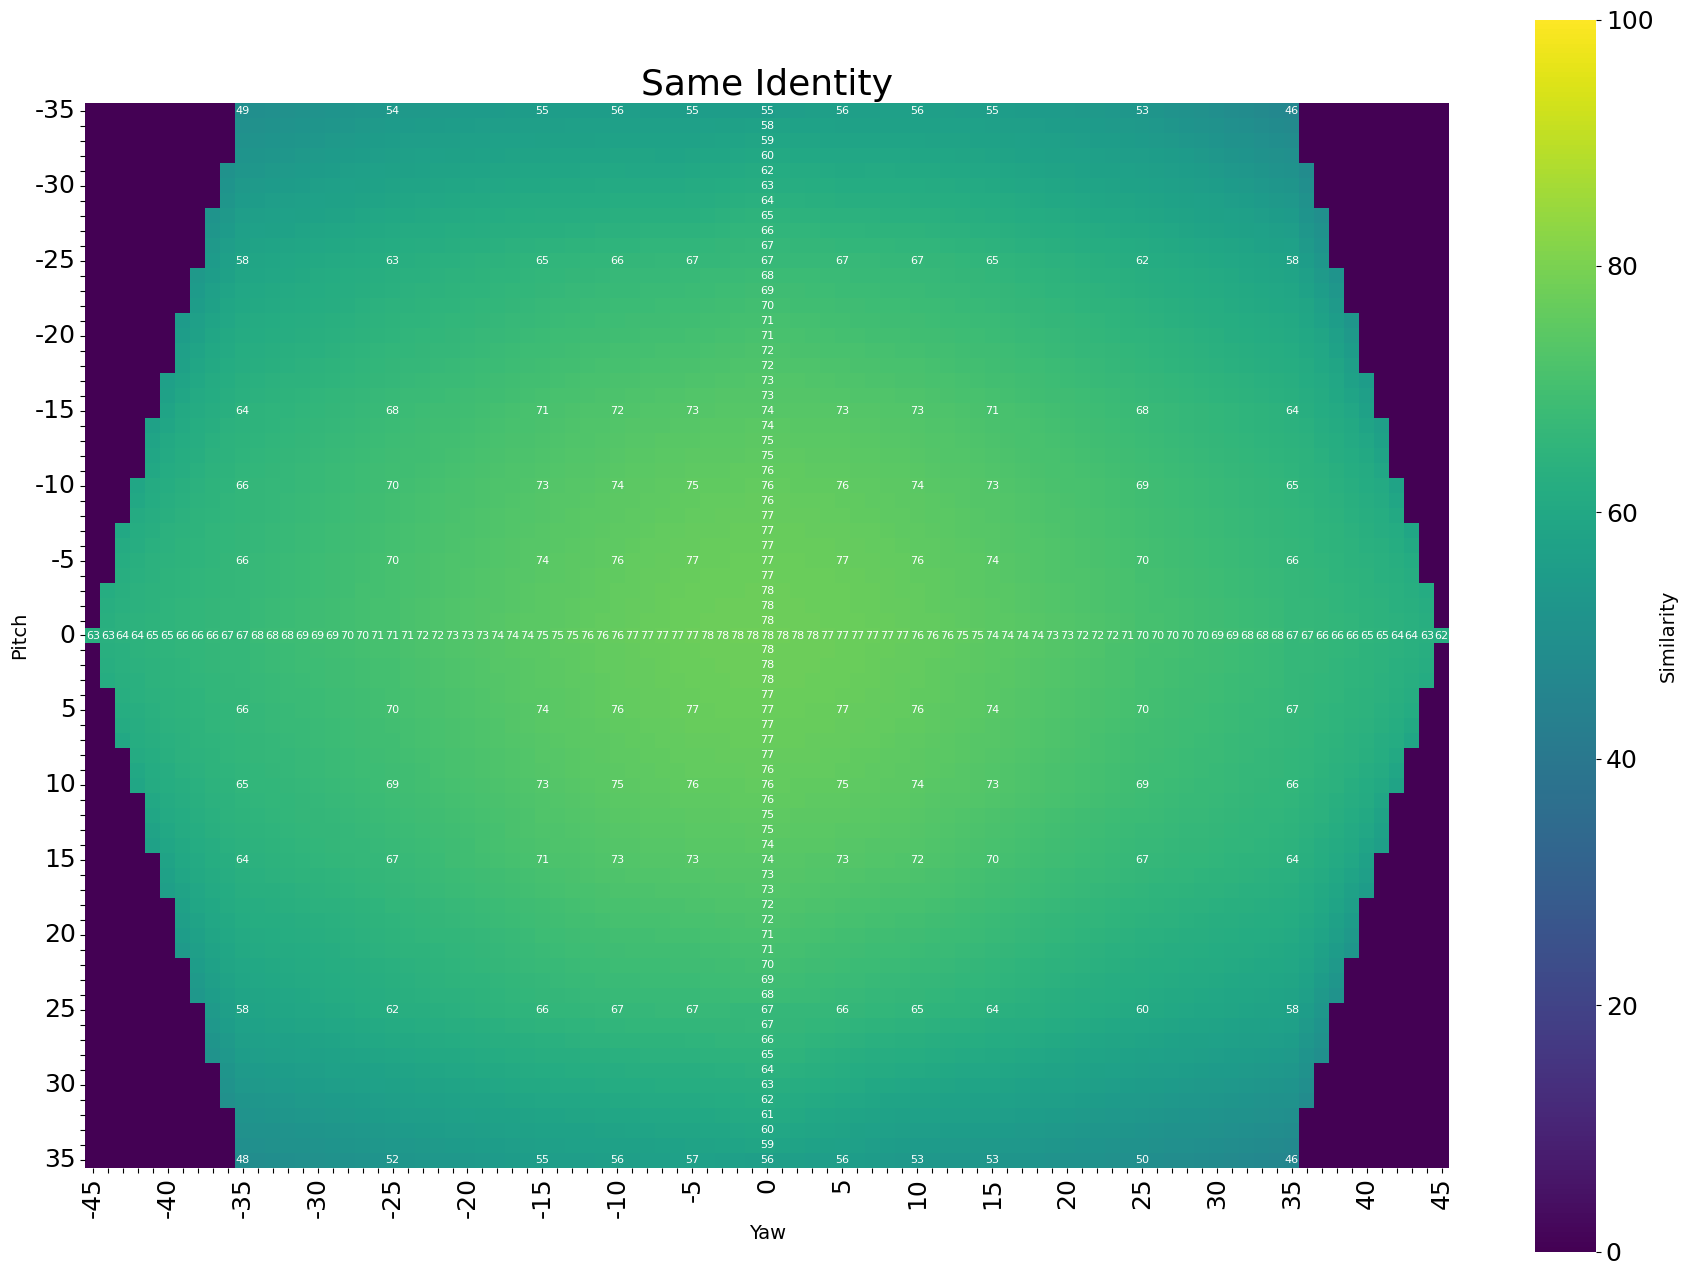

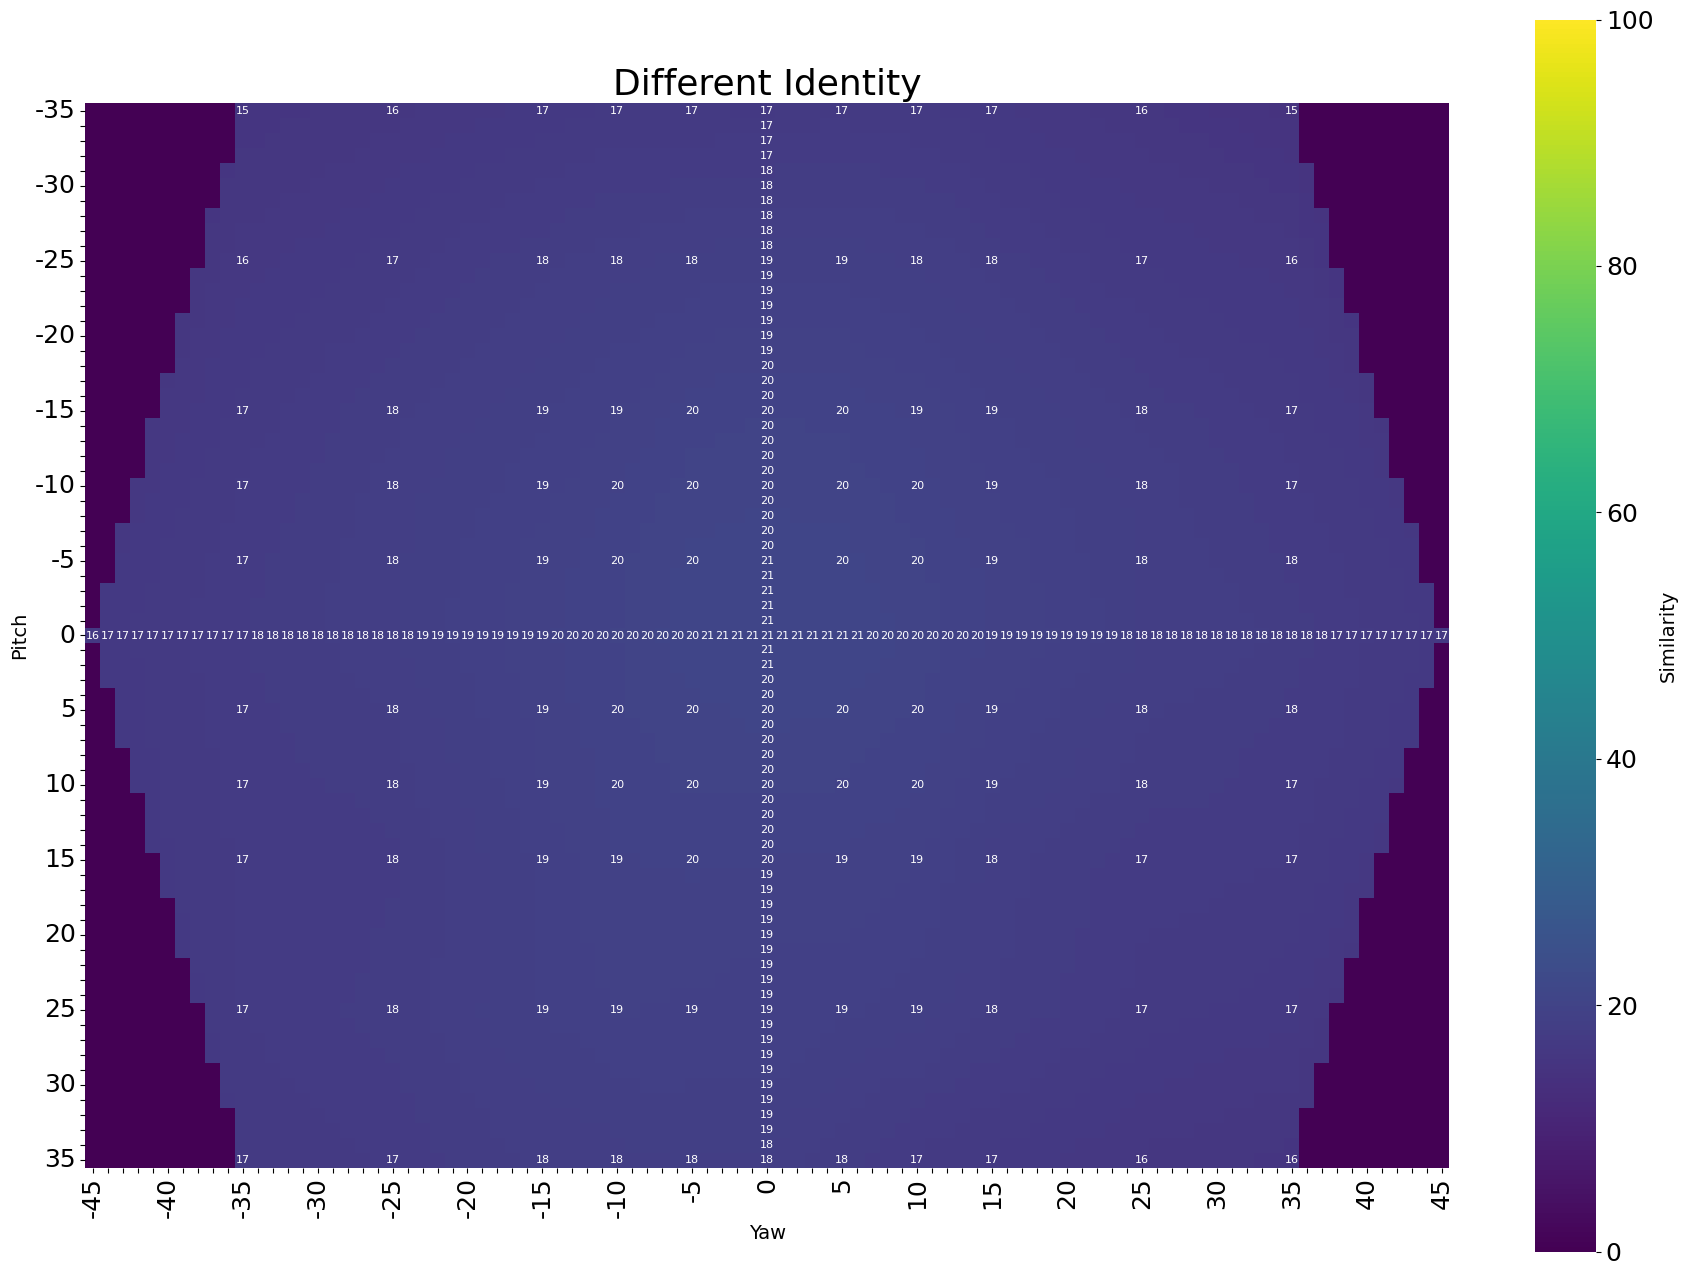

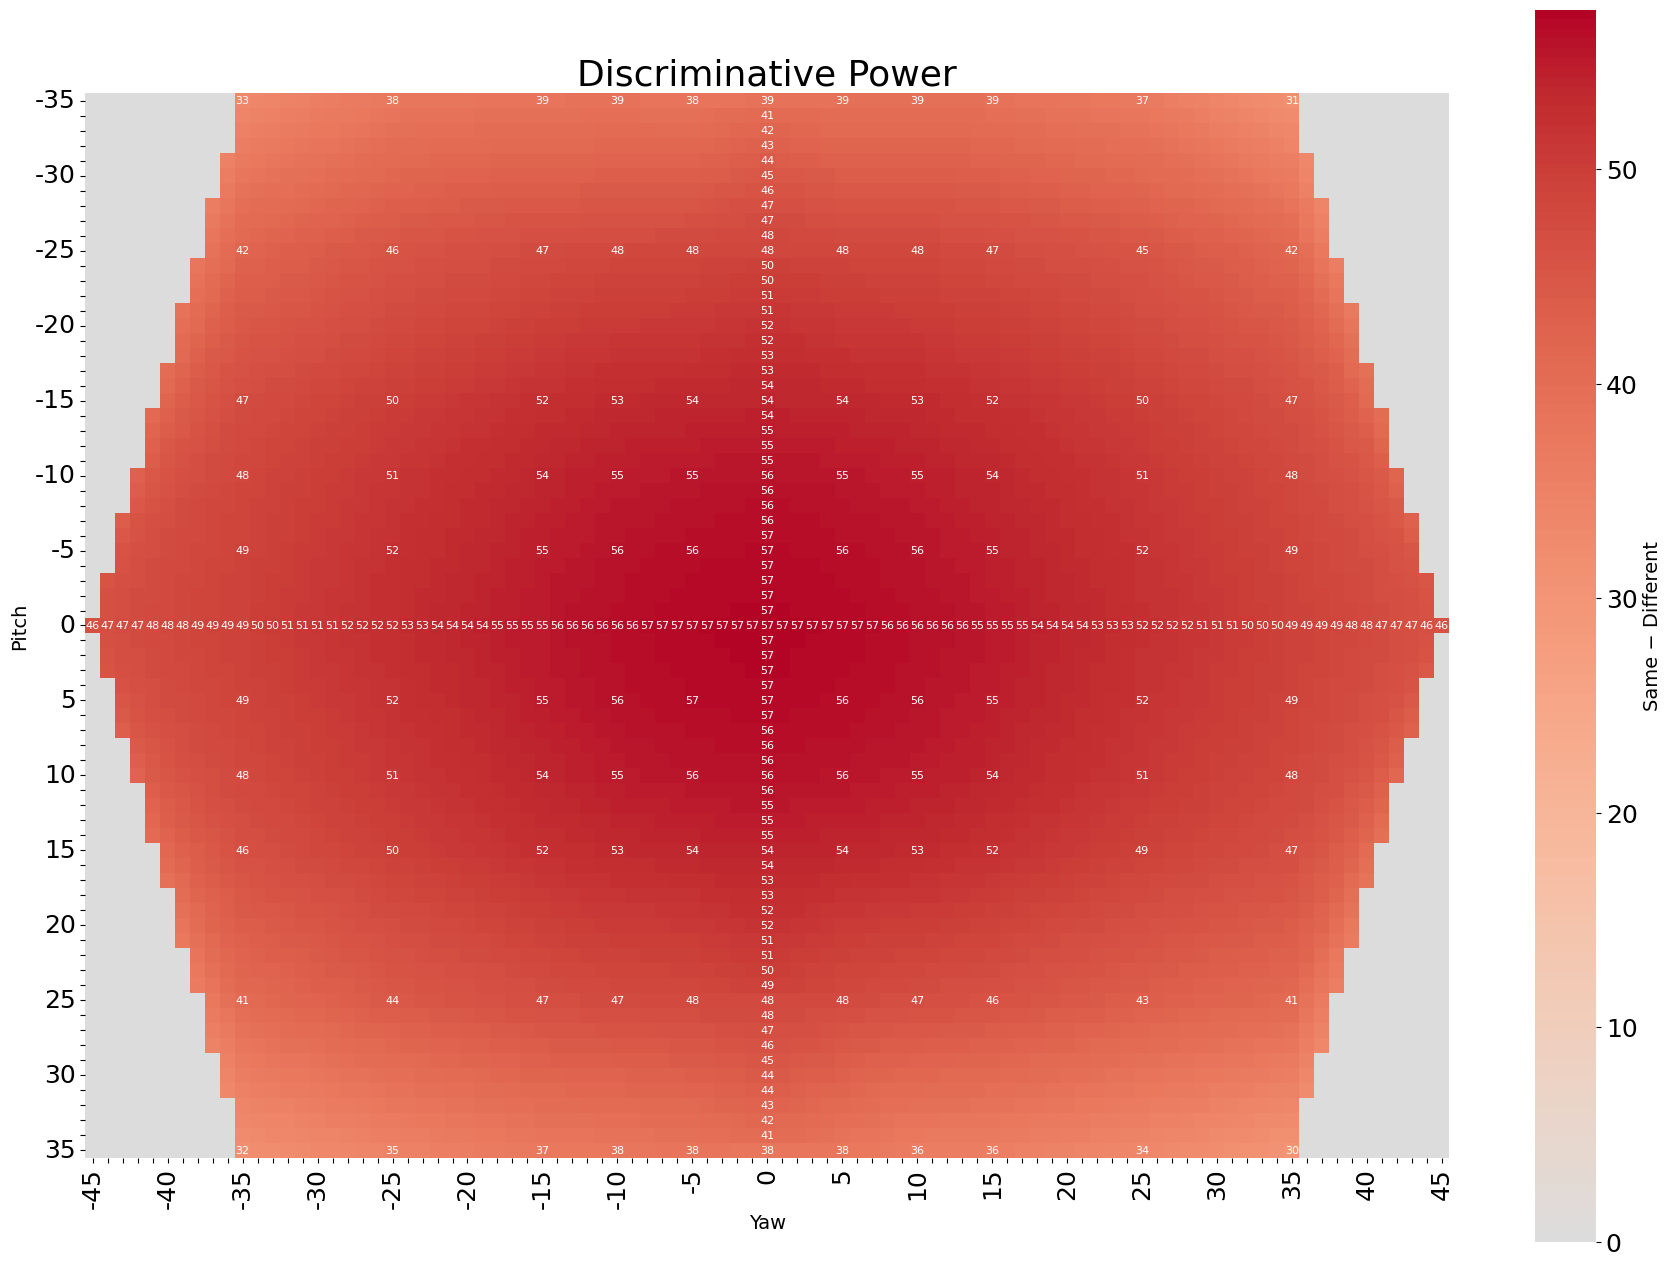

Compute distances: 100%|██████████| 19786/19786 [13:55<00:00, 23.67it/s]


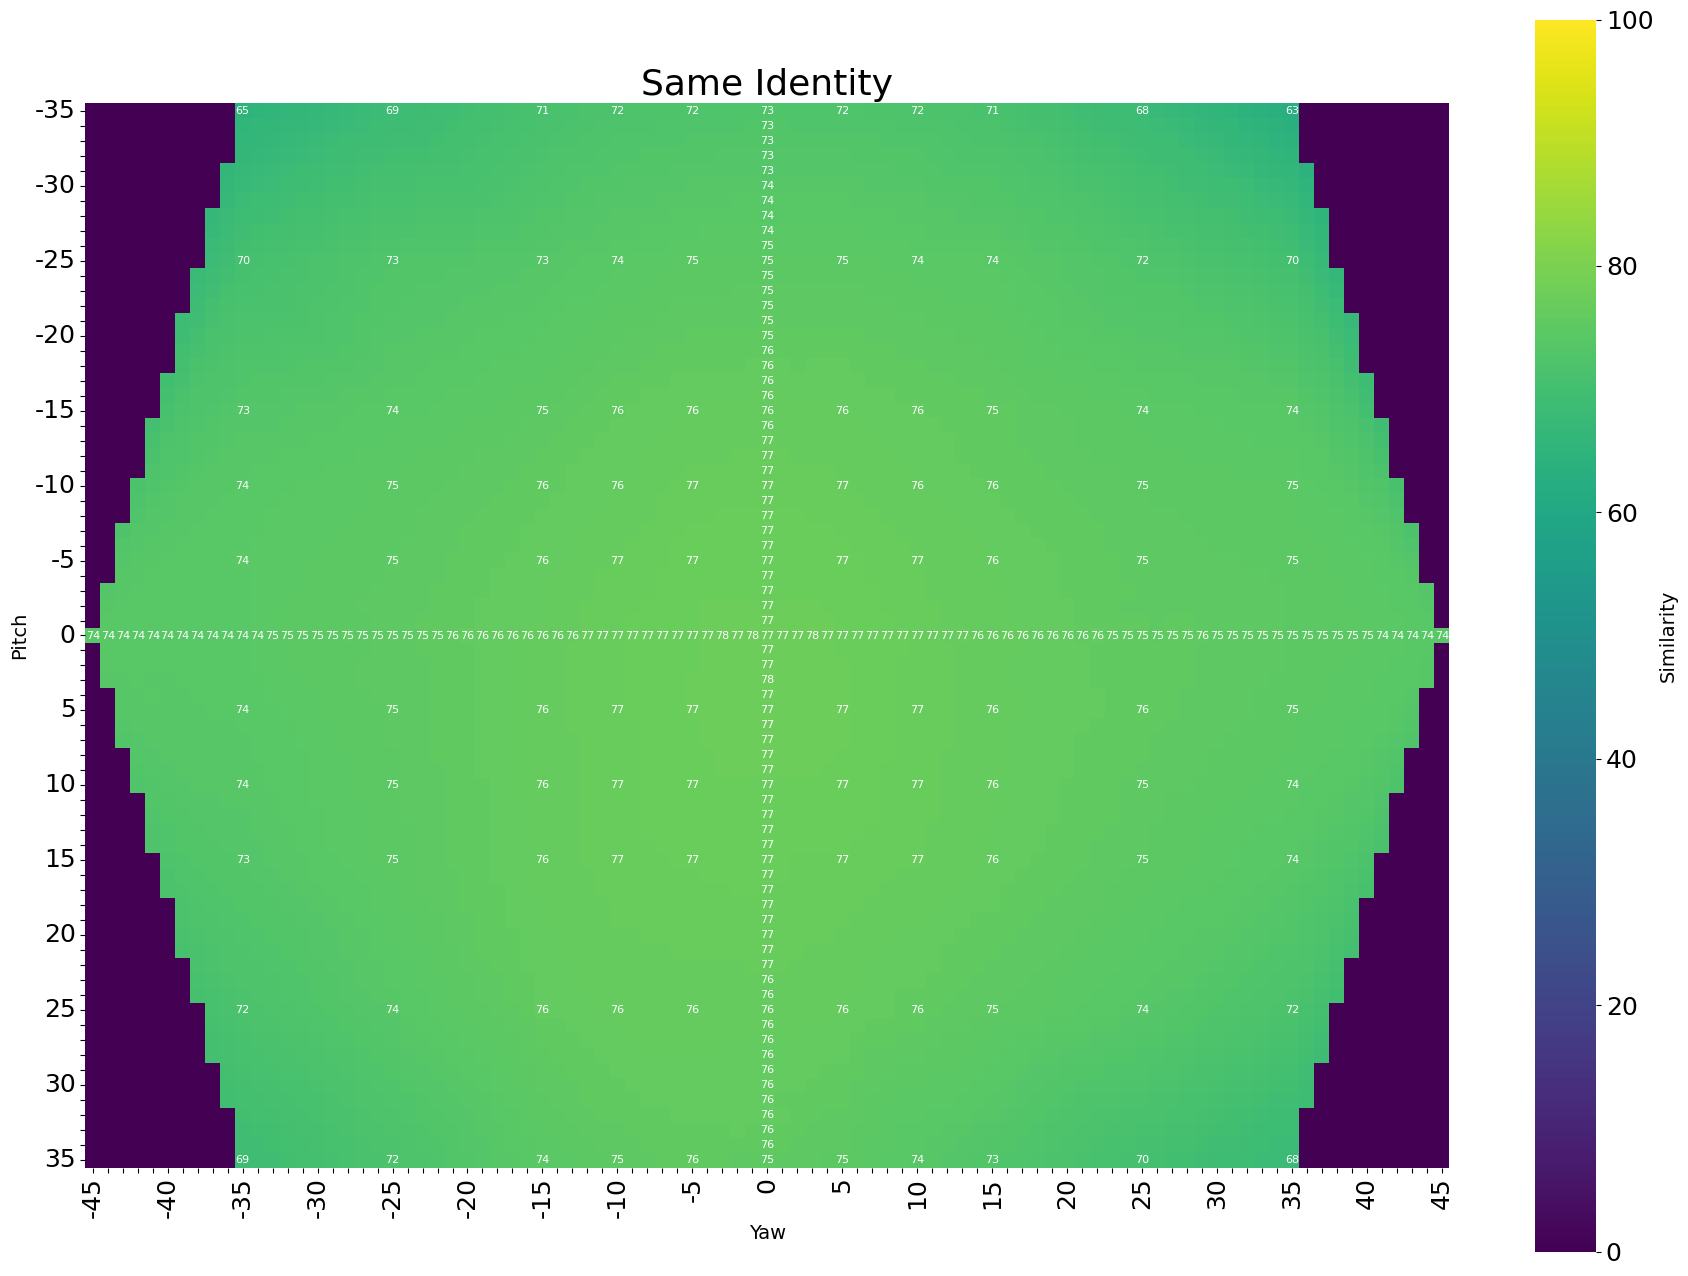

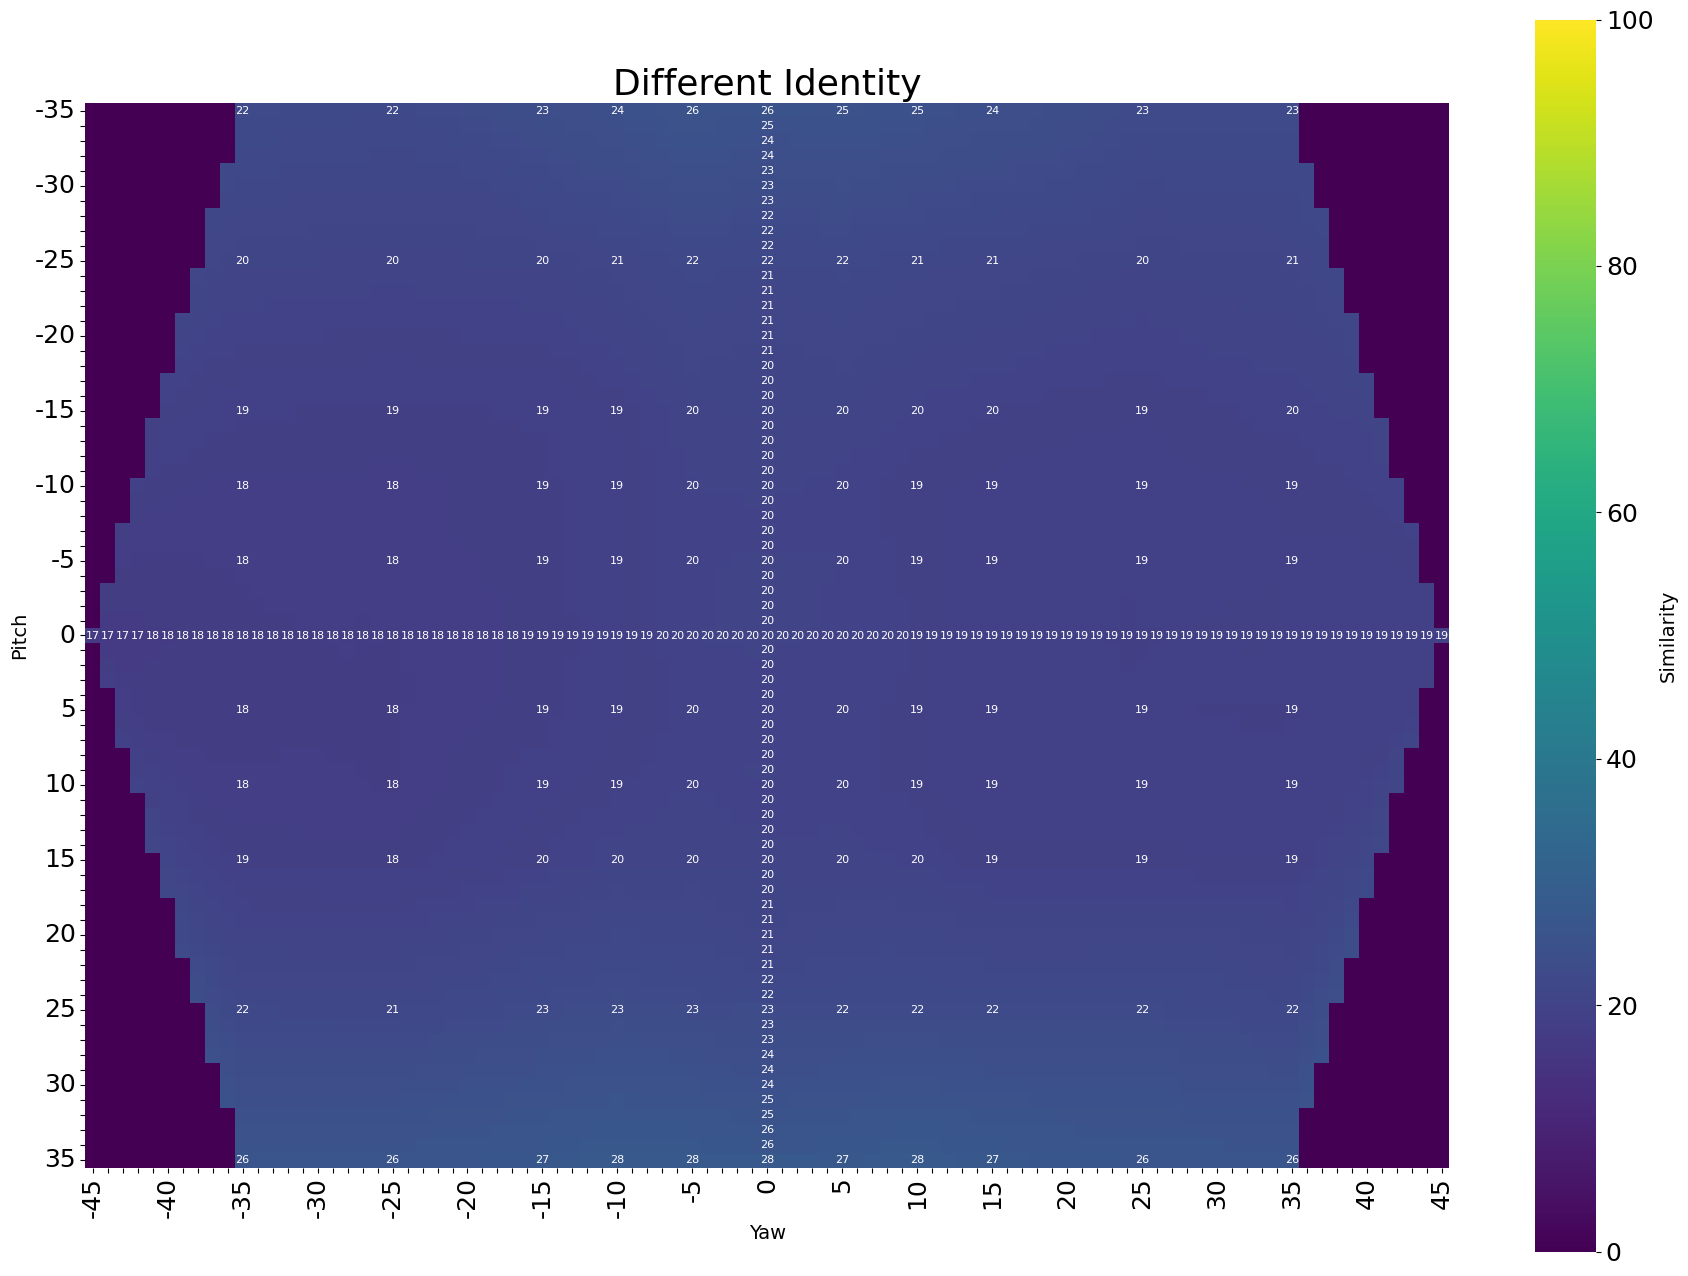

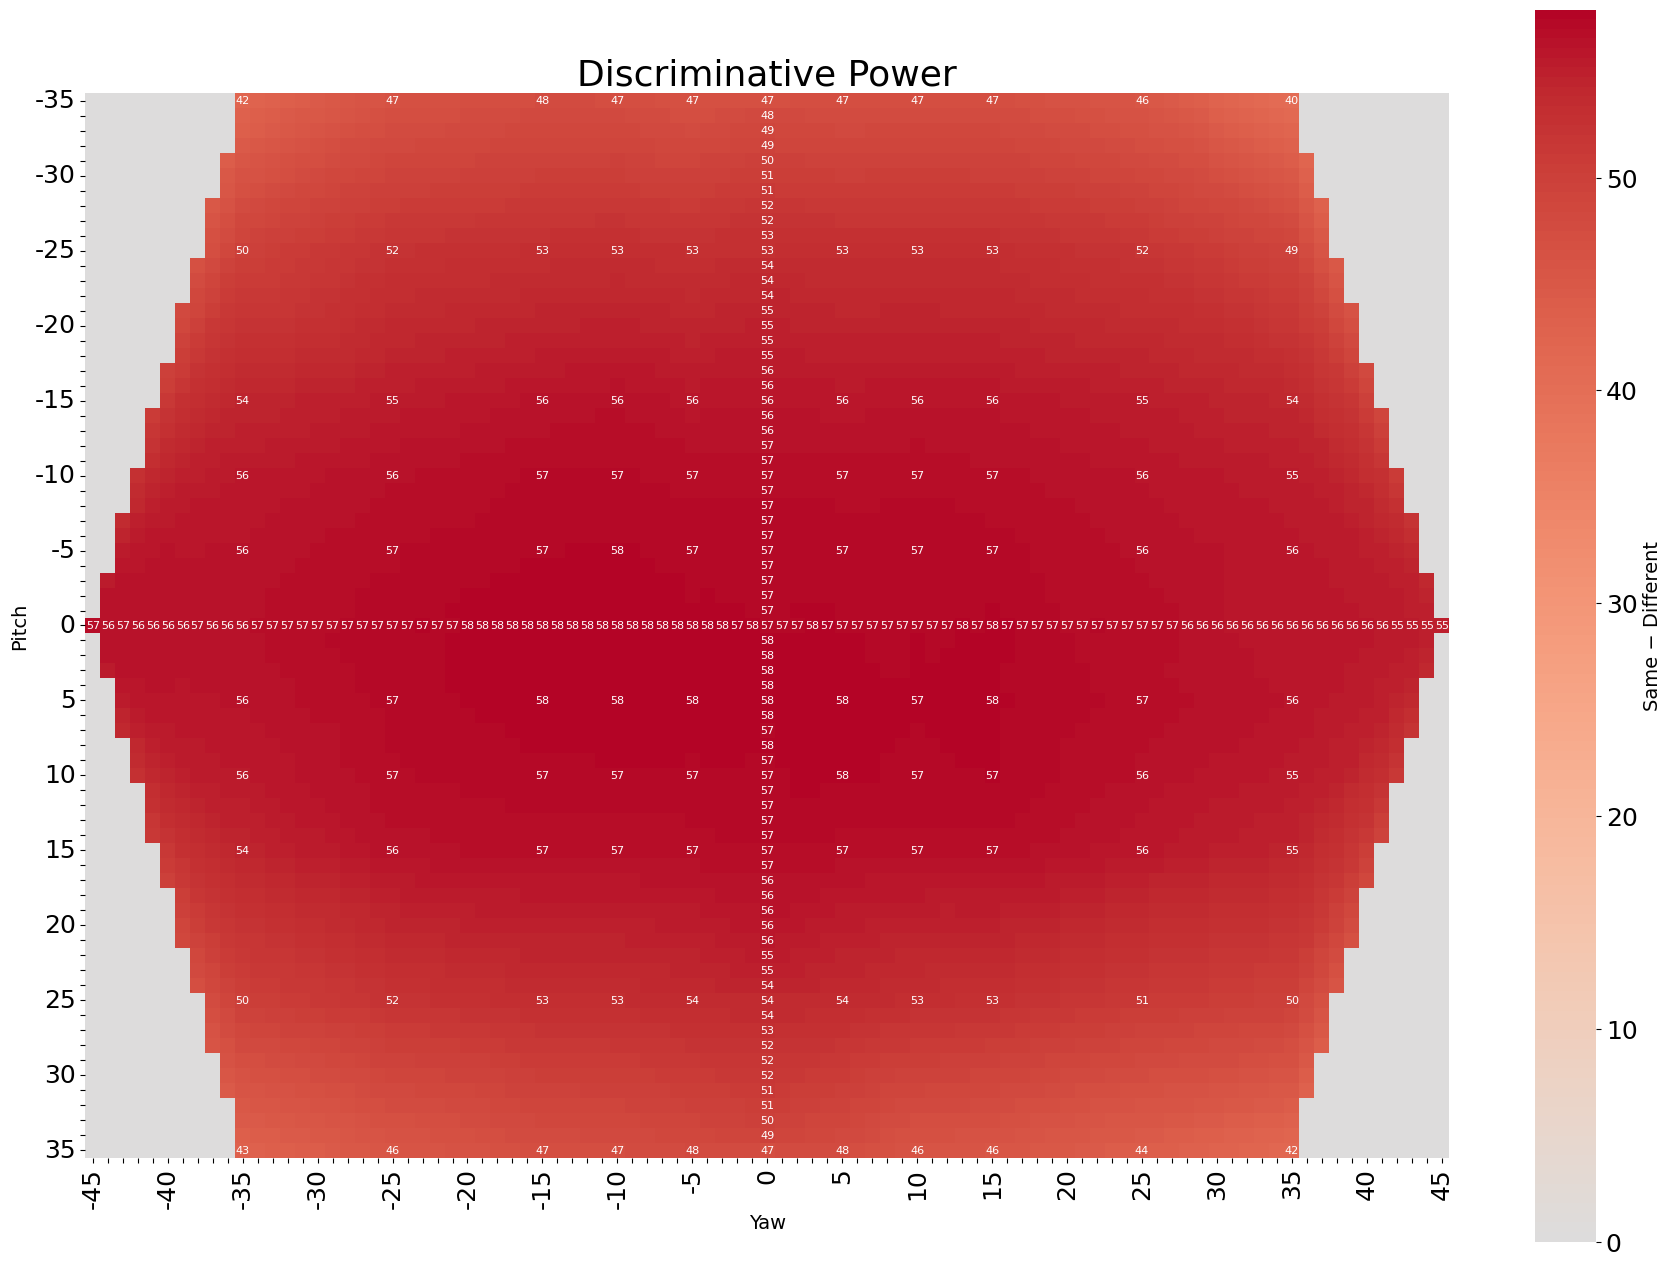

In [37]:
name="rgb_bff_crop261_emb-irseglintr18"
dataset = EmbeddingDataset(r"F:/Face/data/dataset15_emb/"+name, disable_tqdm=False)
avg_same, avg_diff, pitches, yaws = compute_average_heatmaps(dataset, center_pose=(0, 0), prefix=name, visualize=True)
avg_same, avg_diff, differences, pitches, yaws = compute_average_heatmaps_pairwise(dataset, prefix=name, visualize=True)

Compute distances: 100%|██████████| 19786/19786 [08:51<00:00, 37.22it/s]


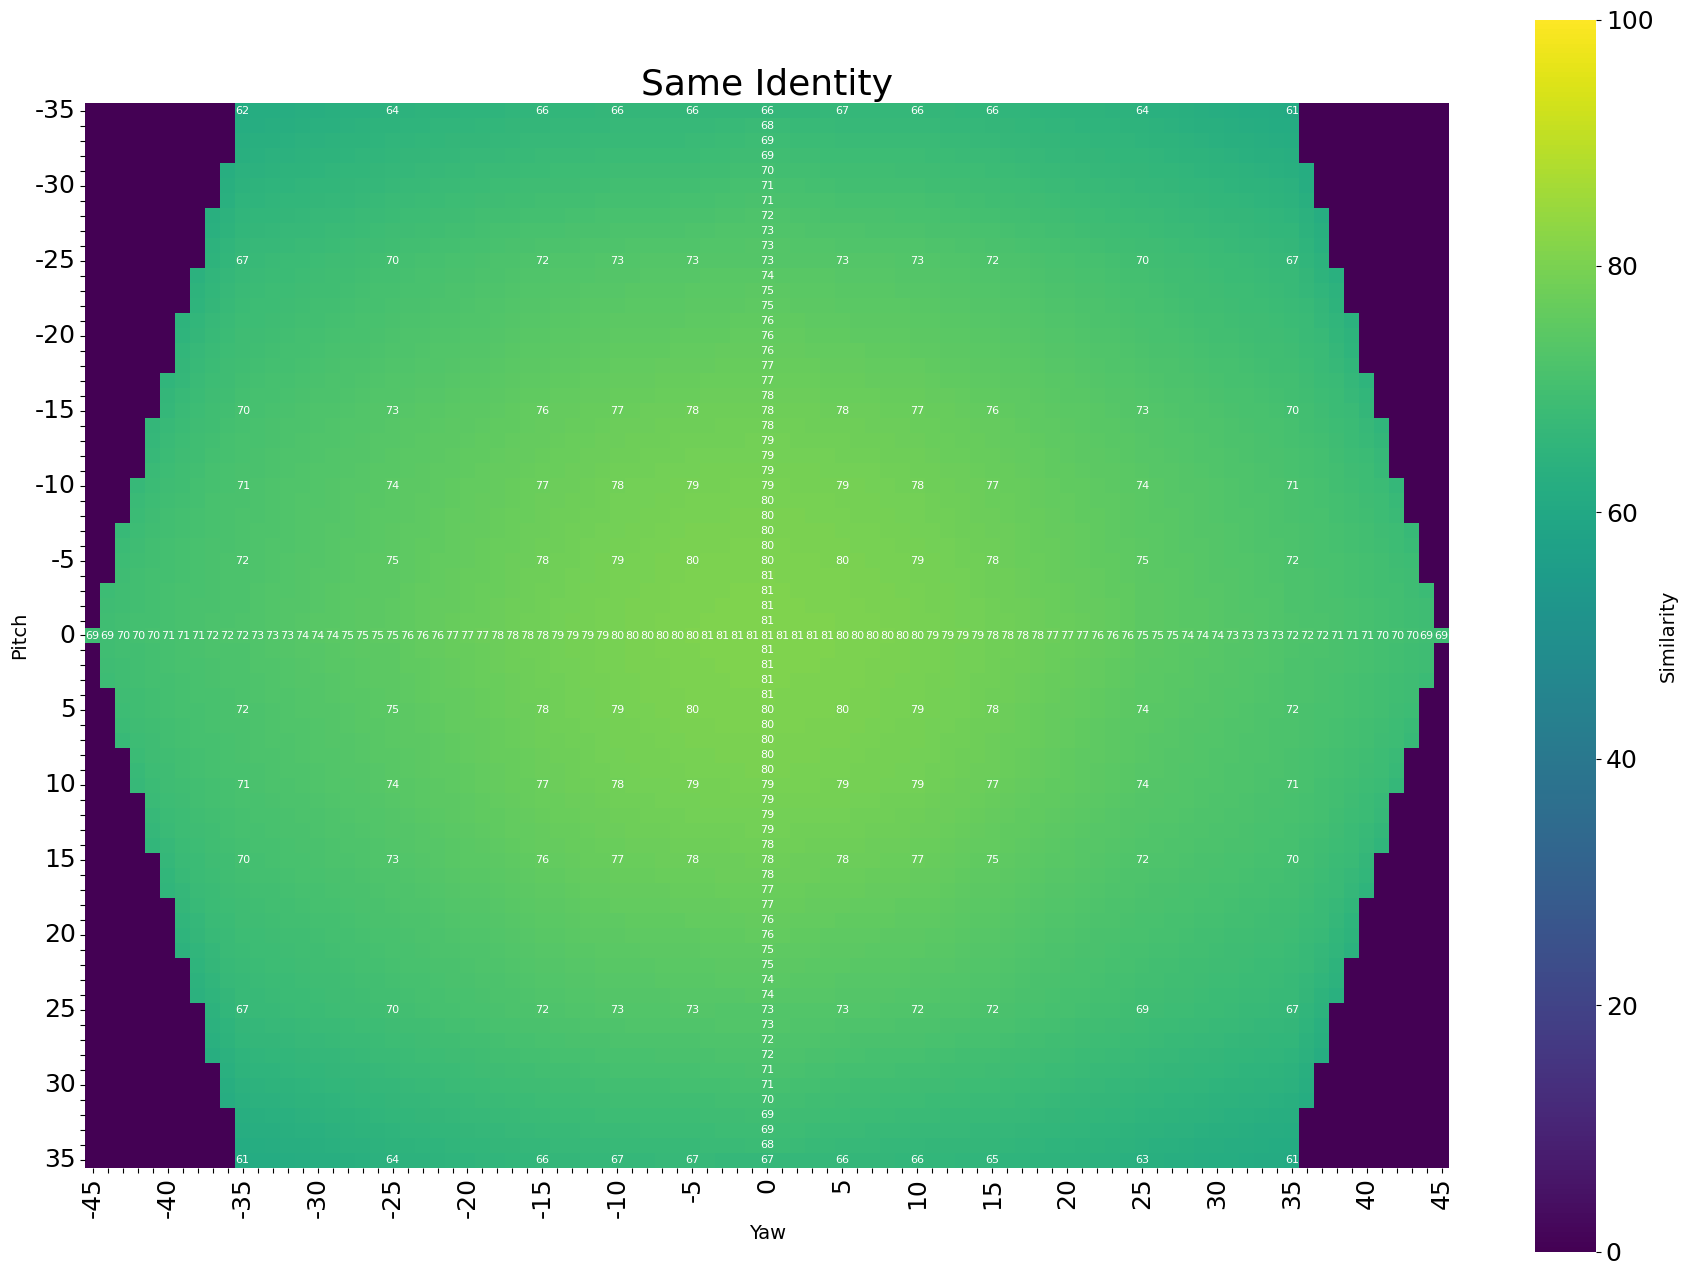

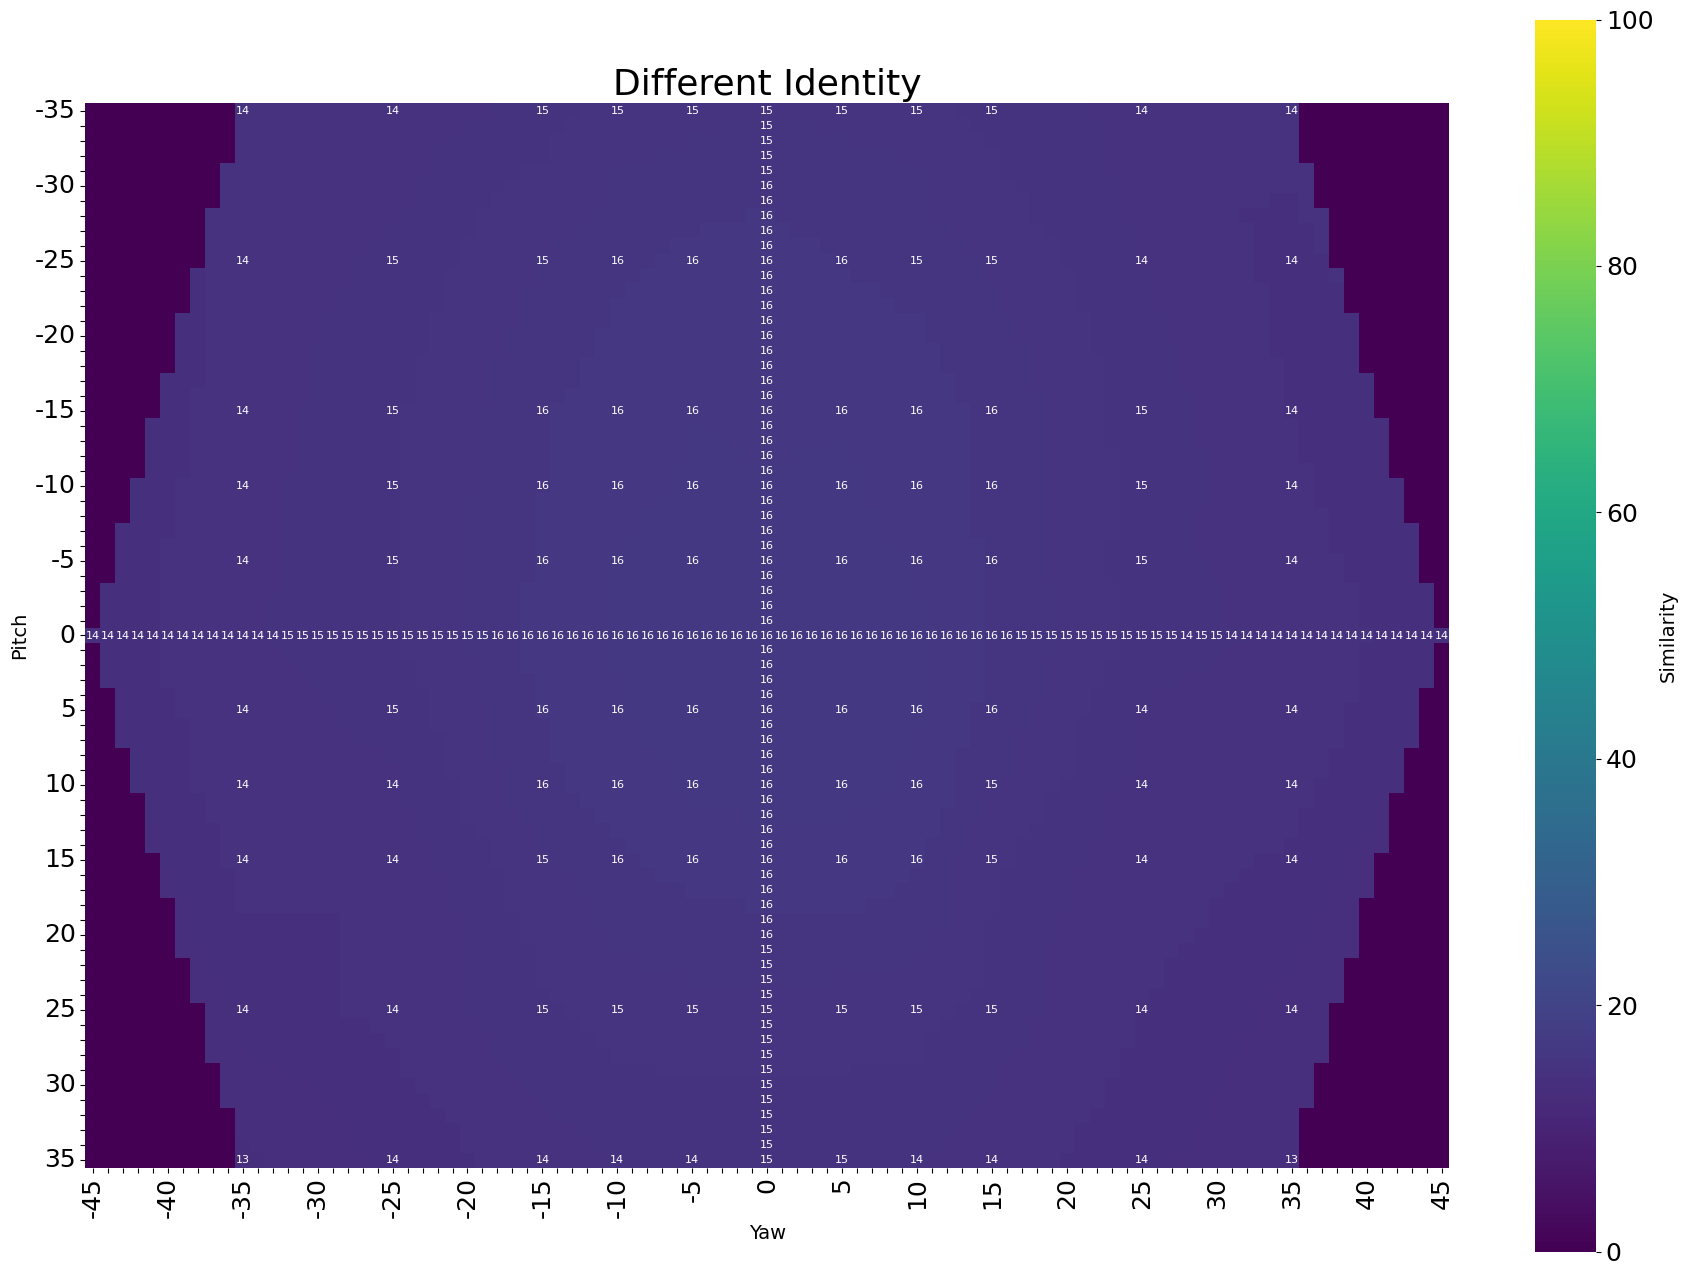

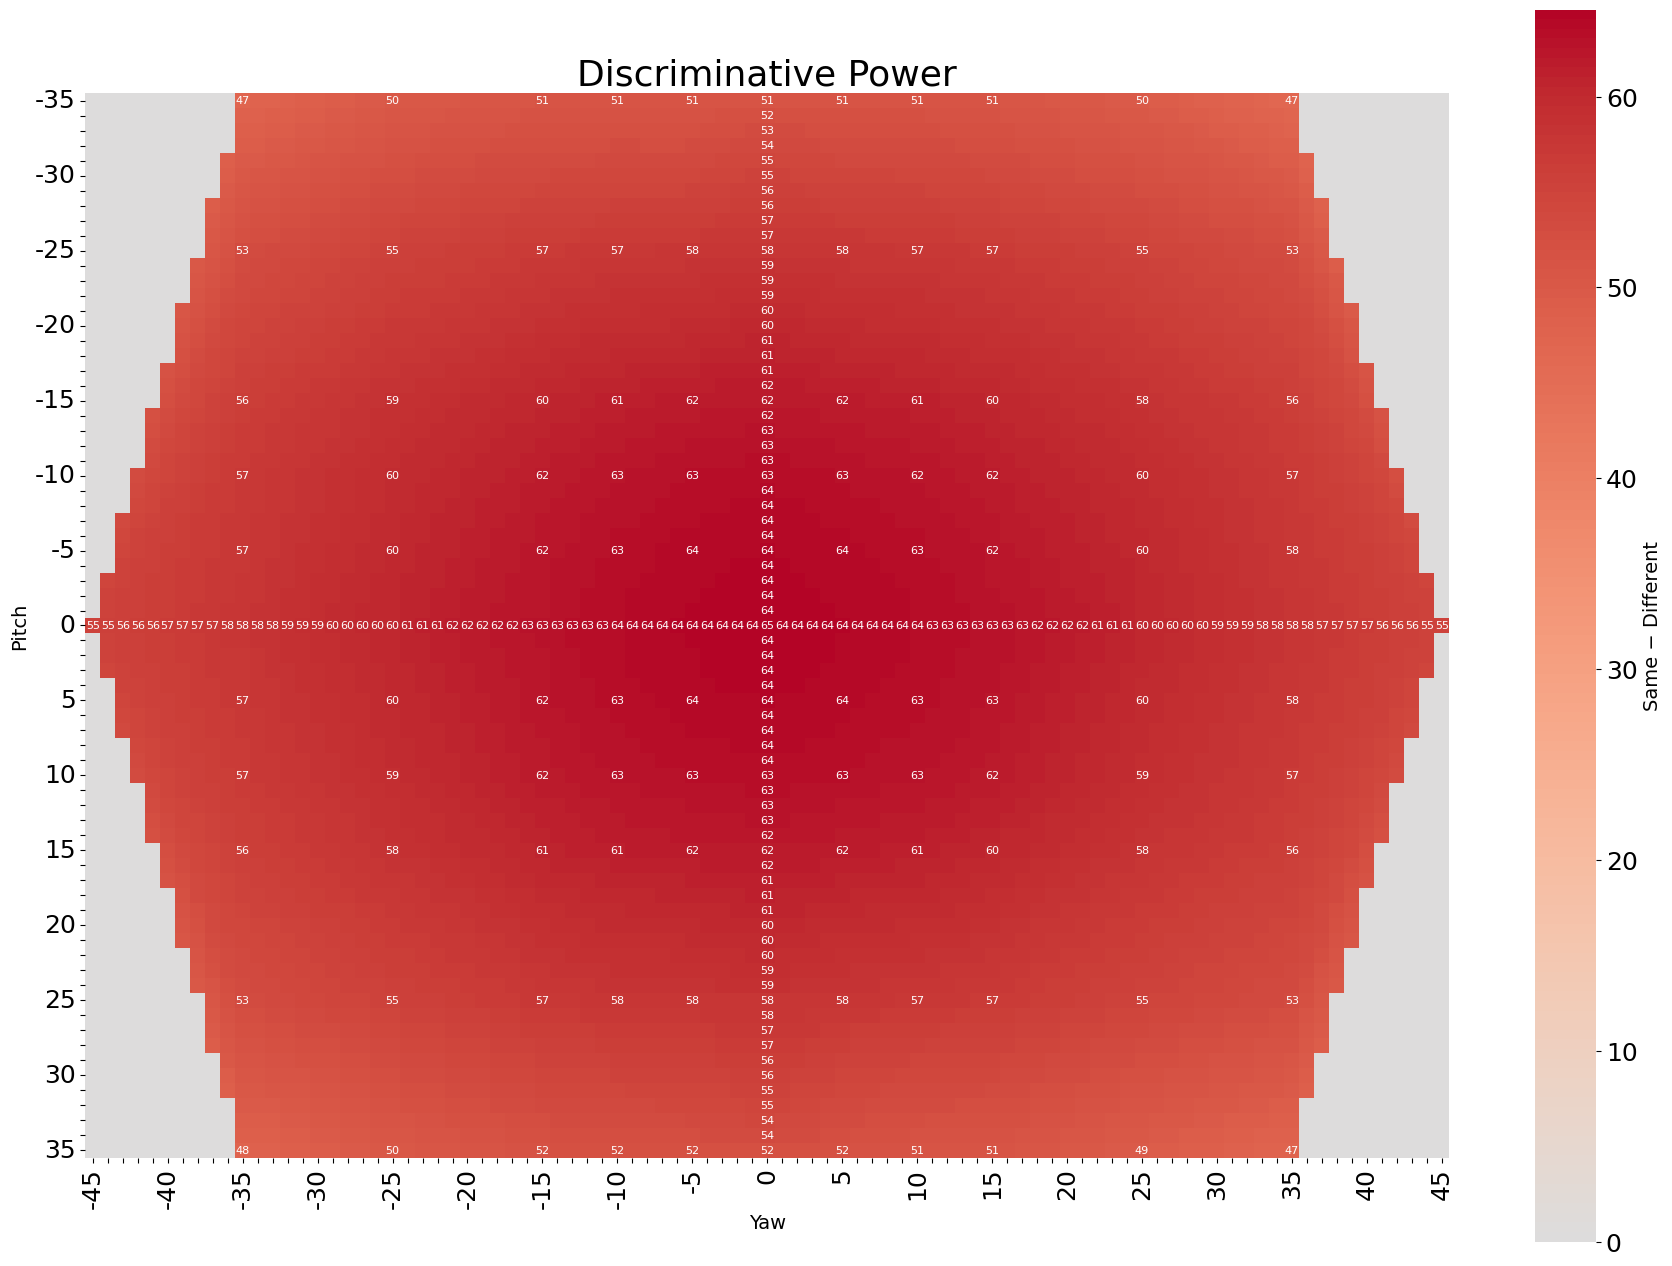

Compute distances: 100%|██████████| 19786/19786 [13:48<00:00, 23.88it/s]


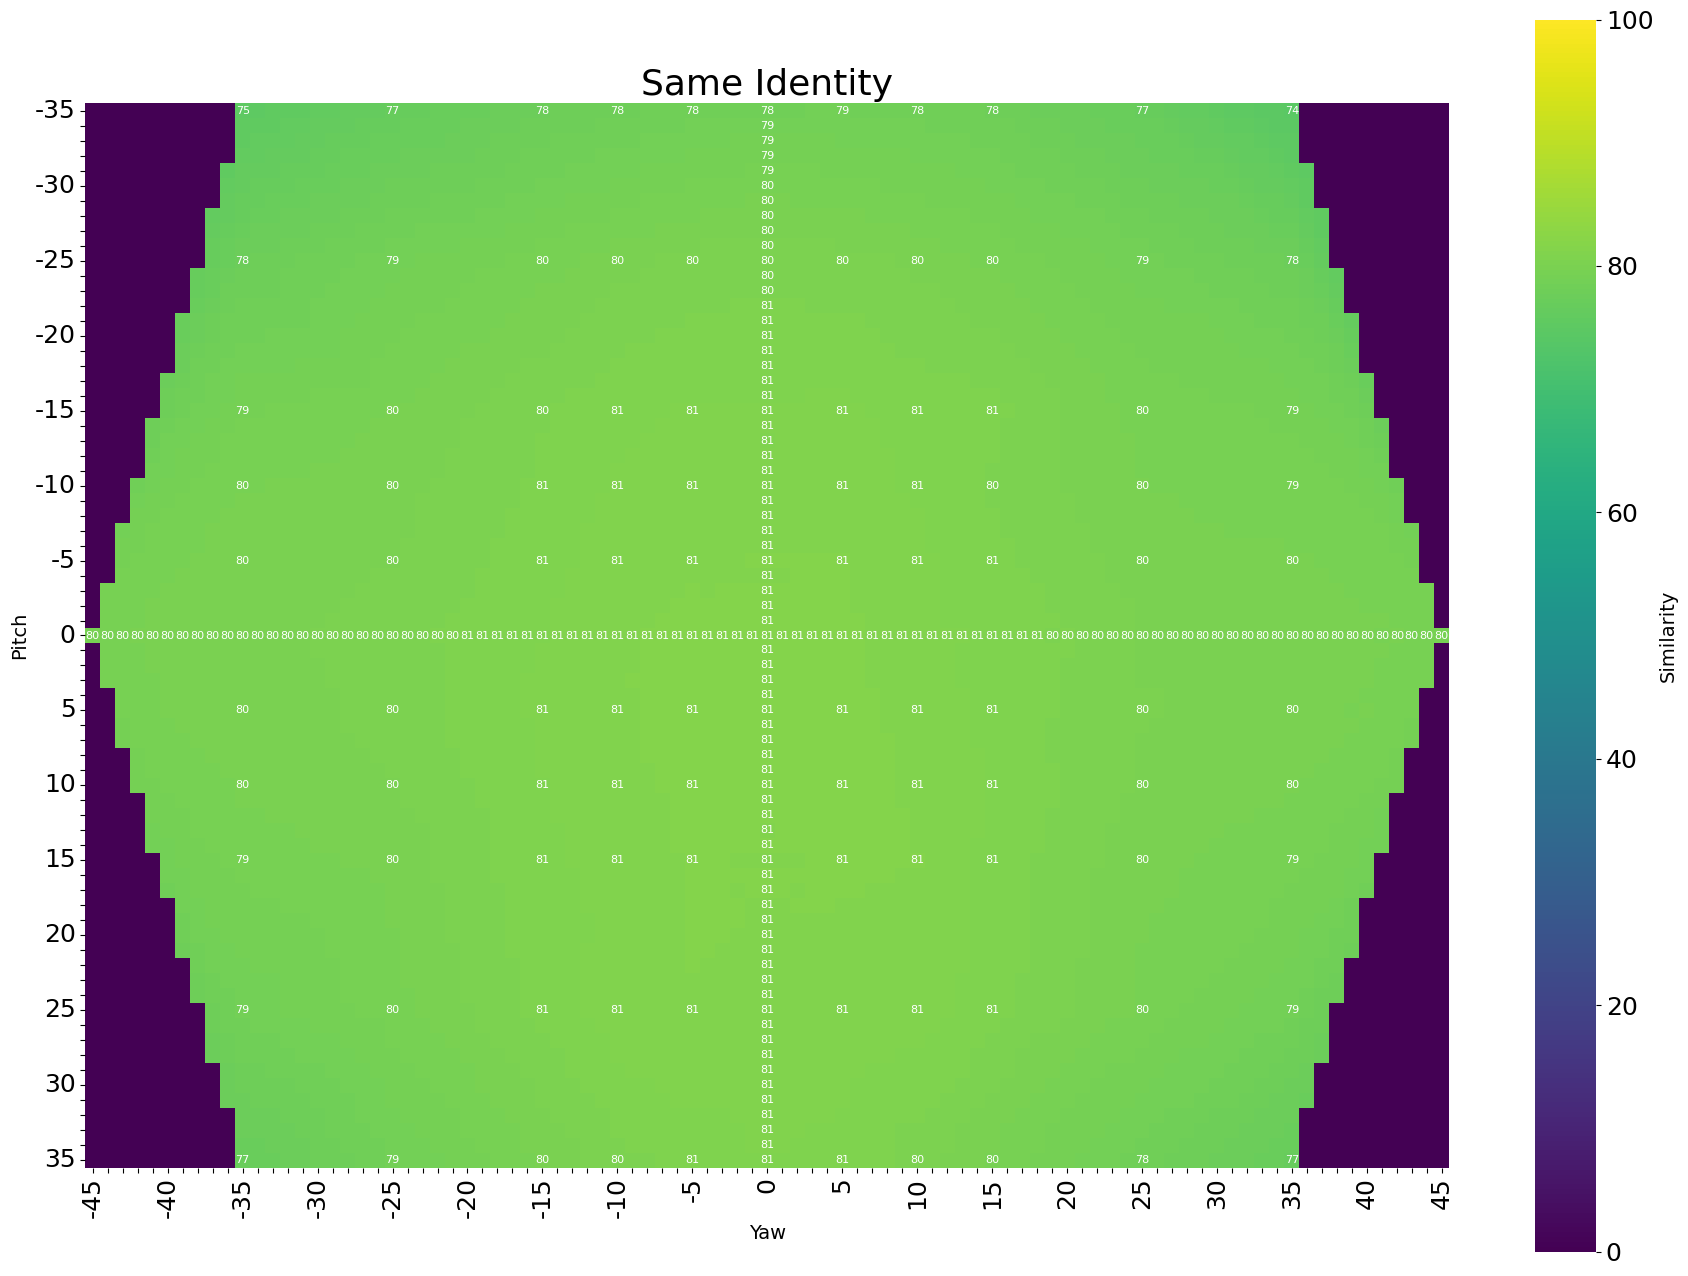

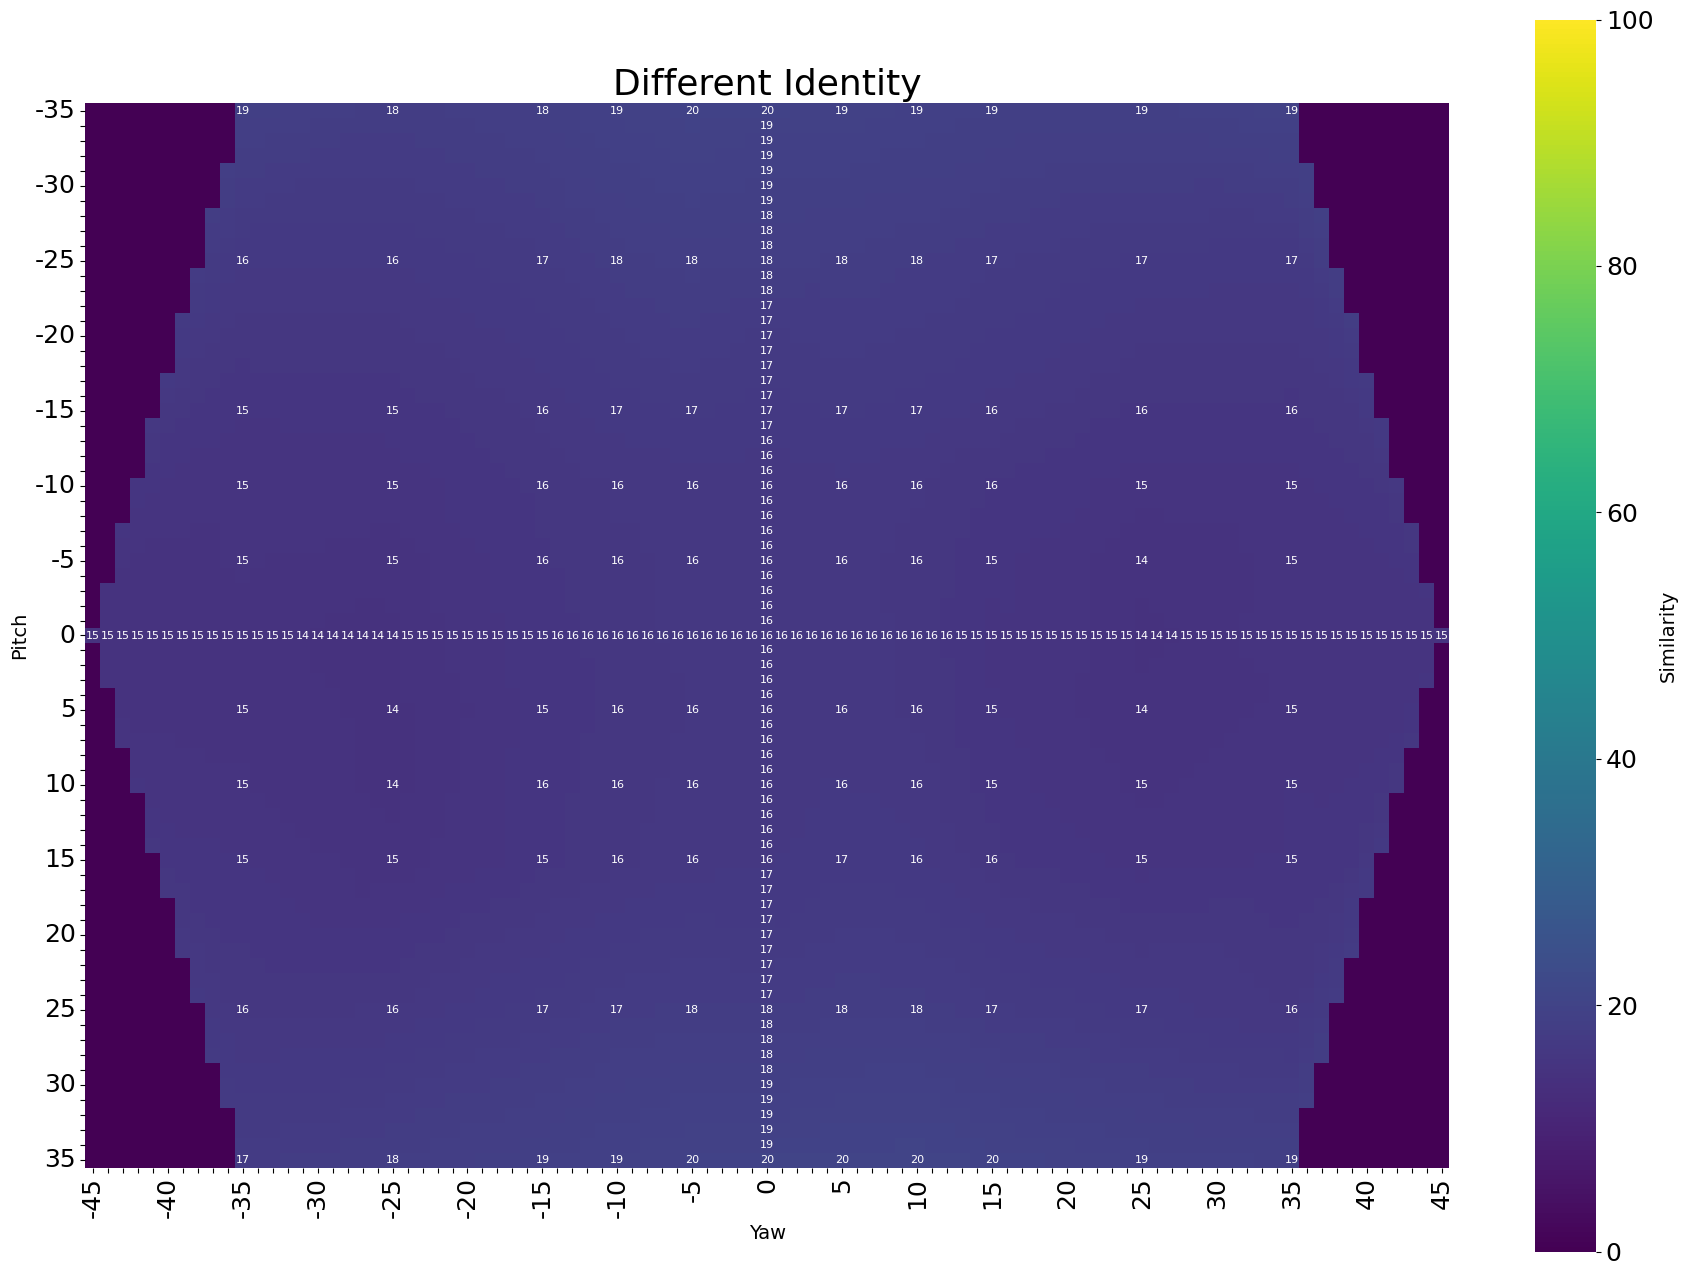

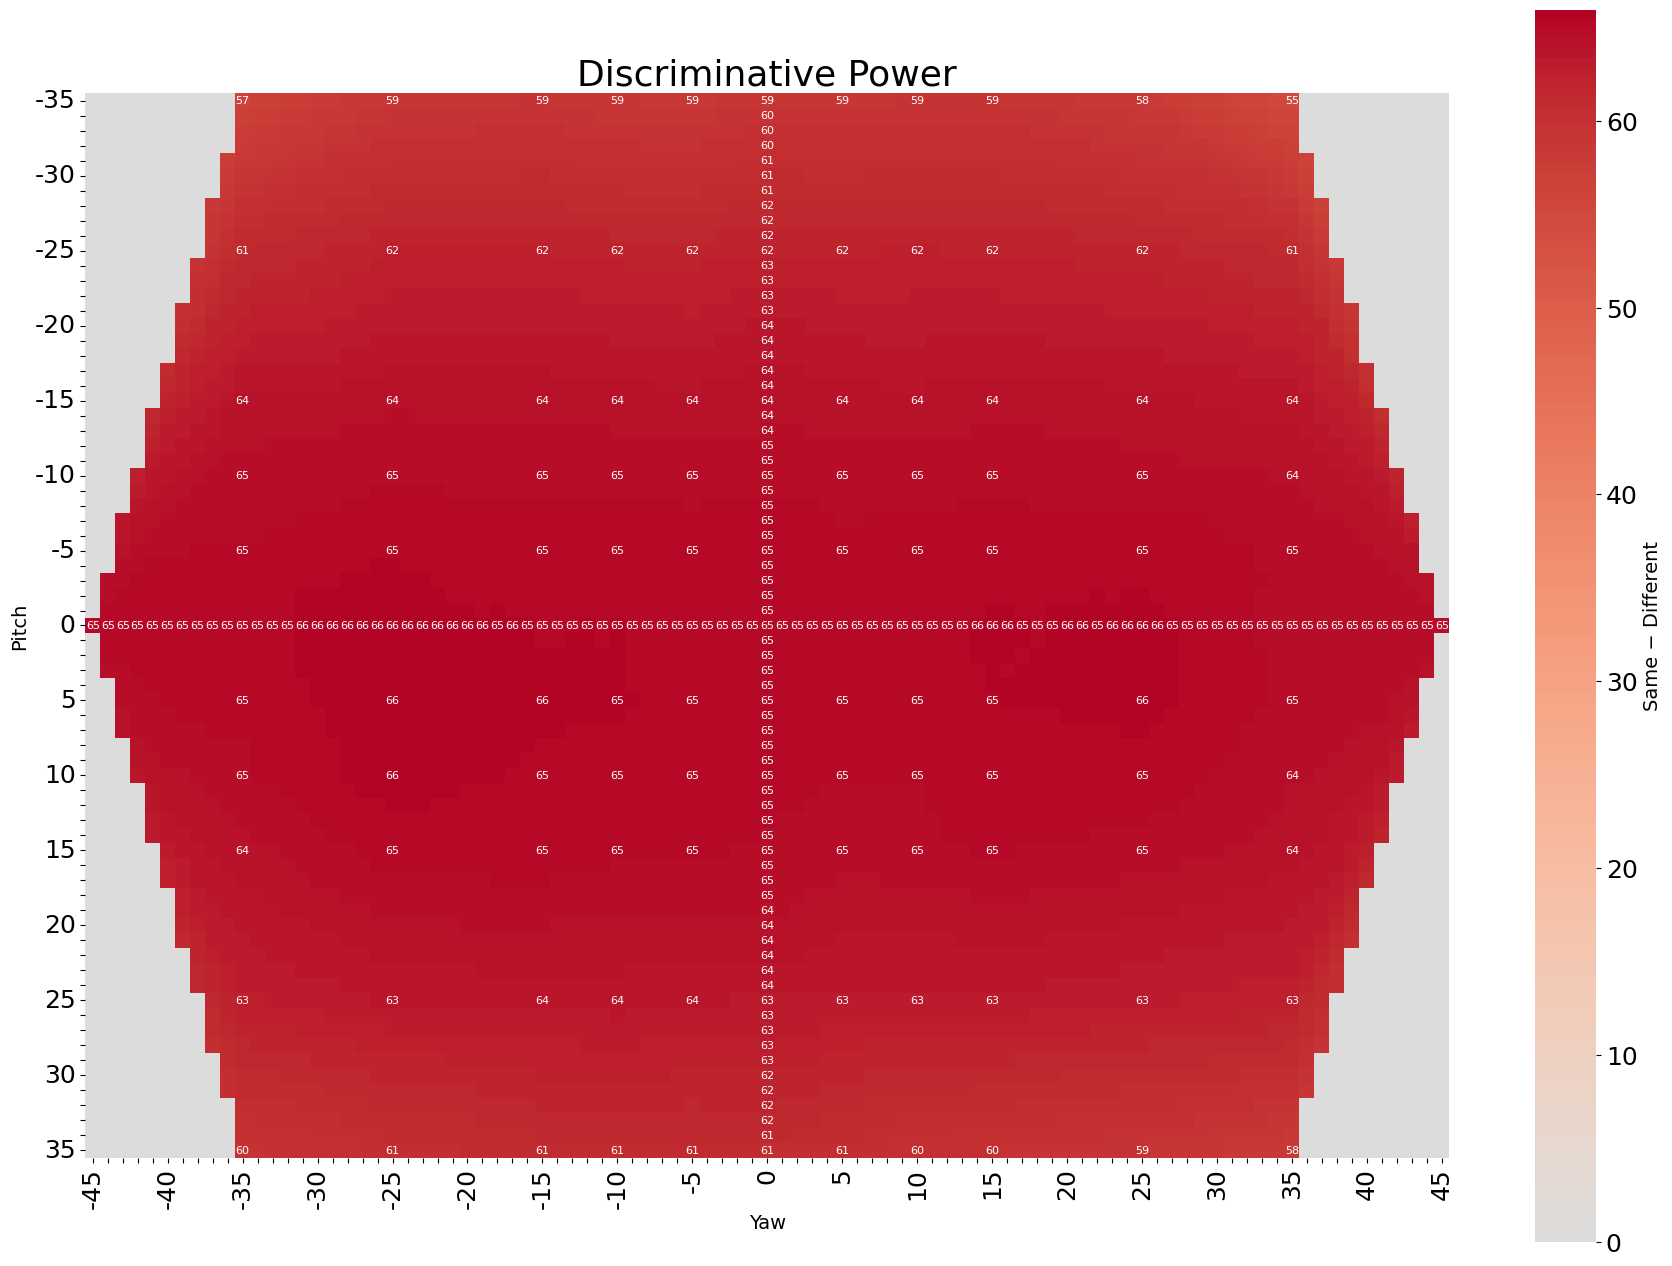

In [38]:
name="rgb_bff_crop261_emb-irseglintr100"
dataset = EmbeddingDataset(r"F:/Face/data/dataset15_emb/"+name, disable_tqdm=False)
avg_same, avg_diff, pitches, yaws = compute_average_heatmaps(dataset, center_pose=(0, 0), prefix=name, visualize=True)
avg_same, avg_diff, differences, pitches, yaws = compute_average_heatmaps_pairwise(dataset, prefix=name, visualize=True)

Compute distances: 100%|██████████| 19786/19786 [08:45<00:00, 37.69it/s]


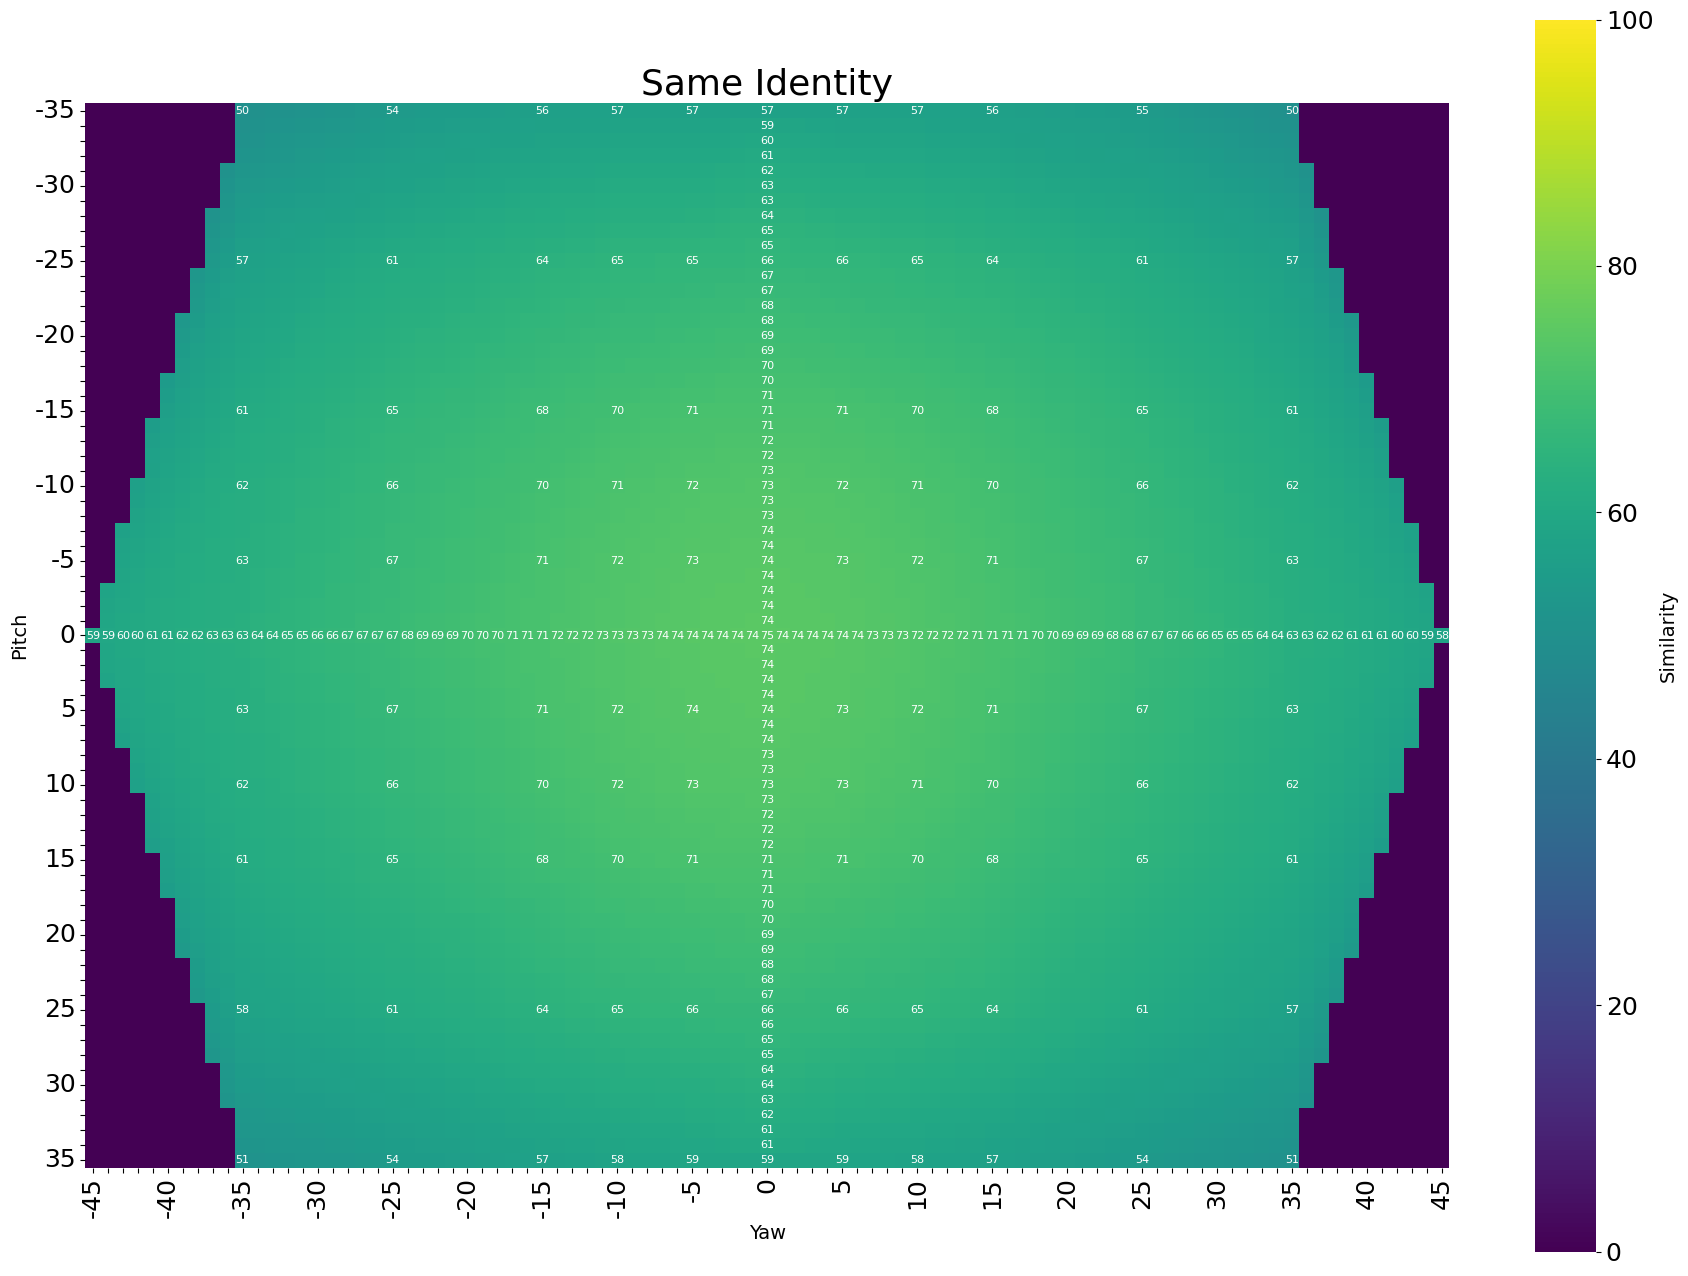

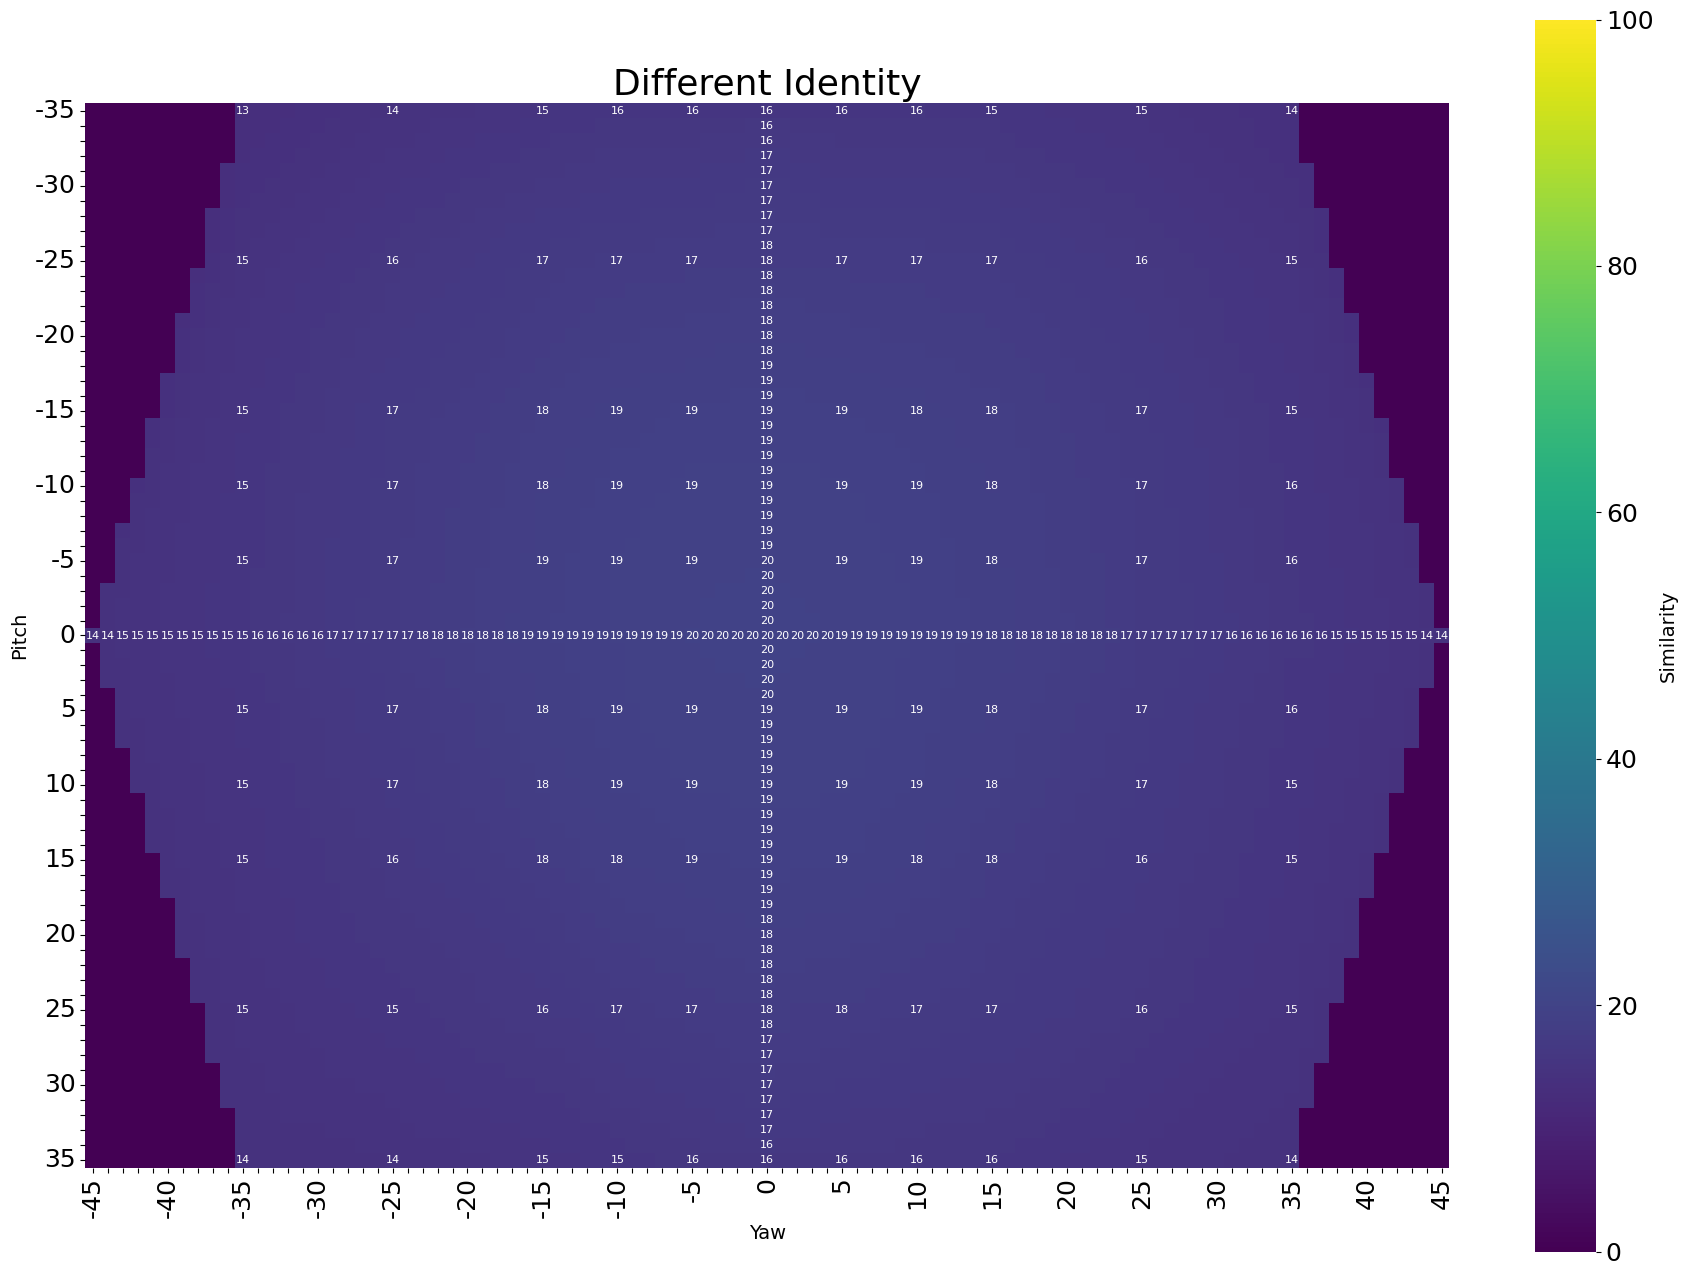

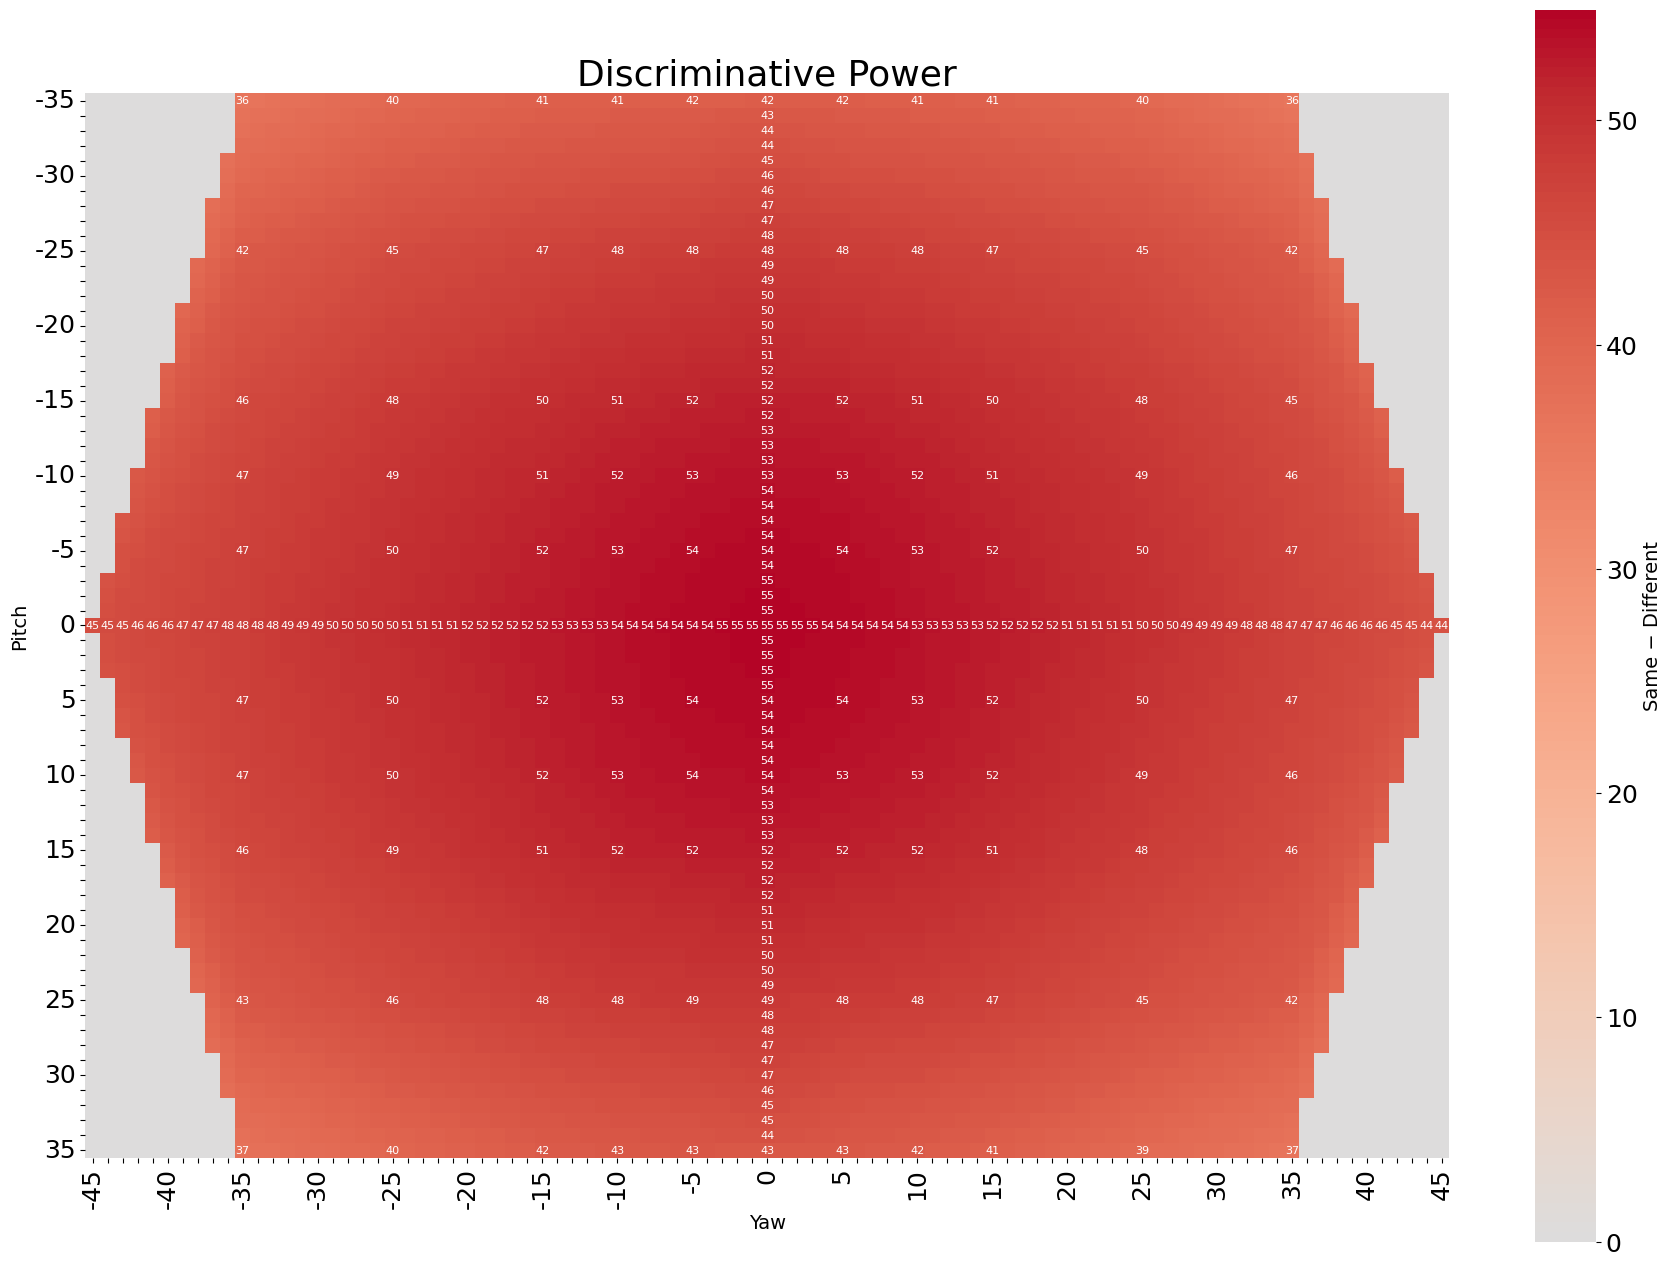

Compute distances: 100%|██████████| 19786/19786 [13:58<00:00, 23.60it/s]


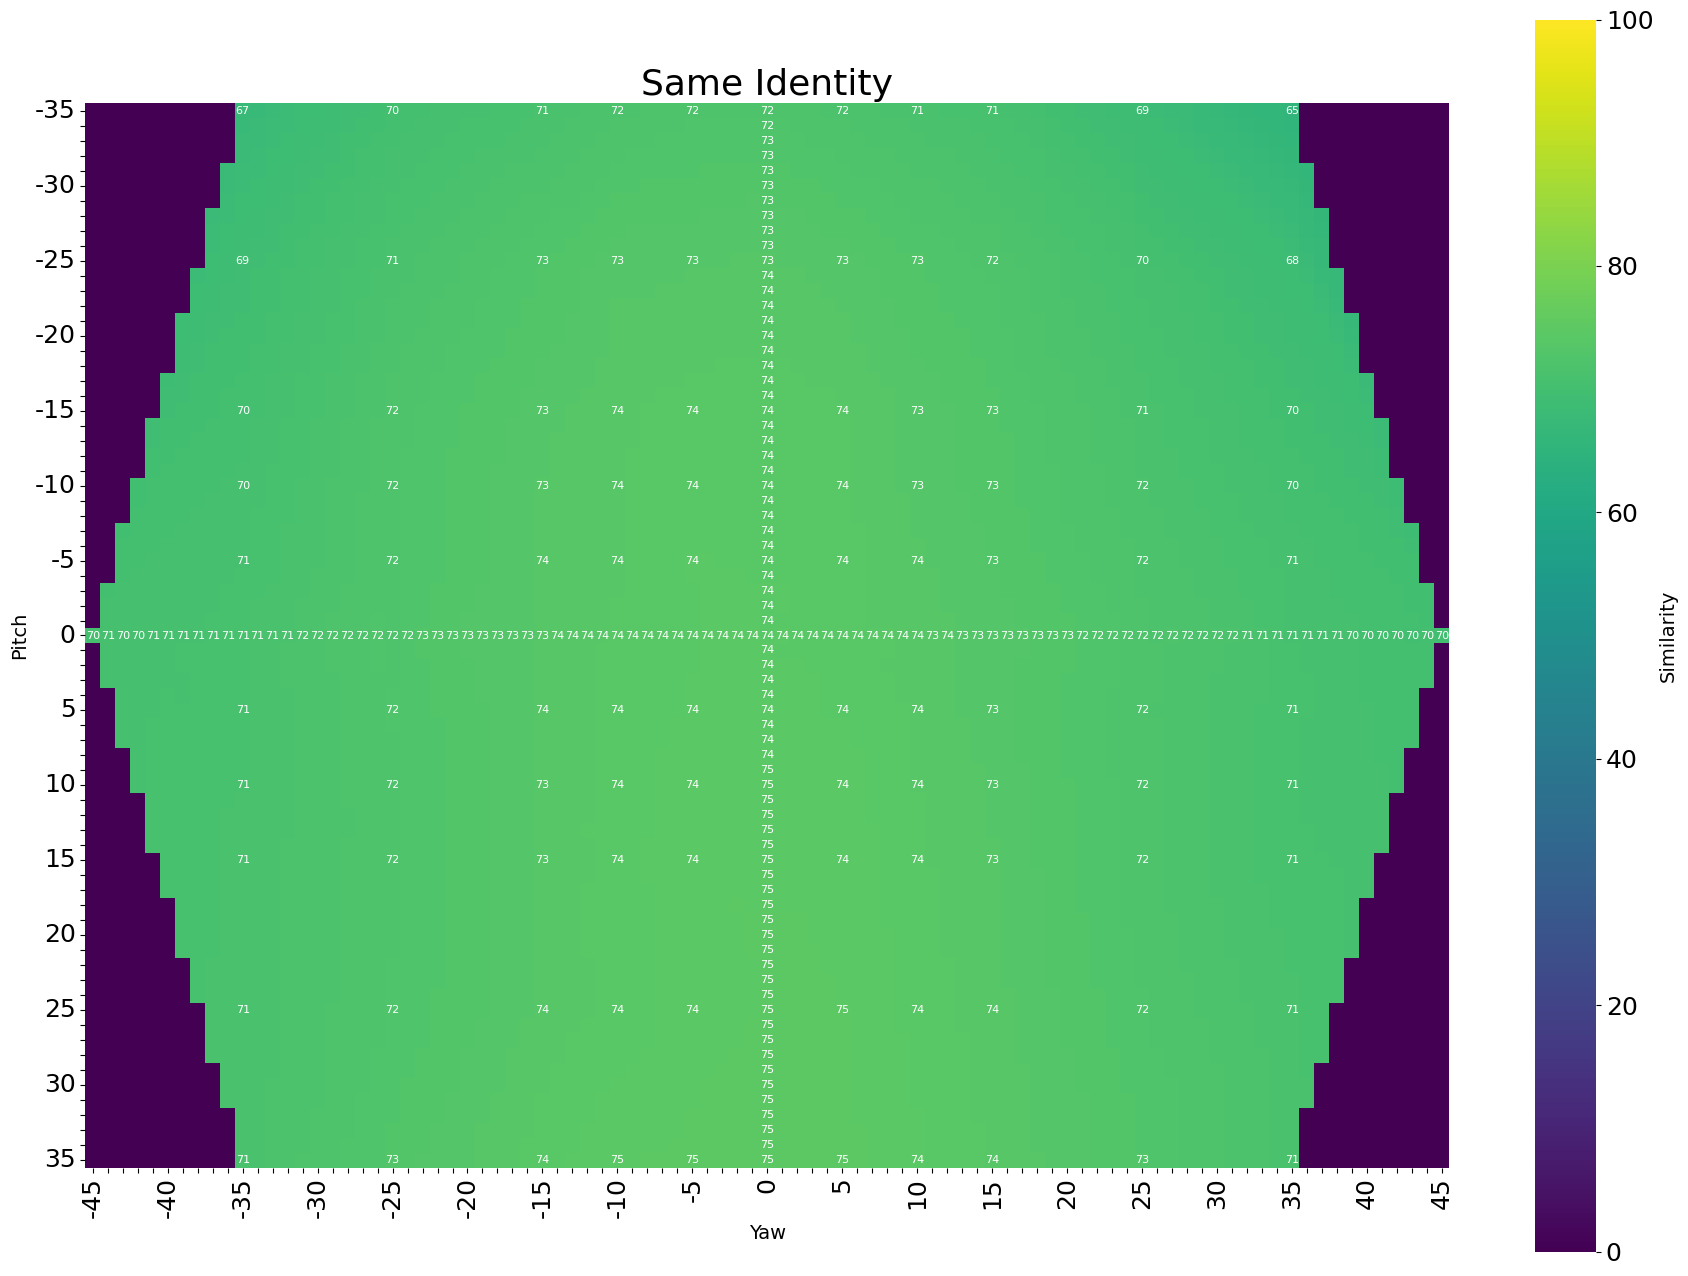

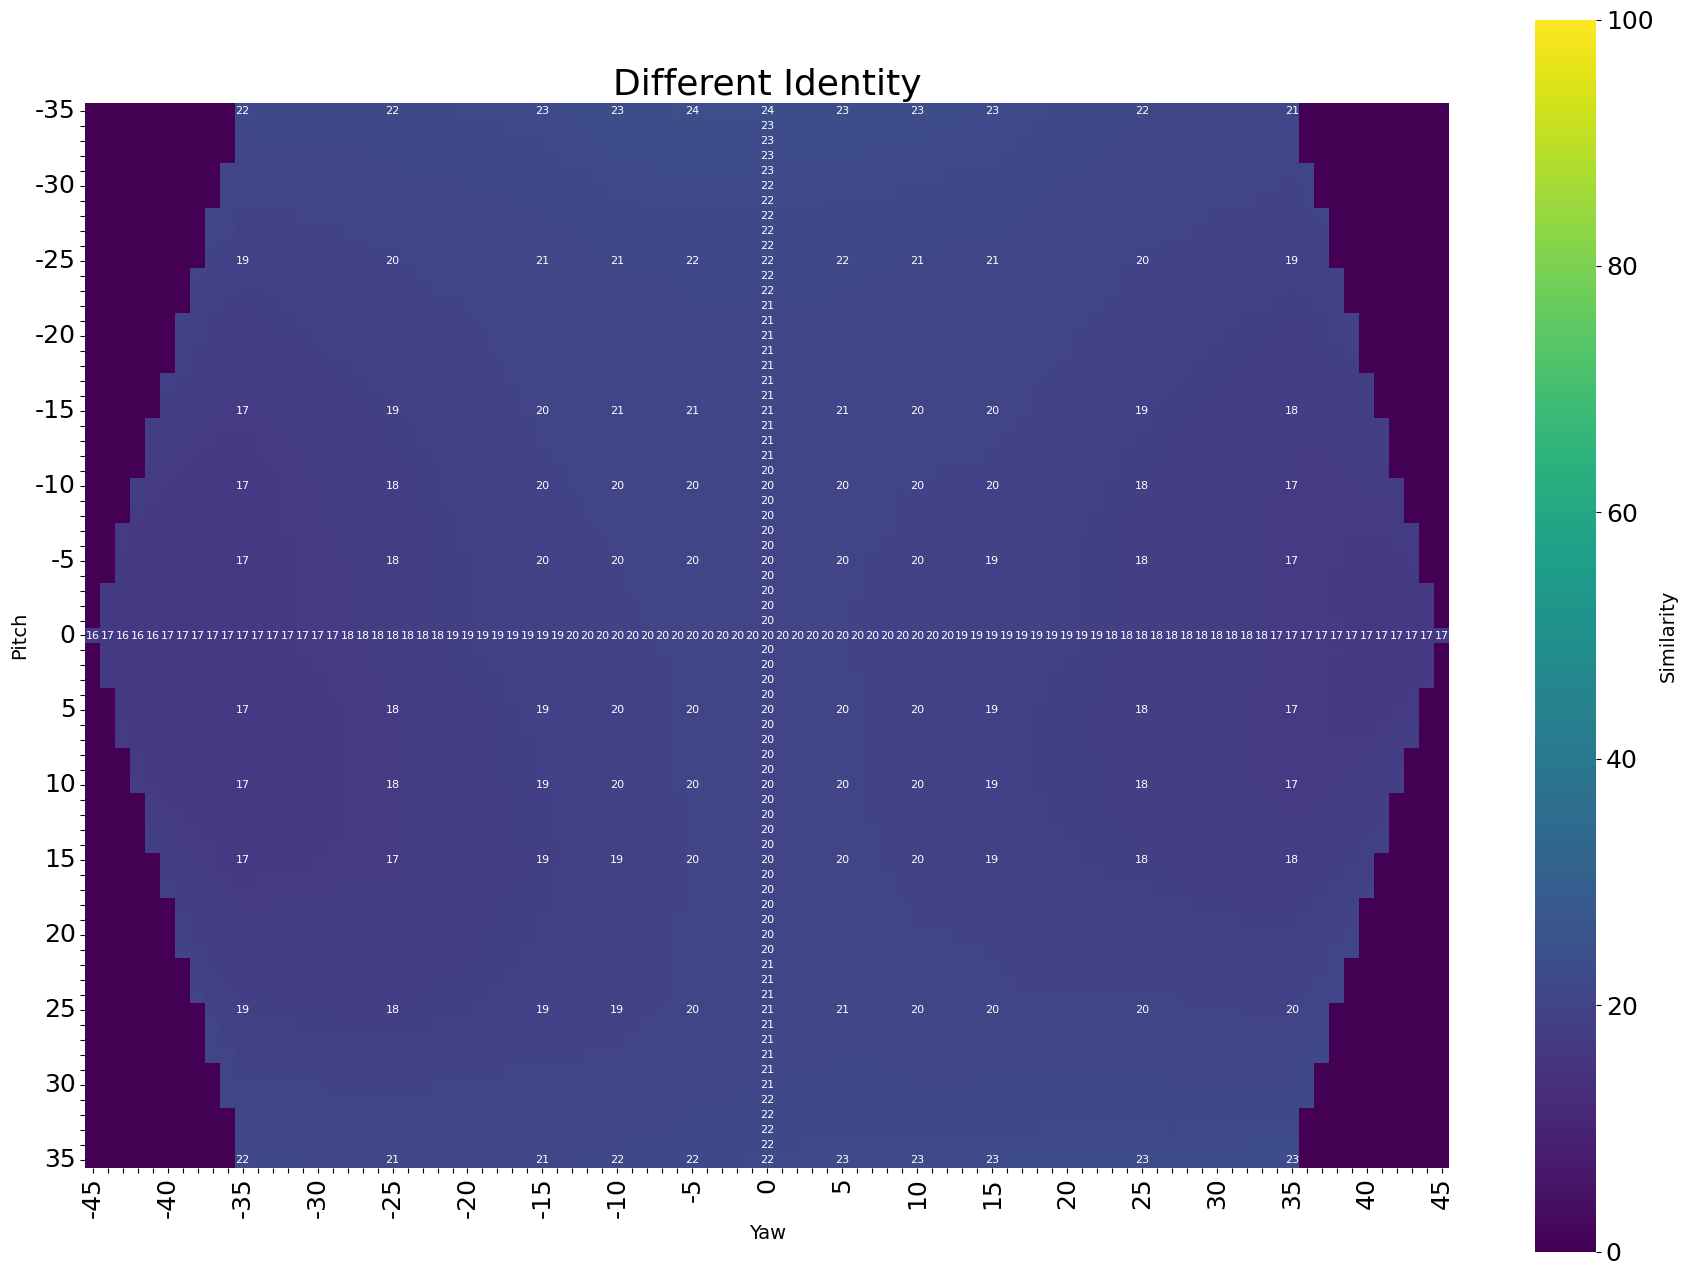

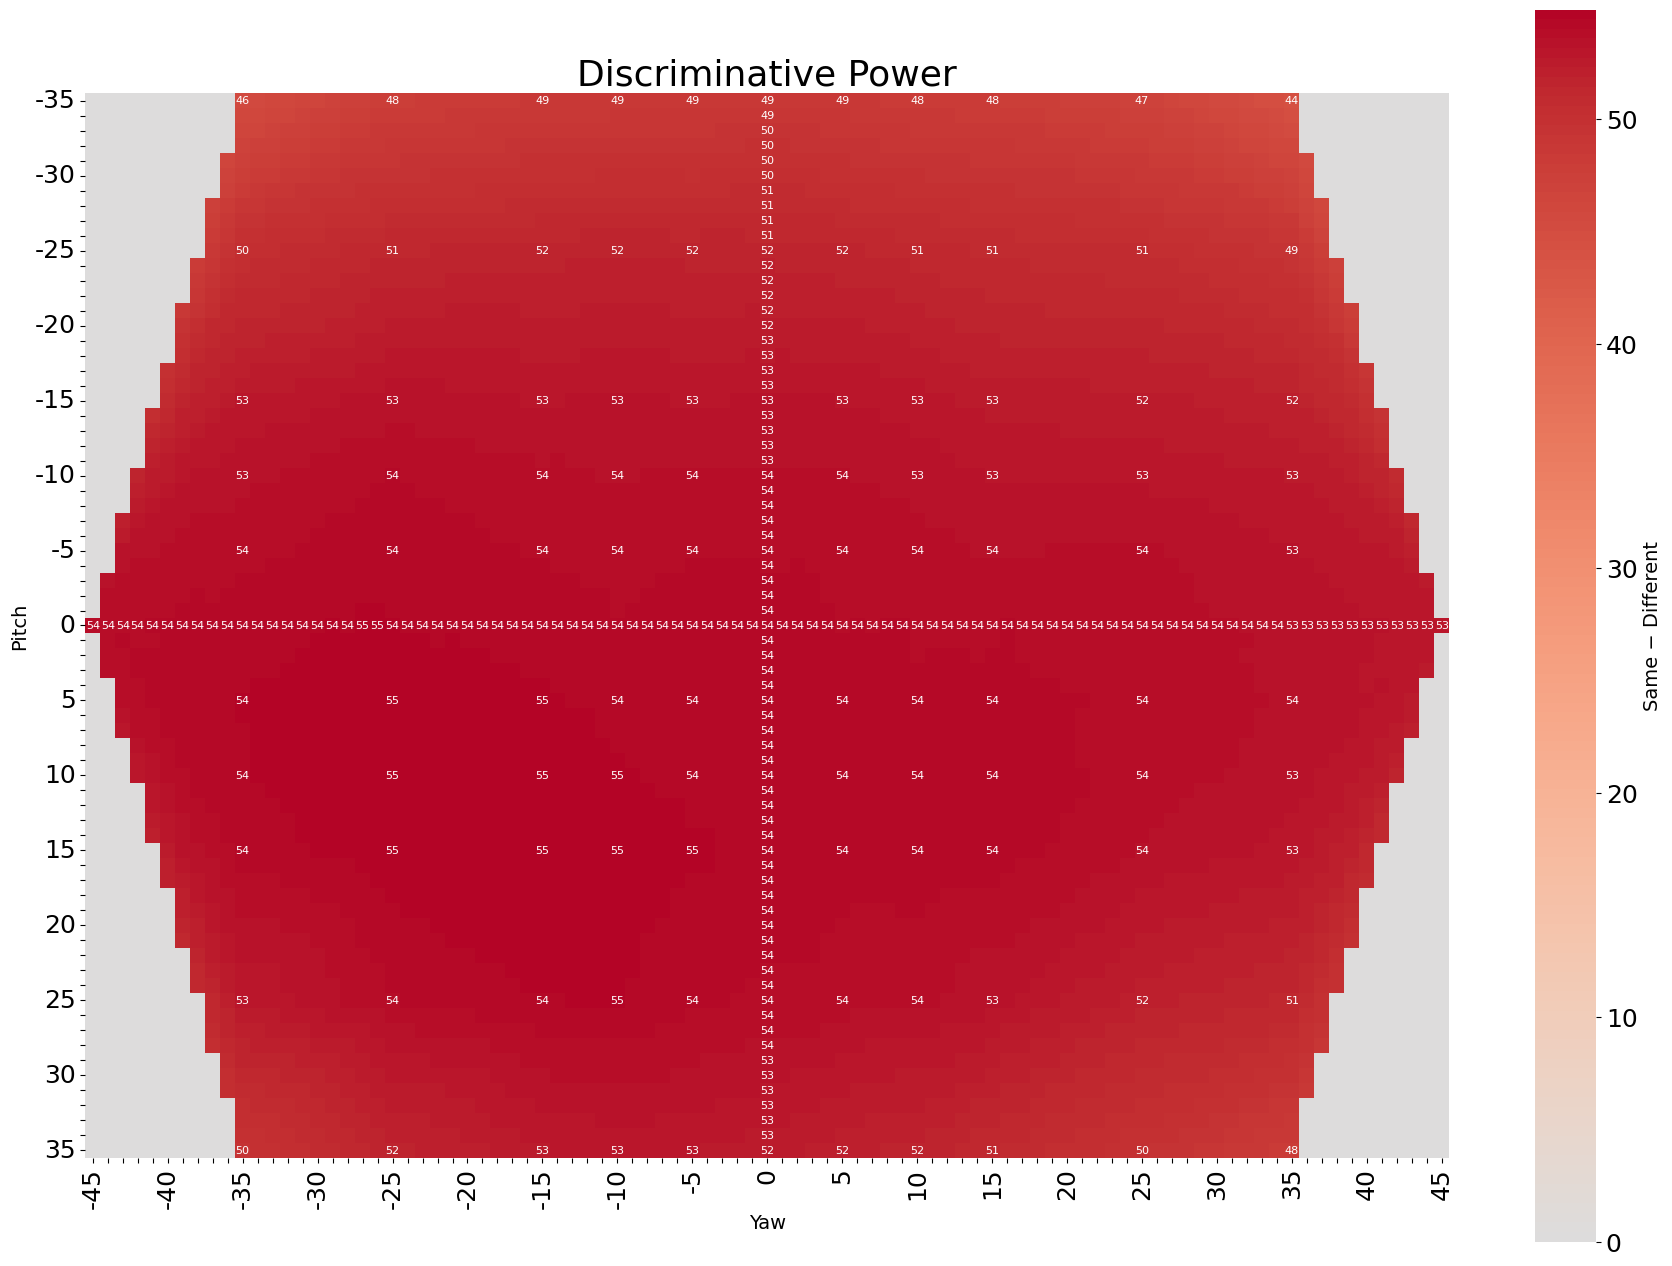

In [39]:
name="rgb_bff_crop261_emb-irsehyperr50"
dataset = EmbeddingDataset(r"F:/Face/data/dataset15_emb/"+name, disable_tqdm=False)
avg_same, avg_diff, pitches, yaws = compute_average_heatmaps(dataset, center_pose=(0, 0), prefix=name, visualize=True)
avg_same, avg_diff, differences, pitches, yaws = compute_average_heatmaps_pairwise(dataset, prefix=name, visualize=True)

Loading classes:   0%|          | 0/1041 [00:00<?, ?it/s]

Compute distances: 100%|██████████| 19786/19786 [08:49<00:00, 37.34it/s]


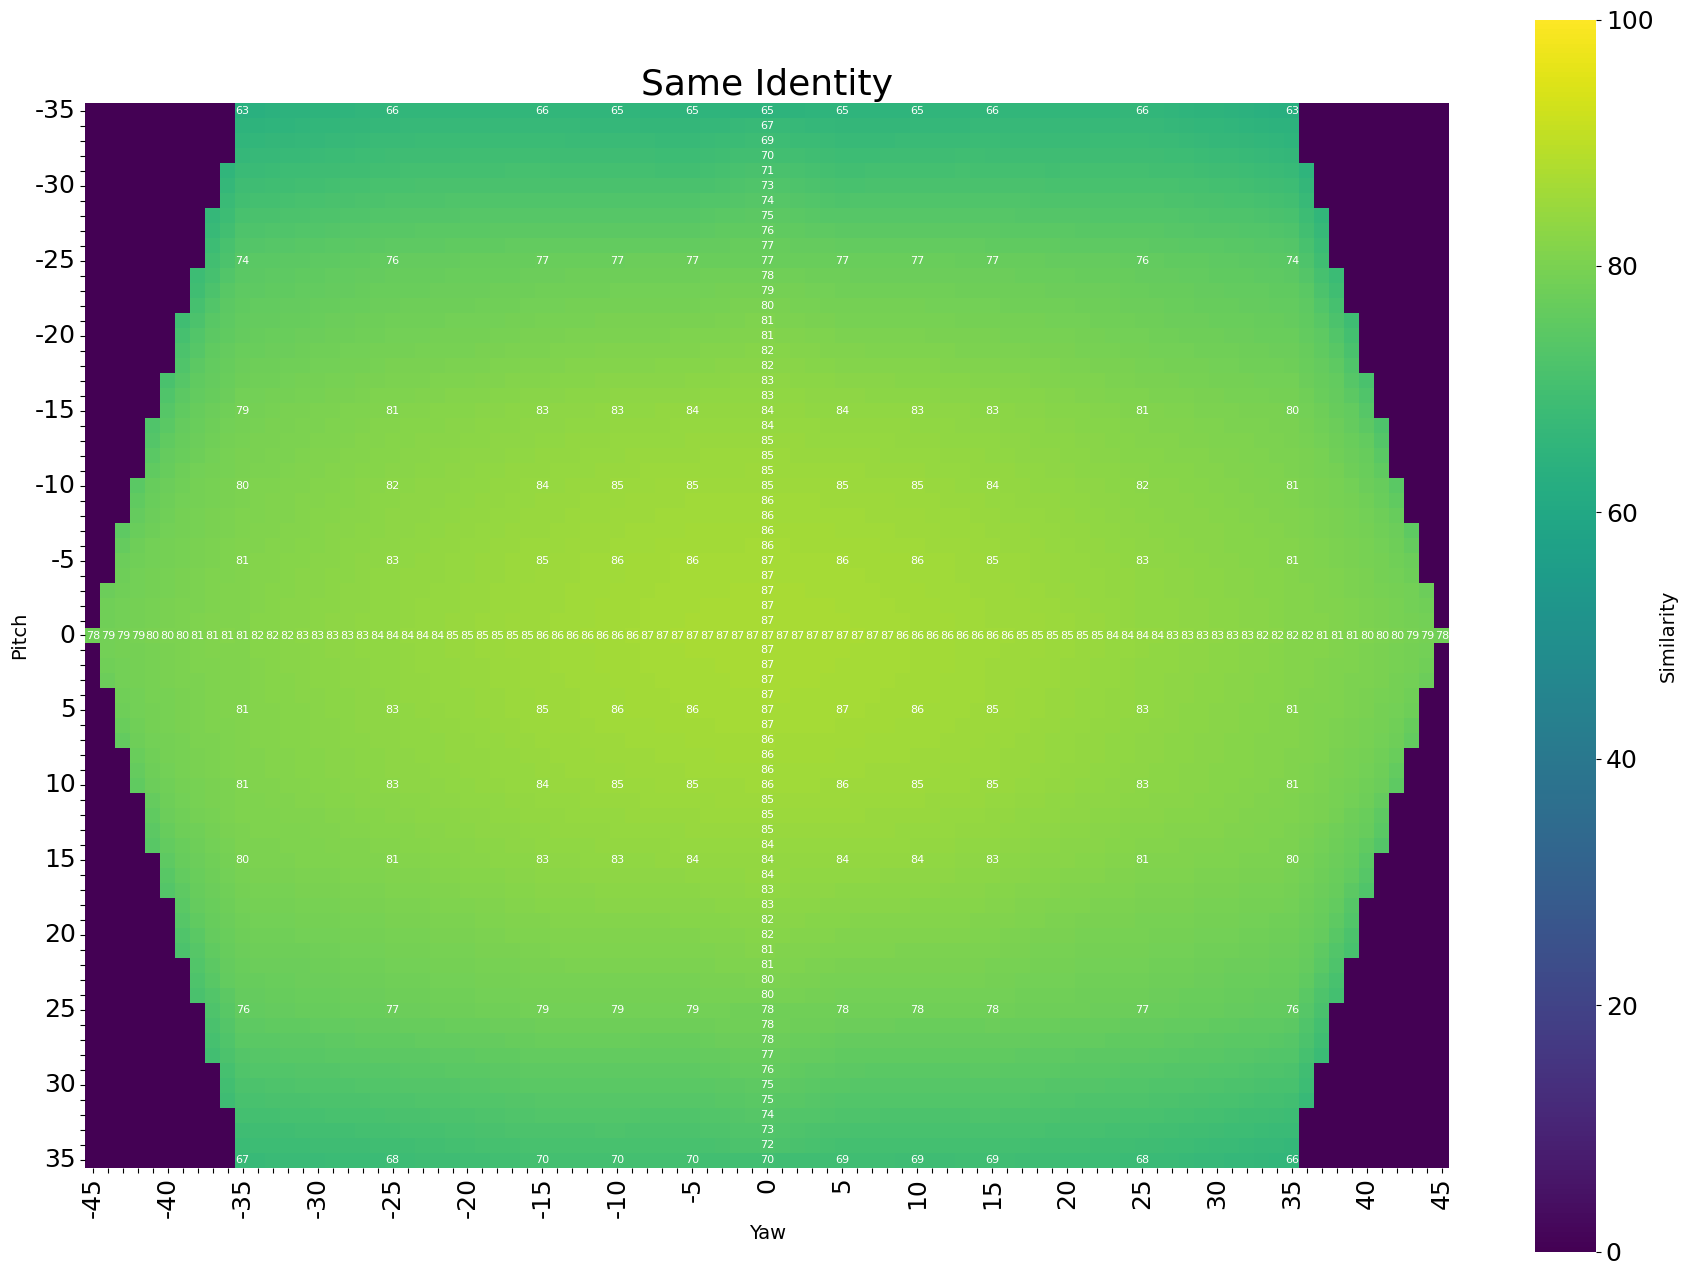

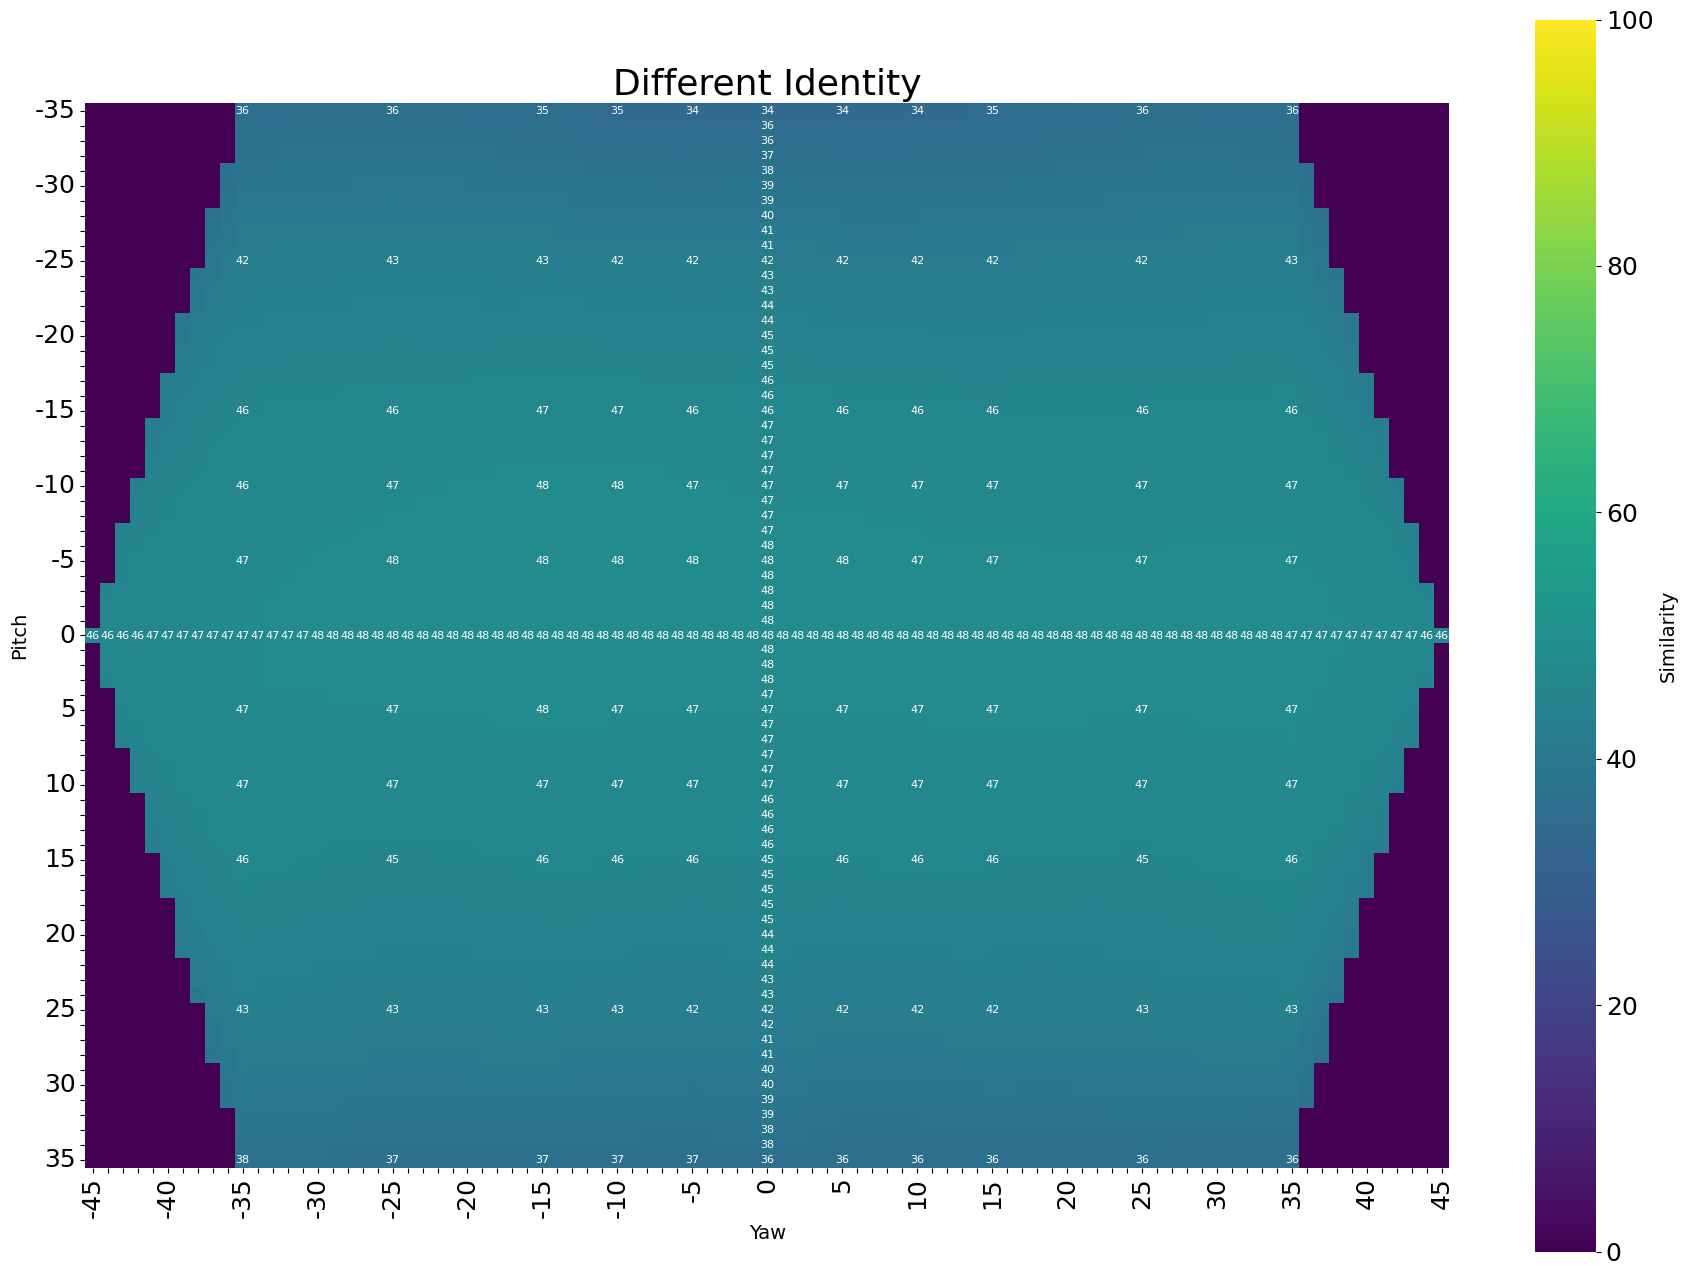

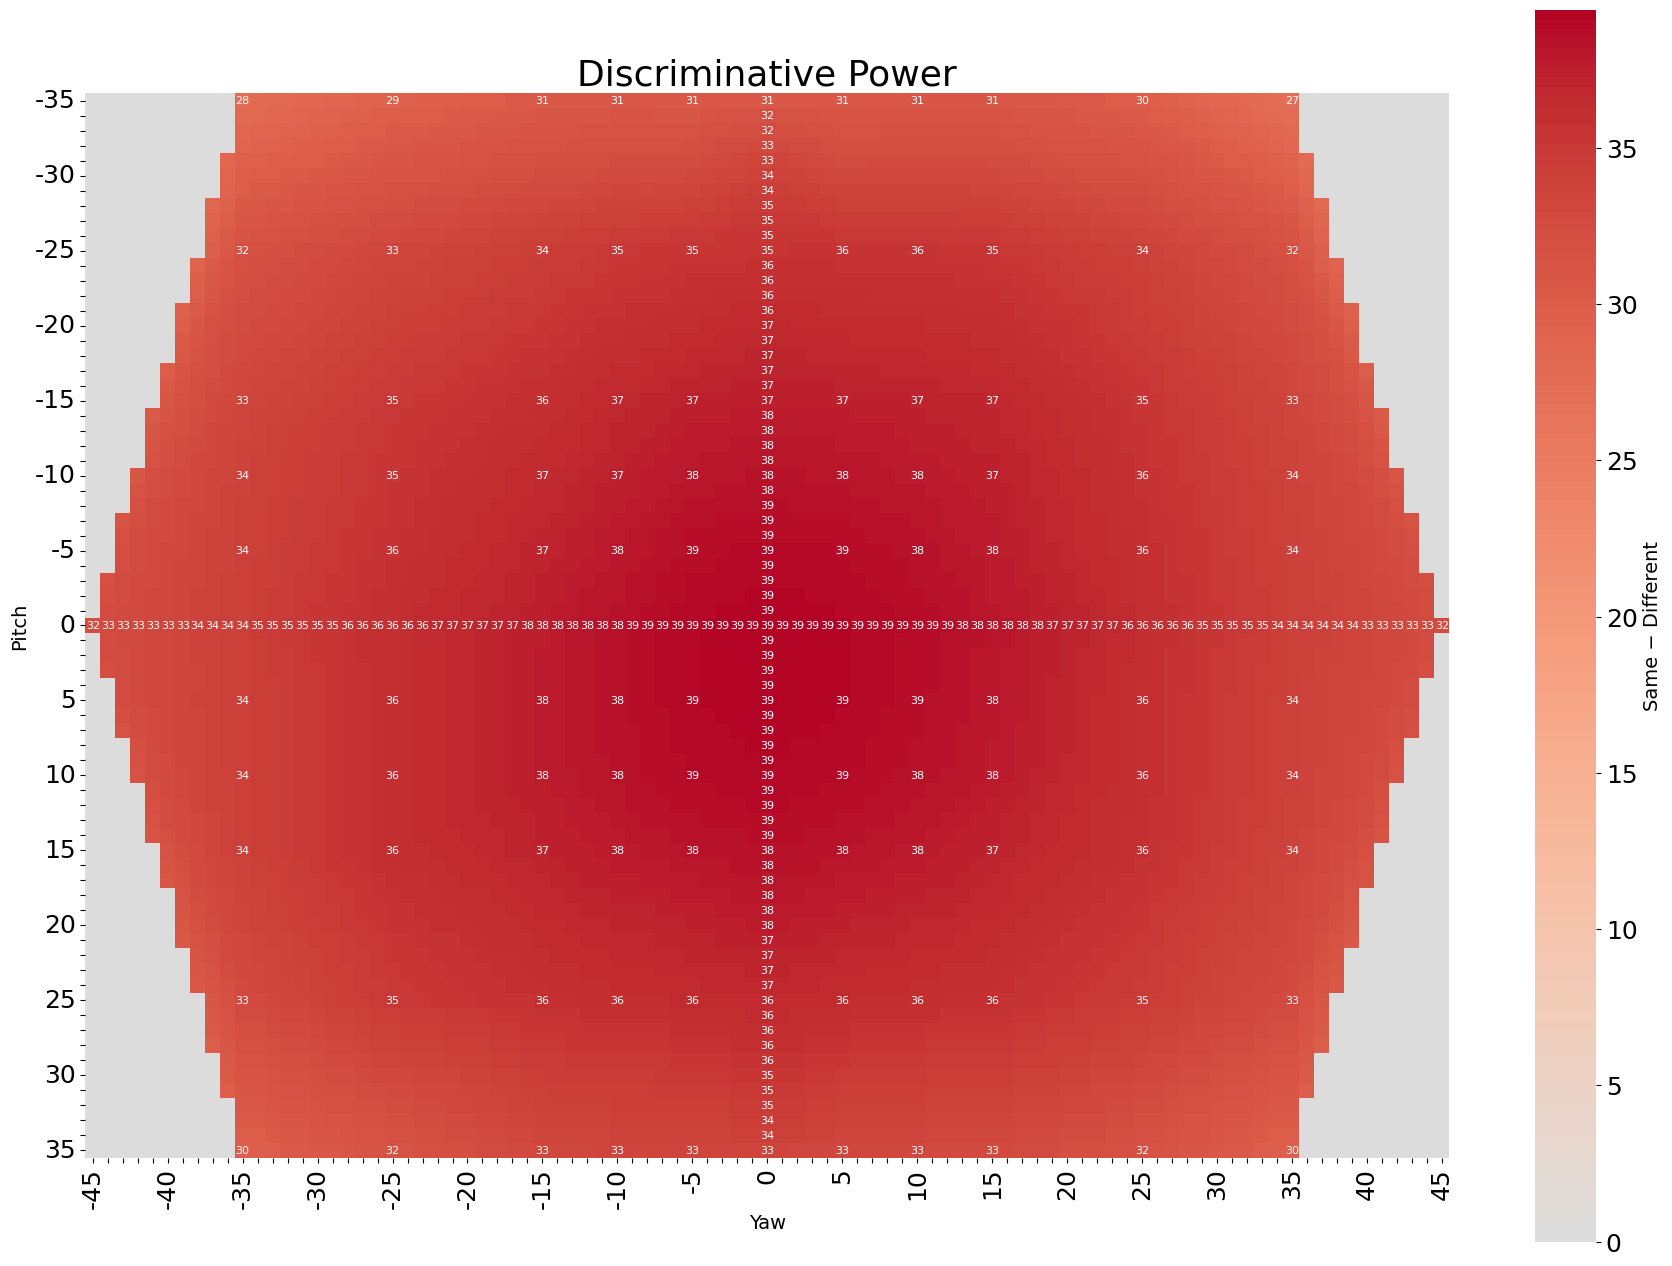

Compute distances: 100%|██████████| 19786/19786 [13:03<00:00, 25.26it/s]


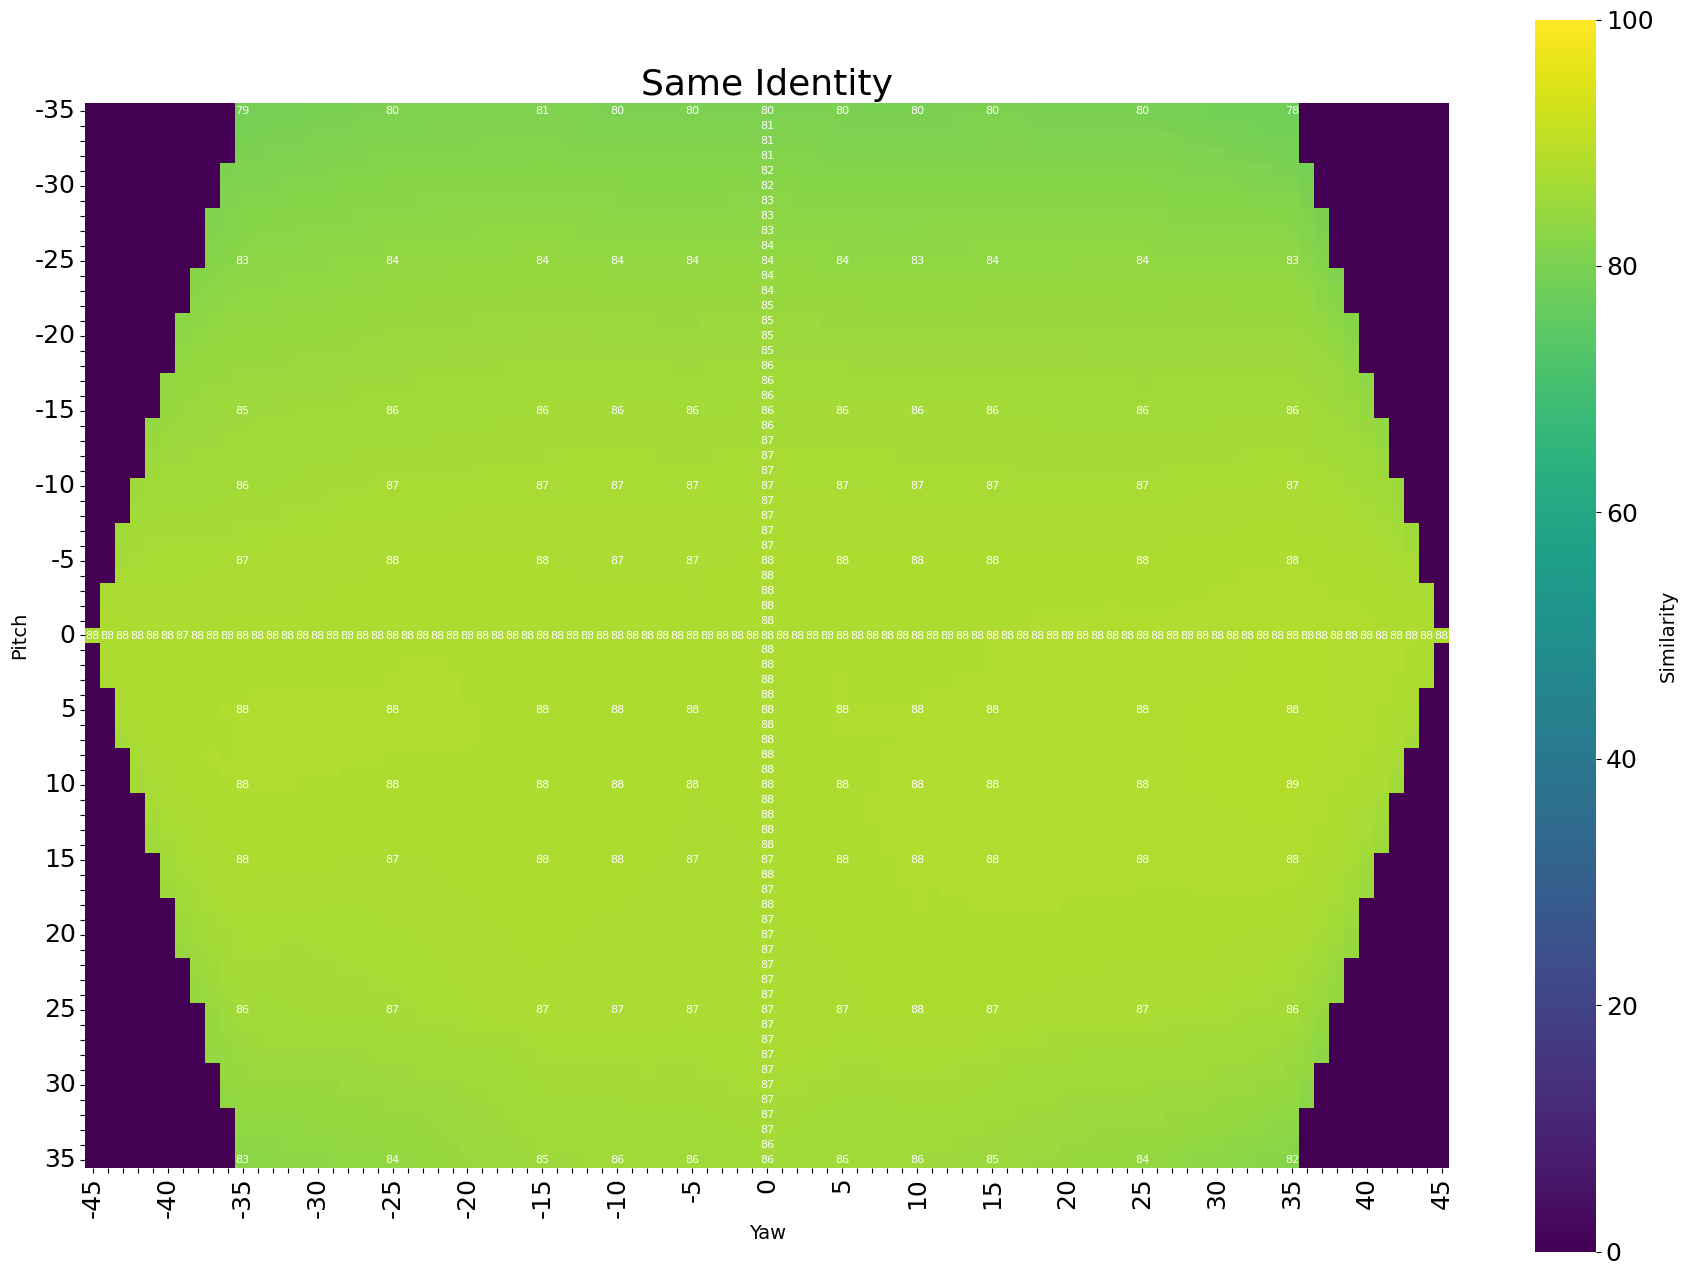

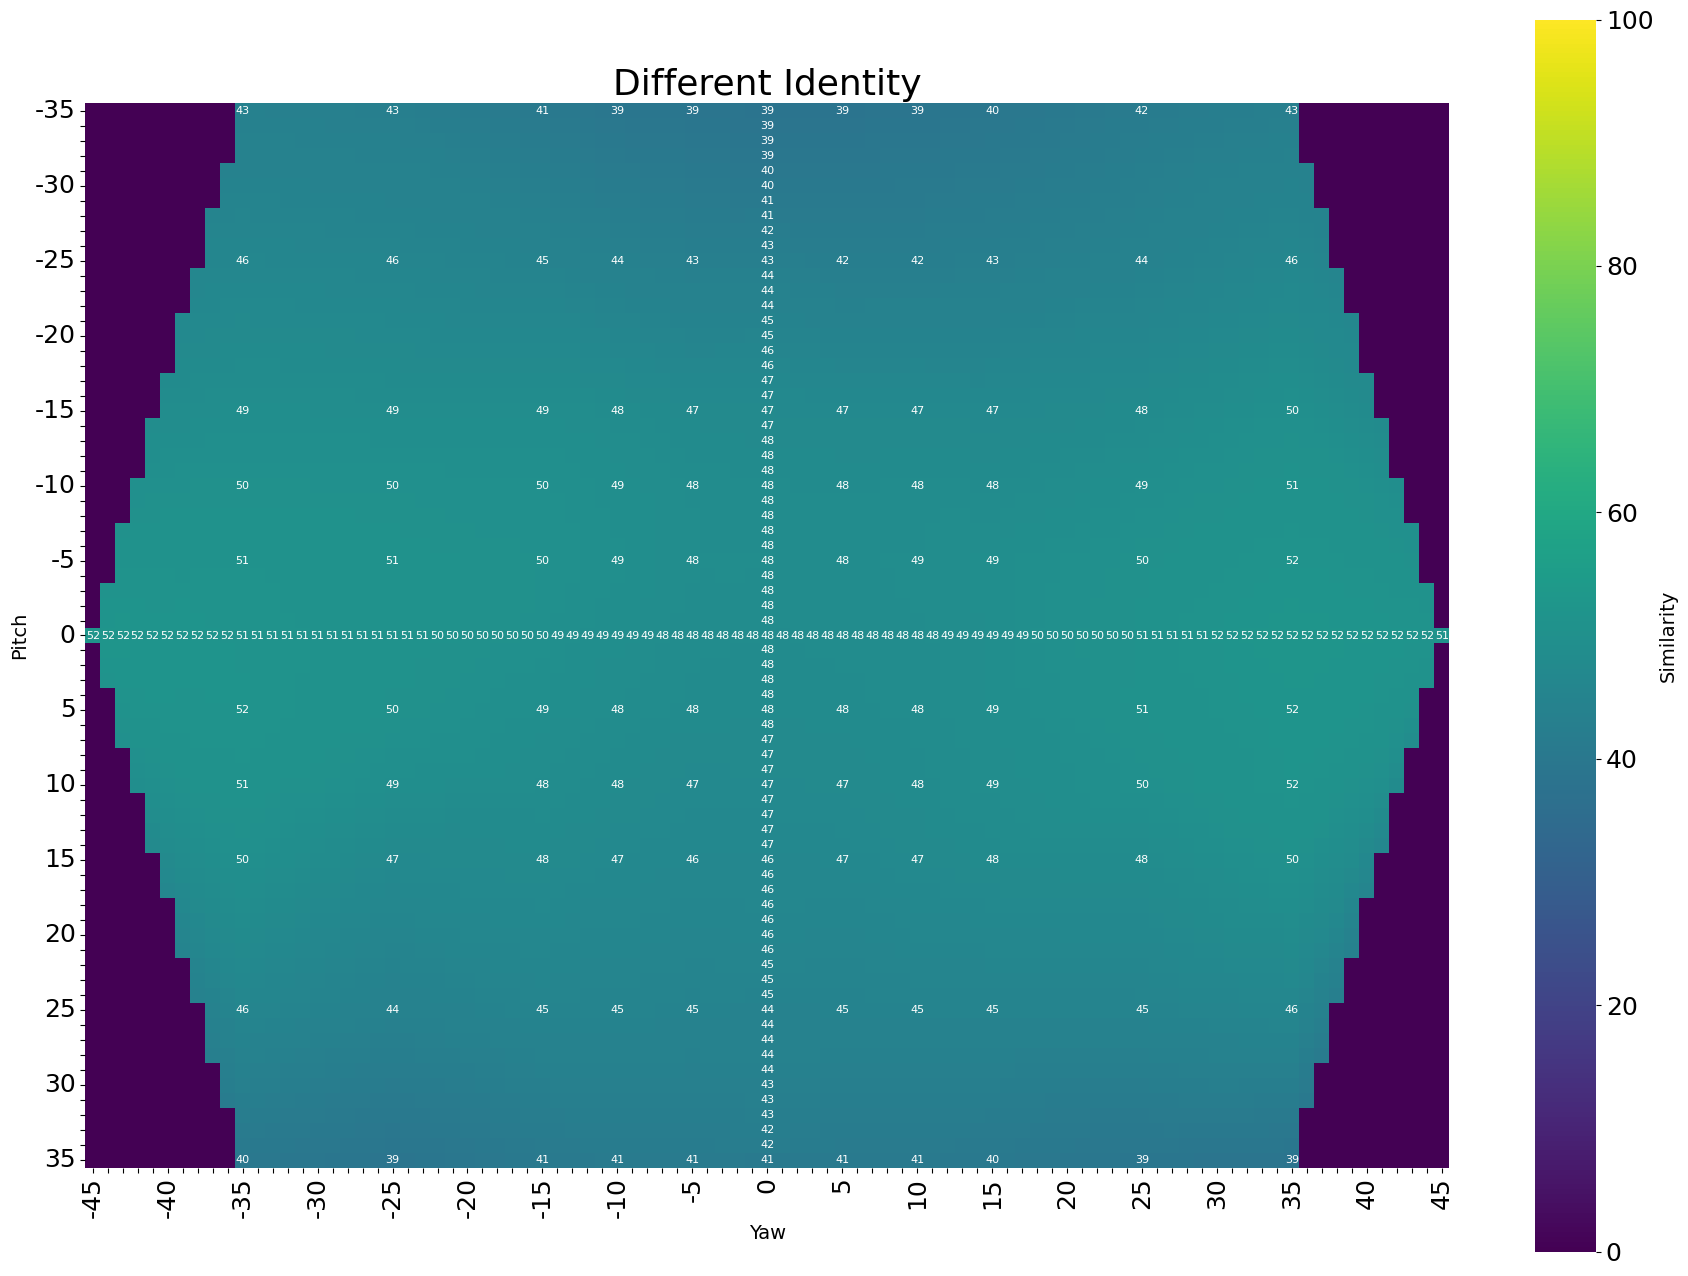

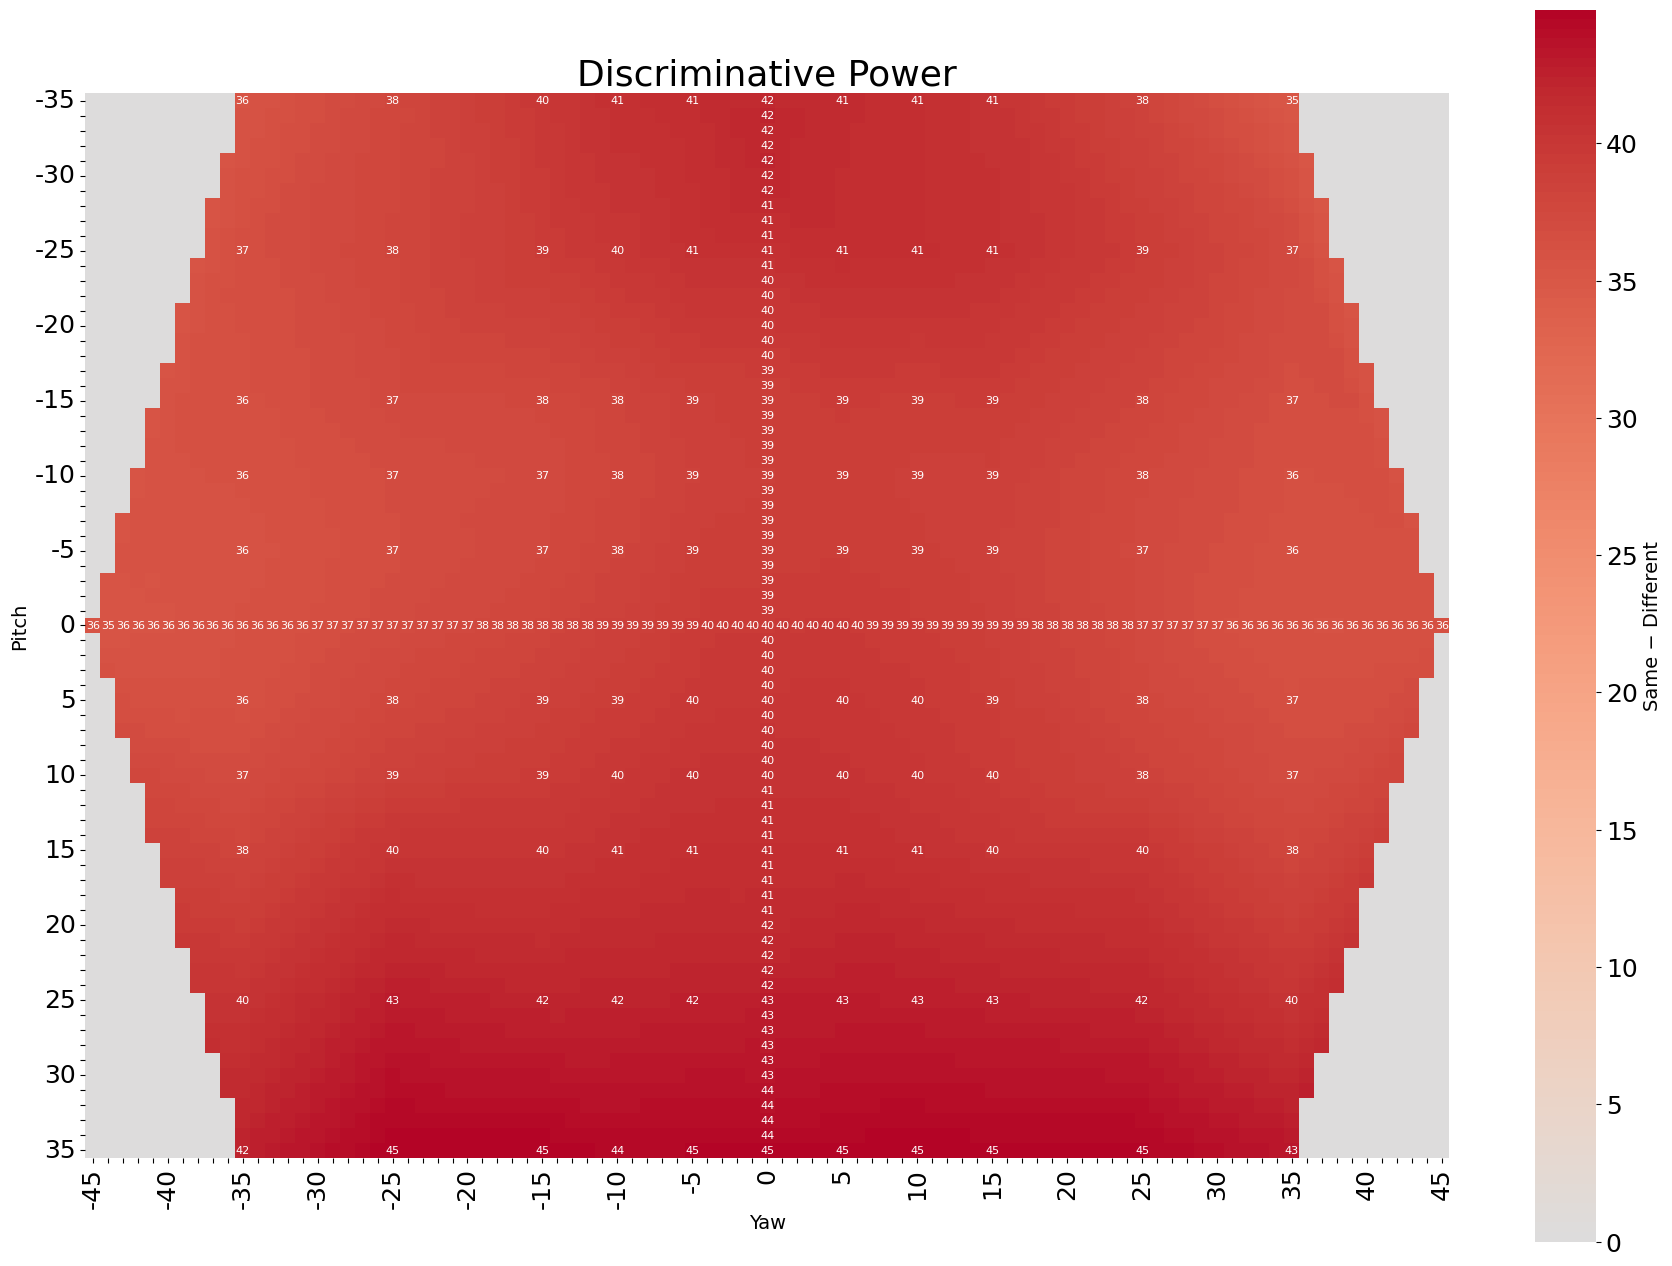

In [41]:
name="rgb_bff_crop261_emb-FaceNetWeb"
dataset = EmbeddingDataset(r"F:/Face/data/dataset15_emb/"+name, disable_tqdm=False)
avg_same, avg_diff, pitches, yaws = compute_average_heatmaps(dataset, center_pose=(0, 0), prefix=name, visualize=True)
avg_same, avg_diff, differences, pitches, yaws = compute_average_heatmaps_pairwise(dataset, prefix=name, visualize=True)

Compute distances: 100%|██████████| 19786/19786 [08:59<00:00, 36.64it/s]


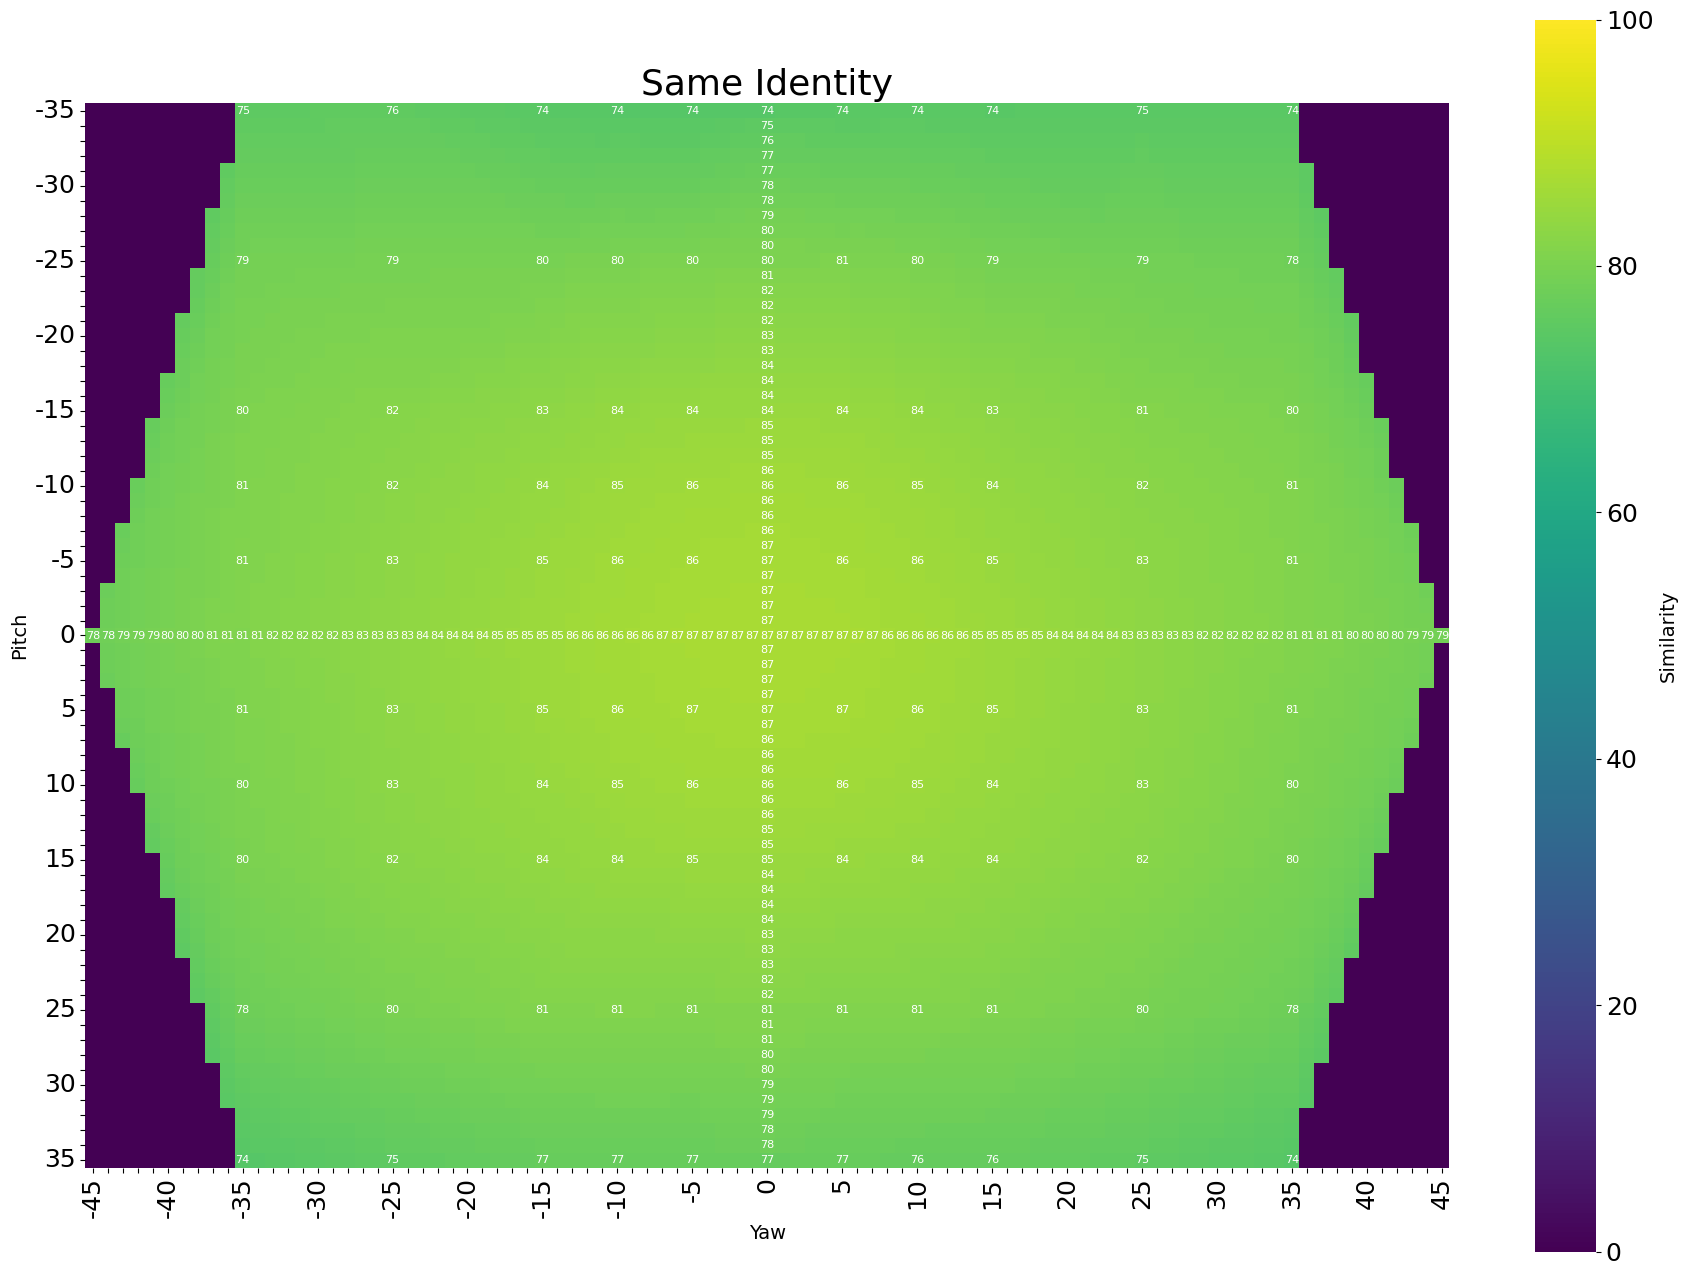

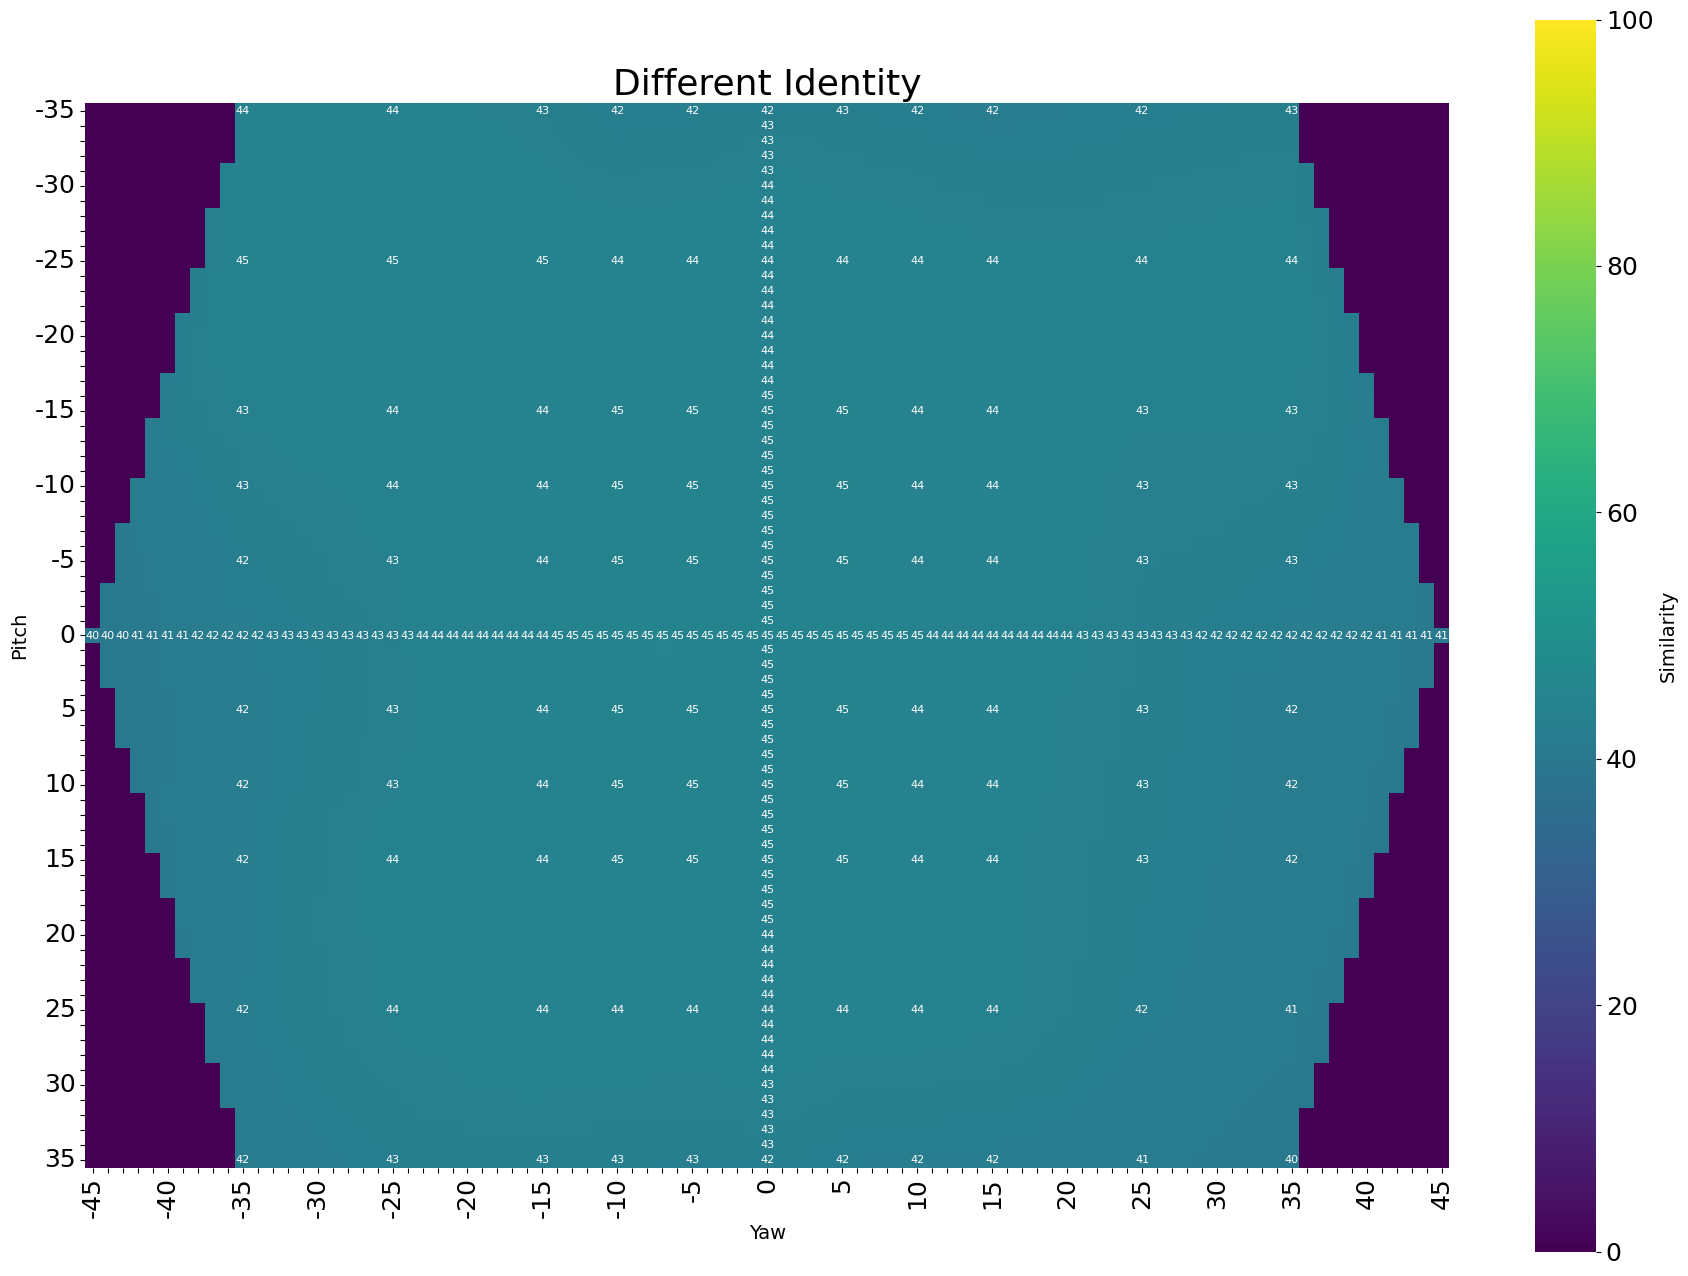

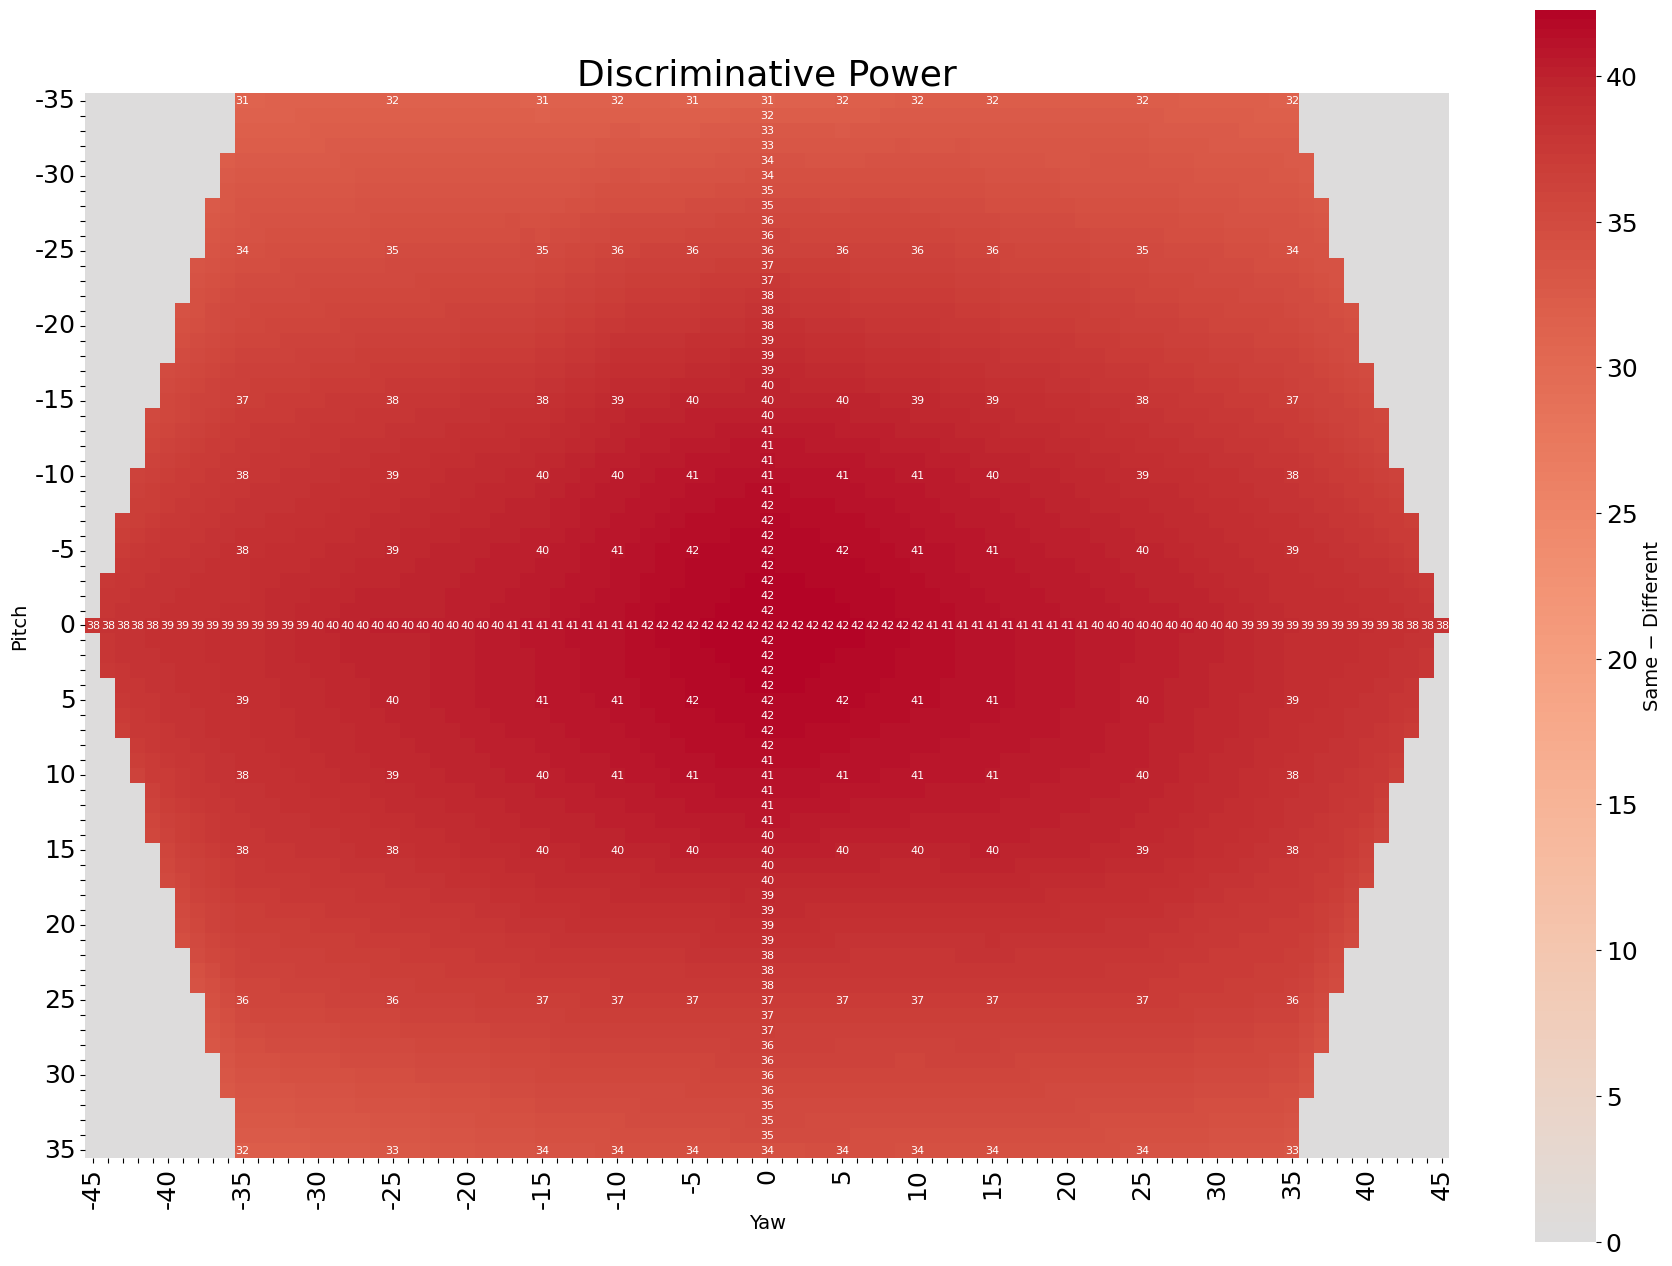

Compute distances: 100%|██████████| 19786/19786 [13:55<00:00, 23.68it/s]


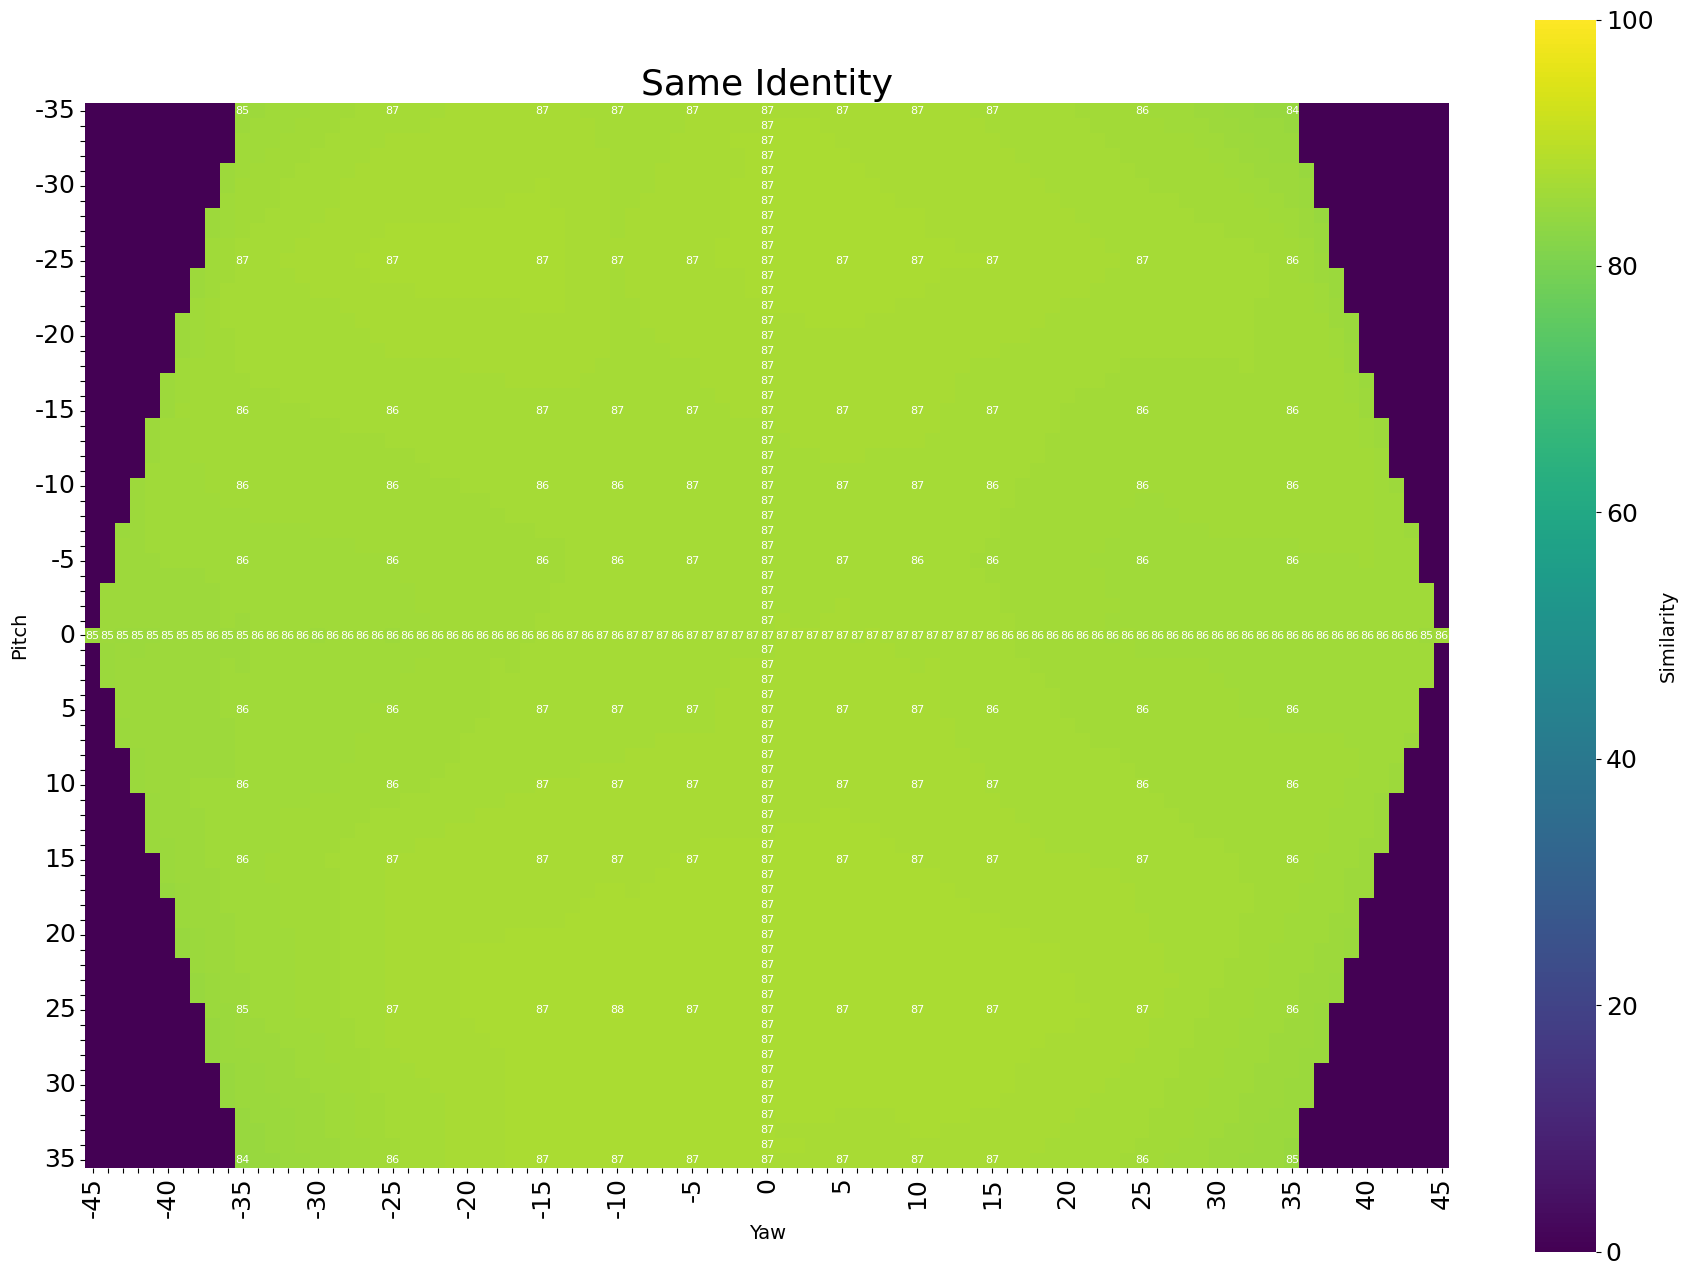

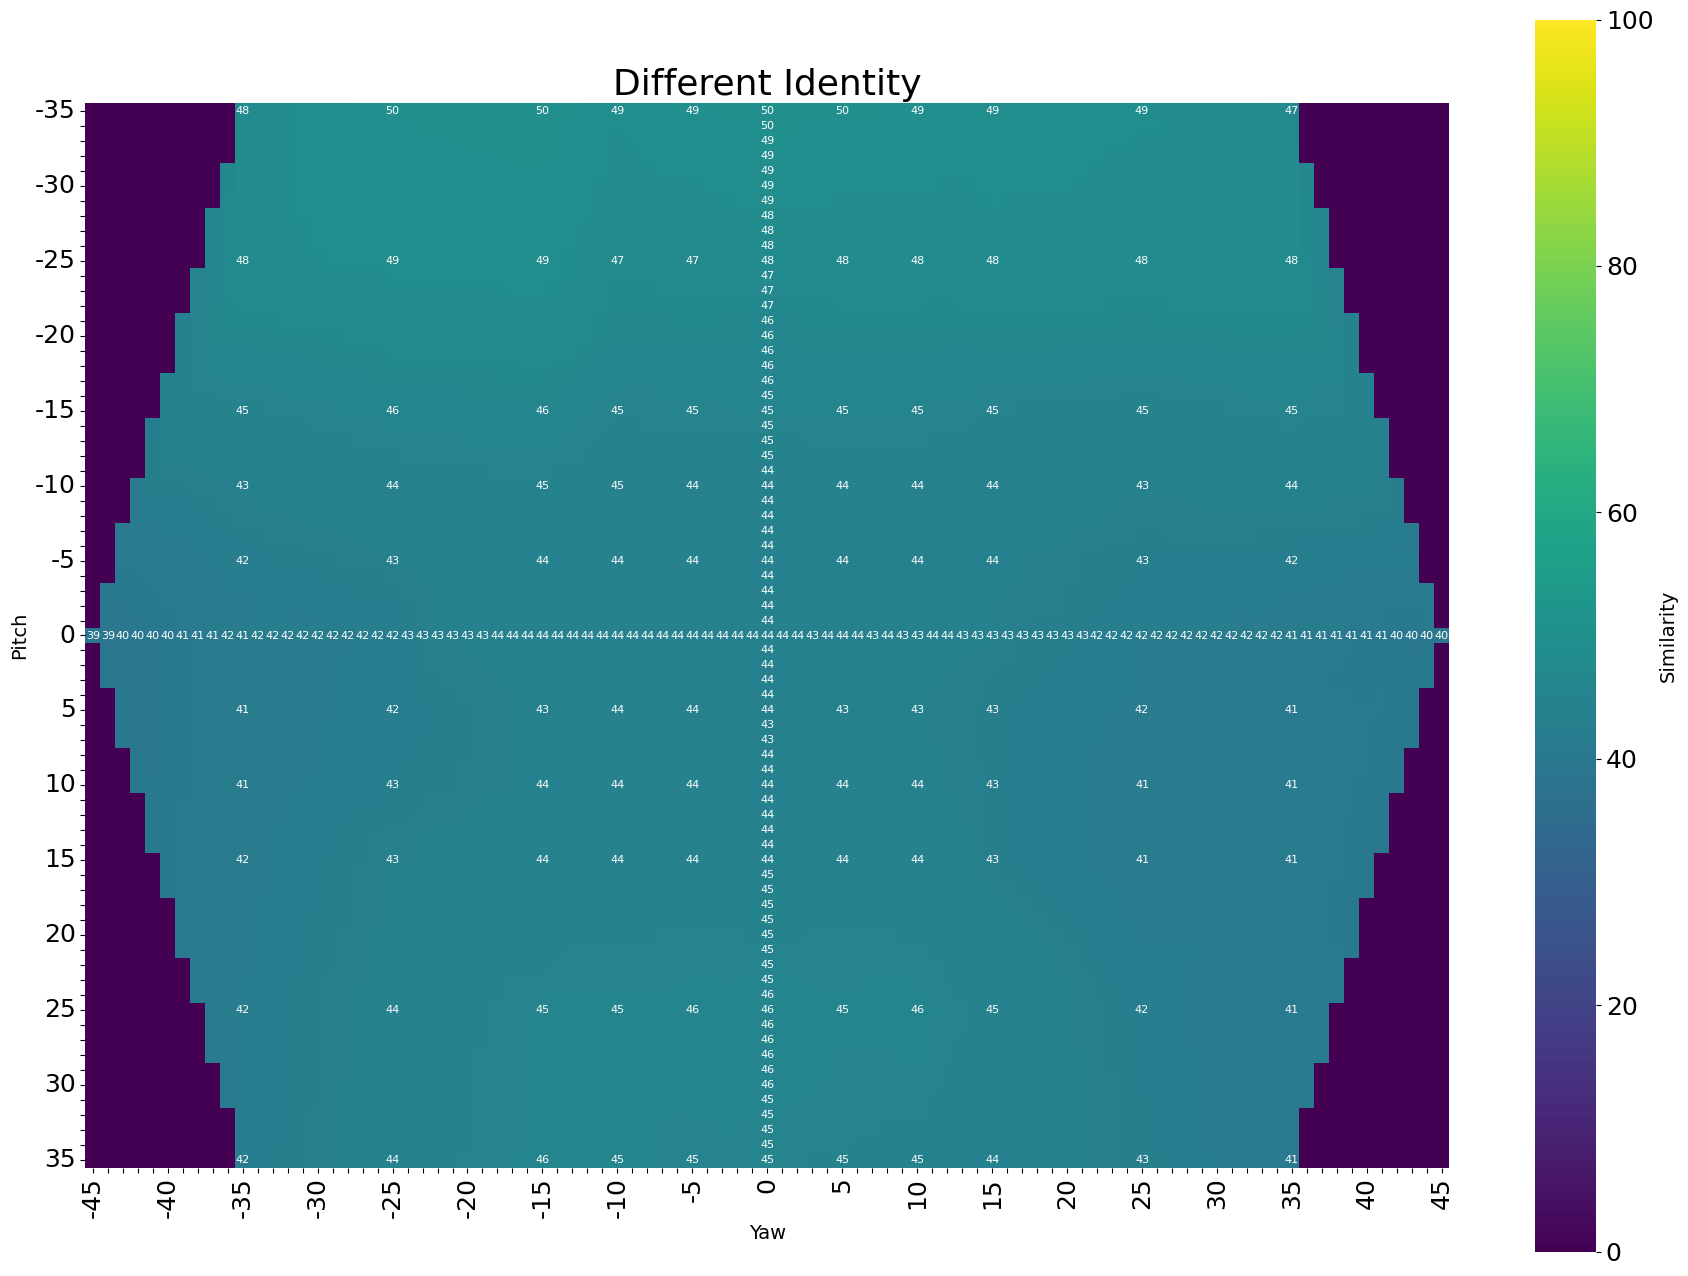

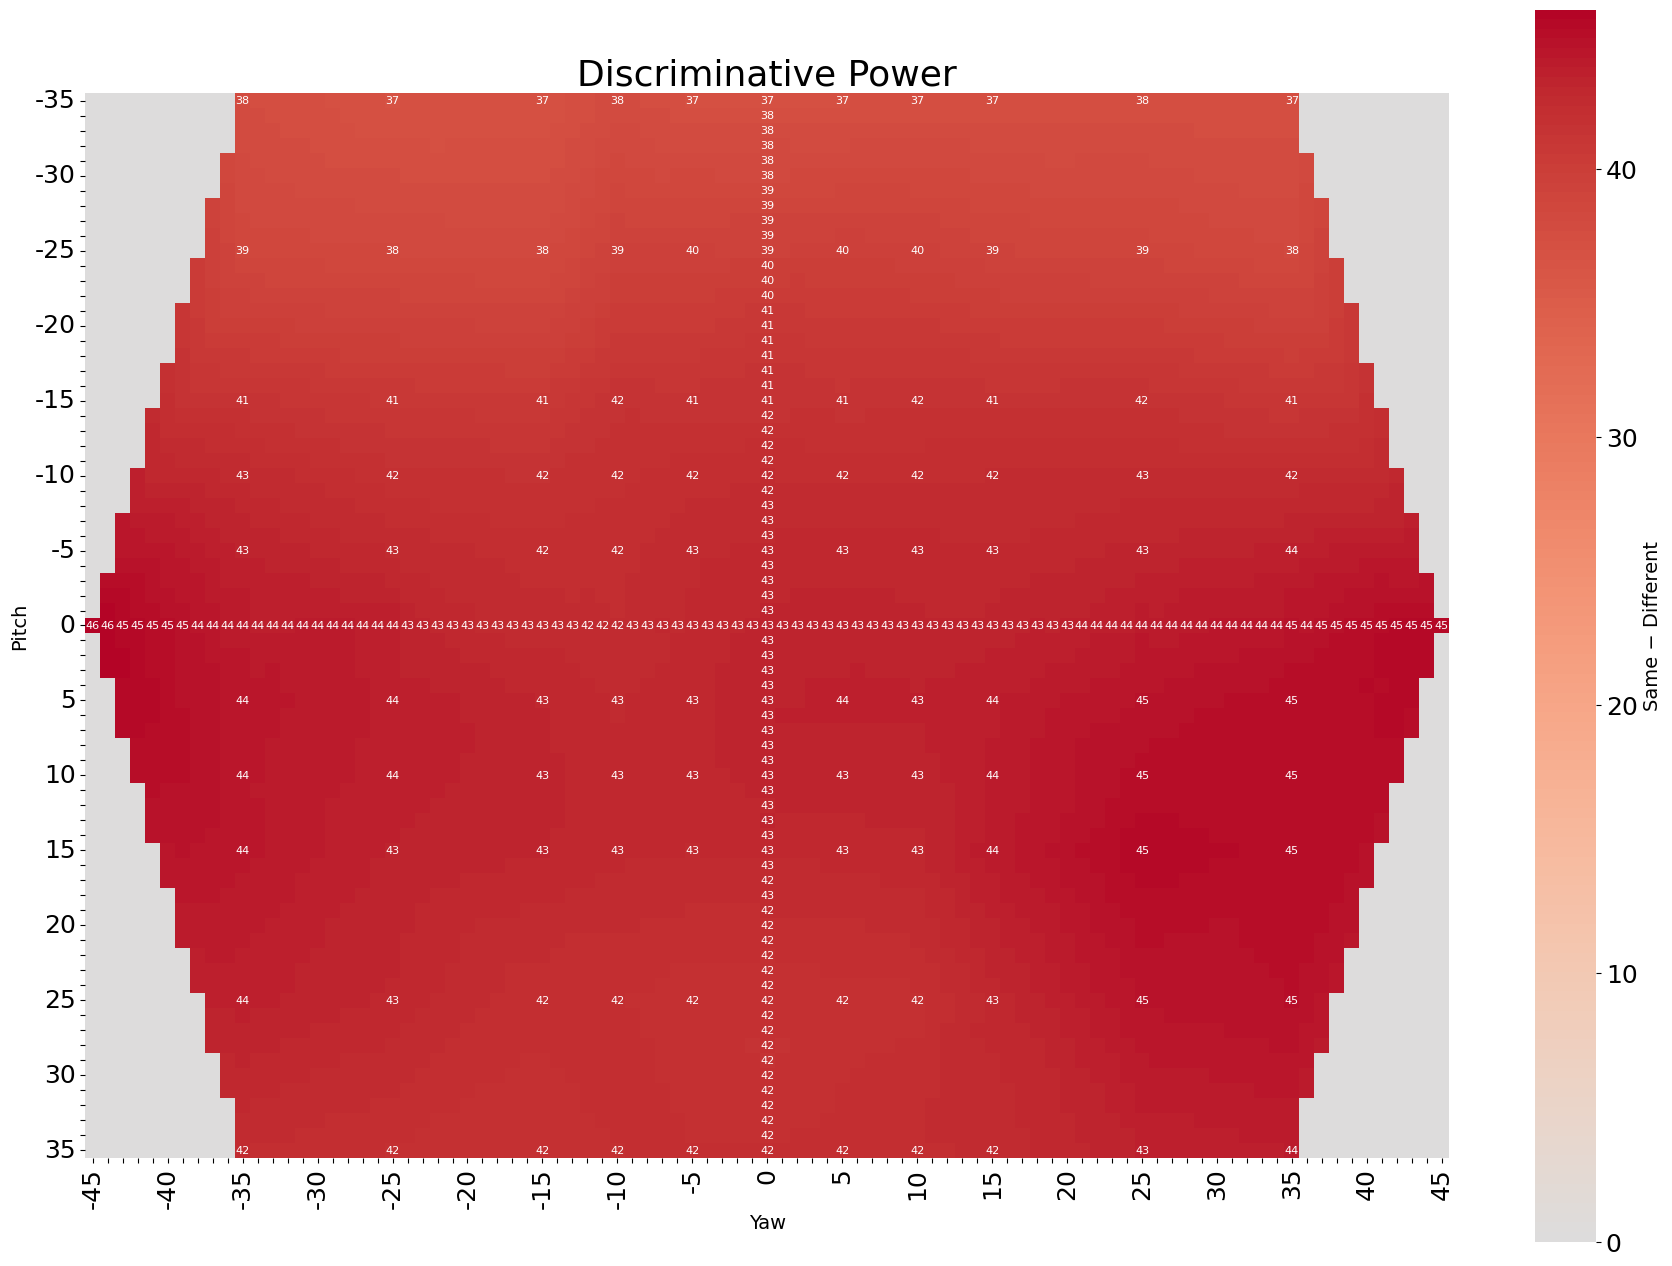

In [42]:
name="rgb_bff_crop261_emb-FaceNetVGG"
dataset = EmbeddingDataset(r"F:/Face/data/dataset15_emb/"+name, disable_tqdm=False)
avg_same, avg_diff, pitches, yaws = compute_average_heatmaps(dataset, center_pose=(0, 0), prefix=name, visualize=True)
avg_same, avg_diff, differences, pitches, yaws = compute_average_heatmaps_pairwise(dataset, prefix=name, visualize=True)